
## Spin glass $N=14$
 

In [ ]:
import itertools
import os

import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

In [ ]:
n = 14 
circ_depths = np.asarray([1,2])
algs = np.asarray(["qaoa", "qaoa+", "vqe"])
seeds = np.arange(1, 31)

#model_info = [(n, algo, p, seed) for p in circ_depths for algo in algs for seed in seeds]

In [ ]:
jobs_df = pd.read_csv("data_n14_spinglass.csv")

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(24, 5))
for shot, data in jobs_df.groupby('shots'):
    if shot != 512:
        continue

    boxplot_data = []
    for it in np.arange(5,40,5):
        boxplot_data.append(data[(jobs_df['algo'] == 'qaoa') & (data['iter'] == it)]['p_succ'])
    ax1.boxplot(boxplot_data)
    ax1.set_title(f"QAOA shots={shot}")
    ax1.set_xticks(np.arange(8), np.arange(0,40,5))
    ax1.set_xlabel("iterations")
    ax1.set_ylabel(r"$F('success')$")

    boxplot_data = []
    for it in np.arange(5,40,5):
        boxplot_data.append(data[(jobs_df['algo'] == 'qaoa+') & (data['iter'] == it)]['p_succ'])
    ax2.boxplot(boxplot_data)
    ax2.set_title(f"QAOA+ shots={shot}")
    ax2.set_xticks(np.arange(8), np.arange(0,40,5))
    ax2.set_ylim(0,1)
    ax2.set_xlabel("iterations")
    ax2.set_ylabel(r"$F('success')$")
 
    boxplot_data = []
    for it in np.arange(5,40,5):
        boxplot_data.append(data[(jobs_df['algo'] == 'vqe') & (data['iter'] == it)]['p_succ'])
    ax3.boxplot(boxplot_data)
    ax3.set_title(f"VQE shots={shot}")
    ax3.set_xticks(np.arange(8), np.arange(0,40,5))
    ax3.set_ylim(0,1)
    ax3.set_xlabel("iterations")
    ax3.set_ylabel(r"$F('success')$")

plt.savefig("boxplot_shot512.png")

In [ ]:
for shot, data in jobs_df[(jobs_df['algo'] == 'qaoa') & (jobs_df['iter'] < 37)].groupby('shots'):
    x_axes = data[data['seed'] == 1]['t']*data[data['seed'] == 1]["circ_depth"]
    y_axes = data.groupby(['iter'])['p_succ'].mean()
    error = data.groupby(['iter'])['p_succ'].std()

    plt.errorbar(x_axes, y_axes, yerr=data.groupby(['iter'])['p_succ'].std(), marker="o", label=f"{shot}")
    plt.fill_between(x_axes, data.groupby(['iter'])['p_succ'].min(), data.groupby(['iter'])['p_succ'].max(), alpha=0.3)

plt.plot(np.arange(0,2**(3+n),2), 1 - (1-1/(2**n))**np.arange(0,2**(3+n),2), '--', color="black", label="Random sampling")
plt.xscale("log", base=2)

plt.xlabel("iterations x shots x depth")
plt.ylabel(r"$F('success')$")

plt.title(f"$N=14$ QAOA $p=2$")
plt.legend(title='Shots')
plt.savefig("n14_spinglass_qaoap2.png")
    #print(data[data['seed'] == 1]['t'])

In [ ]:
for shot, data in jobs_df[(jobs_df['algo'] == 'qaoa+')].groupby('shots'):
    plt.errorbar(data[data['seed'] == 1]['t'], data.groupby(['iter'])['p_succ'].mean(), yerr=data.groupby(['iter'])['p_succ'].std(), marker="o", label=f"{shot}")

plt.plot(np.arange(0,2**(3+n),2), 1 - (1-1/(2**n))**np.arange(0,2**(3+n),2), '--', color="black", label="Random sampling")
plt.xscale("log", base=2)

plt.xlabel("iterations x shots x depth")
plt.ylabel(r"$F('success')$")

plt.title(f"$N=14$ QAOA+ $p=1$")
plt.legend(title='Shots')
plt.savefig("n14_spinglass_qaoap+2.png")


In [ ]:
for shot, data in jobs_df[(jobs_df['algo'] == 'vqe')].groupby('shots'):
    plt.errorbar(data[data['seed'] == 1]['t'], data.groupby(['iter'])['p_succ'].mean(), yerr=data.groupby(['iter'])['p_succ'].std(), marker="o", label=f"{shot}")

plt.plot(np.arange(0,2**(3+n),2), 1 - (1-1/(2**n))**np.arange(0,2**(3+n),2), '--', color="black", label="Random sampling")
plt.xscale("log", base=2)

plt.xlabel("iterations x shots x depth")
plt.ylabel(r"$F('success')$")

plt.title(f"$N=14$ VQE $p=1$")
plt.legend(title='Shots')
plt.savefig("n14_spinglass_vqep1.png")



## Spin glass $4 \leq N \leq 12$

In [ ]:
import itertools
import os

import numpy as np
import pandas as pd
import json
from scipy import optimize
import matplotlib.pyplot as plt

In [ ]:
jobs_df = pd.read_csv("dataspinglass-COMPLETE.csv", index_col=False)

In [ ]:
print(jobs_df.head(10))
# uncomment to remove the unnamed column
#jobs_df.drop('Unnamed: 0', axis=1, inplace=True)

# seeds = np.arange(1,31)
# qubits=14
# print(jobs_df[(jobs_df['circ_depth'] == 1) & (jobs_df['iter'] % 5 != 0) & (jobs_df['iter'] != 1)]) 

# indexes = jobs_df[(jobs_df['circ_depth'] == 1) & (jobs_df['iter'] > 25)].index
# jobs_df.drop(indexes, inplace=True)

# print(jobs_df[(jobs_df['circ_depth'] == 1) & (jobs_df['iter'] % 5 != 0) & (jobs_df['iter'] != 1)]) 

jobs_df.to_csv(f"dataspinglass.csv")

In [ ]:
depth = 4

fig = plt.figure(constrained_layout=True, figsize=(16,10))
subplots = fig.subplots(2,3)
for (qubits, data), subplot in zip(jobs_df[(jobs_df['algo'] == 'qaoa') & (jobs_df['circ_depth'] == depth)].groupby('qubits'), subplots.ravel()):
    for shot, dat in data.groupby('shots'):
        x_axes = dat[dat['seed'] == 1]['t']#*dat[dat['seed'] == 1]["circ_depth"]
        y_axes = dat.groupby(['iter'])['p_succ'].median()
        error = [
            (dat.groupby(['iter'])['p_succ'].median() - dat.groupby(['iter'])['p_succ'].quantile(0.25)).tolist(),
            (dat.groupby(['iter'])['p_succ'].quantile(0.75) - dat.groupby(['iter'])['p_succ'].median()).tolist(),
            ]

        subplot.errorbar(x_axes, y_axes, yerr=error, marker="o", label=f"{shot}")
        subplot.fill_between(x_axes, dat.groupby(['iter'])['p_succ'].quantile(0.95), dat.groupby(['iter'])['p_succ'].quantile(0.05), alpha=0.3)

    subplot.plot(np.arange(0,2**(5+qubits),2), 1 - (1-1/(2**qubits))**np.arange(0,2**(5+qubits),2), '--', color="black", label="Random sampling")
    subplot.set_xscale("log", base=2)

    subplot.set_xlabel(r"$n_{calls}$")
    subplot.set_ylabel(r"$F_{succ}$")

    subplot.set_title(f"N={qubits} QAOA p={depth}")
    subplot.legend(title='Shots')

#plt.savefig('spinglass_all.png')
    # plt.show()

In [ ]:
# jobs_correct = pd.read_csv("data-n4-8_spinglass-PART.csv")

# fig = plt.figure(constrained_layout=True, figsize=(12,5))
# subplots = fig.subplots(1,2)
# for (qubits, data), subplot in zip(jobs_correct[(jobs_correct['algo'] == 'qaoa') & (jobs_correct['circ_depth'] == 1) & (jobs_correct['iter'] <= 25)].groupby('qubits'), subplots):
#     for shot, dat in data.groupby('shots'):
#         x_axes = dat[dat['seed'] == 1]['t']*dat[dat['seed'] == 1]["circ_depth"]
#         y_axes = dat.groupby(['iter'])['p_succ'].median()
#         error = [
#             (dat.groupby(['iter'])['p_succ'].median() - dat.groupby(['iter'])['p_succ'].quantile(0.25)).tolist(),
#             (dat.groupby(['iter'])['p_succ'].quantile(0.75) - dat.groupby(['iter'])['p_succ'].median()).tolist(),
#             ]
#         subplot.errorbar(x_axes, y_axes, yerr=error, marker="o", label=f"{shot}")
#         subplot.fill_between(x_axes, dat.groupby(['iter'])['p_succ'].min(), dat.groupby(['iter'])['p_succ'].max(), alpha=0.3)

#     subplot.plot(np.arange(0,2**(5+qubits),2), 1 - (1-1/(2**qubits))**np.arange(0,2**(5+qubits),2), '--', color="black", label="Random sampling")
#     subplot.set_xscale("log", base=2)

#     subplot.set_xlabel("iterations x shots x depth")
#     subplot.set_ylabel(r"$F('success')$")

#     subplot.set_title(f"N={qubits} QAOA p=1")
#     subplot.legend(title='Shots')

# plt.savefig('spinglass_correct.png')

In [ ]:
def fun_exp(x, a, b):
    return a*2**(b*x)

def fun_lin(x, a, b):
    return a + b*x

min_qubits, max_qubits = 6, 14
min_qubits_toplot, max_qubits_toplot = 9, 16
qubits_toplot = np.arange(min_qubits_toplot, max_qubits_toplot)


fig = plt.figure()

plt.plot(np.arange(min_qubits, max_qubits+2), fun_exp(np.arange(min_qubits, max_qubits+2), 1, 1), color='red', linewidth=3.5, linestyle="dashed")

p_tresholds = [0.9, 0.75, 0.5, 0.25]
colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'cornflowerblue' , 'blue', 'navy']
for p, color in zip(p_tresholds, colors):
    median_for_seed = jobs_df[(jobs_df['algo'] == 'qaoa') & (jobs_df['circ_depth'] == depth) & (jobs_df['qubits'] >= min_qubits)].groupby(['t', 'qubits', 'circ_depth'], as_index=False).agg(avg_p_succ = ("p_succ", "median"))
    gt_p = median_for_seed[median_for_seed['avg_p_succ'] > p].groupby('qubits', as_index=False)['t'].min()

    popt, _ = optimize.curve_fit(fun_lin, gt_p['qubits'][-3:], np.log2(gt_p['t'][-3:]))
    plt.plot(qubits_toplot, fun_exp(qubits_toplot, 2**popt[0], popt[1]), "-", label=f"a={2**popt[0]:.2f}, b={popt[1]:.2f}", color=color)
    
    plt.plot(gt_p['qubits'], gt_p['t'], "o", label=r"$F_{succ}$"+f"={p}", color=color)

    plt.yscale('log', base=2)
    plt.ylabel(r"$N_{calls}$")
    plt.xlabel(r"$L$")
    plt.xticks(np.arange(min_qubits, max_qubits+1, 2))

plt.legend(loc='upper left', title=f"QAOA p={depth}", fontsize="x-small")

plt.title(r"Fit with $a \cdot 2^{b \cdot L}$")

#plt.savefig(f"scale_spinglass-{min_qubits}.png")

In [ ]:
def fun_exp(x, a, b):
    return a*2**(b*x)

def fun_lin(x, a, b):
    return a + b*x

min_qubits, max_qubits = 4, 8

fig = plt.figure()

plt.plot(np.arange(min_qubits, max_qubits+1), fun_exp(np.arange(min_qubits, max_qubits+1), 1, 1), color='red', linewidth=3.5, linestyle="dashed")

p_tresholds = [0.99, 0.9, 0.75, 0.5, 0.25]
colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'cornflowerblue' , 'blue', 'navy']
for p, color in zip(p_tresholds, colors):
    median_for_seed = jobs_correct[(jobs_correct['algo'] == 'qaoa') & (jobs_correct['circ_depth'] == 1)].groupby(['t', 'qubits', 'circ_depth'], as_index=False).agg(avg_p_succ = ("p_succ", "median"))
    gt_p = median_for_seed[median_for_seed['avg_p_succ'] > p].groupby('qubits', as_index=False)['t'].min()

    popt, _ = optimize.curve_fit(fun_lin, gt_p['qubits'], np.log2(gt_p['t']*median_for_seed['circ_depth'][0]))
    plt.plot(gt_p['qubits'], fun_exp(gt_p['qubits'], 2**popt[0], popt[1]), "-", label=f"a={2**popt[0]:.2f}, b={popt[1]:.2f}", color=color)
    
    plt.plot(gt_p['qubits'], gt_p['t']*median_for_seed['circ_depth'][0], "o", label=f"F('succ')={p}", color=color)

    plt.yscale('log', base=2)
    plt.ylabel(r"$t$ (shots x iterations x circ_depth)")
    plt.xlabel(r"$N$")

plt.legend(loc='lower right', title=r"QAOA $p=1$", fontsize="x-small")

plt.title(r"Spin Glass fit with $a \cdot 2^{b \cdot N}$")

In [ ]:
depth = 1

fig = plt.figure(constrained_layout=True, figsize=(16,10))
subplots = fig.subplots(2,3)
for (qubits, data), subplot in zip(jobs_df[(jobs_df['algo'] == 'qaoa') & (jobs_df['circ_depth'] == depth)].groupby('qubits'), subplots.ravel()):
    for shot, dat in data.groupby('shots'):
        x_axes = dat[dat['seed'] == 1]['t']*dat[dat['seed'] == 1]["circ_depth"]
        y_axes = dat.groupby(['iter'])['p_succ'].median()
        error = [
            (dat.groupby(['iter'])['p_succ'].median() - dat.groupby(['iter'])['p_succ'].quantile(0.25)).tolist(),
            (dat.groupby(['iter'])['p_succ'].quantile(0.75) - dat.groupby(['iter'])['p_succ'].median()).tolist(),
            ]

        subplot.errorbar(x_axes, y_axes, yerr=error, marker="o", label=f"{shot}")
        subplot.fill_between(x_axes, dat.groupby(['iter'])['p_succ'].quantile(0.95), dat.groupby(['iter'])['p_succ'].quantile(0.05), alpha=0.3)

    subplot.plot(np.arange(0,2**(5+qubits),2), 1 - (1-1/(2**qubits))**np.arange(0,2**(5+qubits),2), '--', color="black", label="Random sampling")
    subplot.set_xscale("log", base=2)

    subplot.set_xlabel("iterations x shots x depth")
    subplot.set_ylabel(r"$F('success')$")

    subplot.set_title(f"N={qubits} QAOA p={depth}")
    subplot.legend(title='Shots')


## For paper

These lines MUST be clean

In [1]:
import itertools
import os

import numpy as np
import pandas as pd
import json
from scipy import optimize
import matplotlib.pyplot as plt

In [2]:
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title


### Figure 2


In [3]:
ferro_list = [pd.read_csv(f"data_n{n}-test.csv", index_col=0) for n in range(4,22,2)]
ferro_df = pd.concat(ferro_list, ignore_index=True)
ferro_df.head()

t  shots  iter  p_succ  qubits  circ_depth algo  succ_true  succ_false  \
0   2      2     1   0.170       4           1  vqe        170         830   
1   4      2     2   0.273       4           1  vqe        273         727   
2   8      2     4   0.342       4           1  vqe        342         658   
3  12      2     6   0.436       4           1  vqe        436         564   
4  16      2     8   0.508       4           1  vqe        508         492   

   p_succ_final  
0         0.099  
1         0.121  
2         0.121  
3         0.143  
4         0.153

In [12]:
spinglass = pd.read_csv("dataspinglass.csv", index_col=0)
spinglass.head()

t  shots  iter  p_succ  qubits  circ_depth  algo  seed
0   2      2     1   0.192       4           1  qaoa     1
1  10      2     5   0.590       4           1  qaoa     1
2  20      2    10   0.801       4           1  qaoa     1
3  30      2    15   0.863       4           1  qaoa     1
4  40      2    20   0.937       4           1  qaoa     1

In [13]:
spinglass16 = pd.read_csv("dataspinglass-n16.csv", index_col=0)
#print(spinglass16)
spinglass_df = pd.concat([spinglass, spinglass16], ignore_index=True)

In [40]:
spinglass_df.to_csv("dataspinglass_complete.csv")

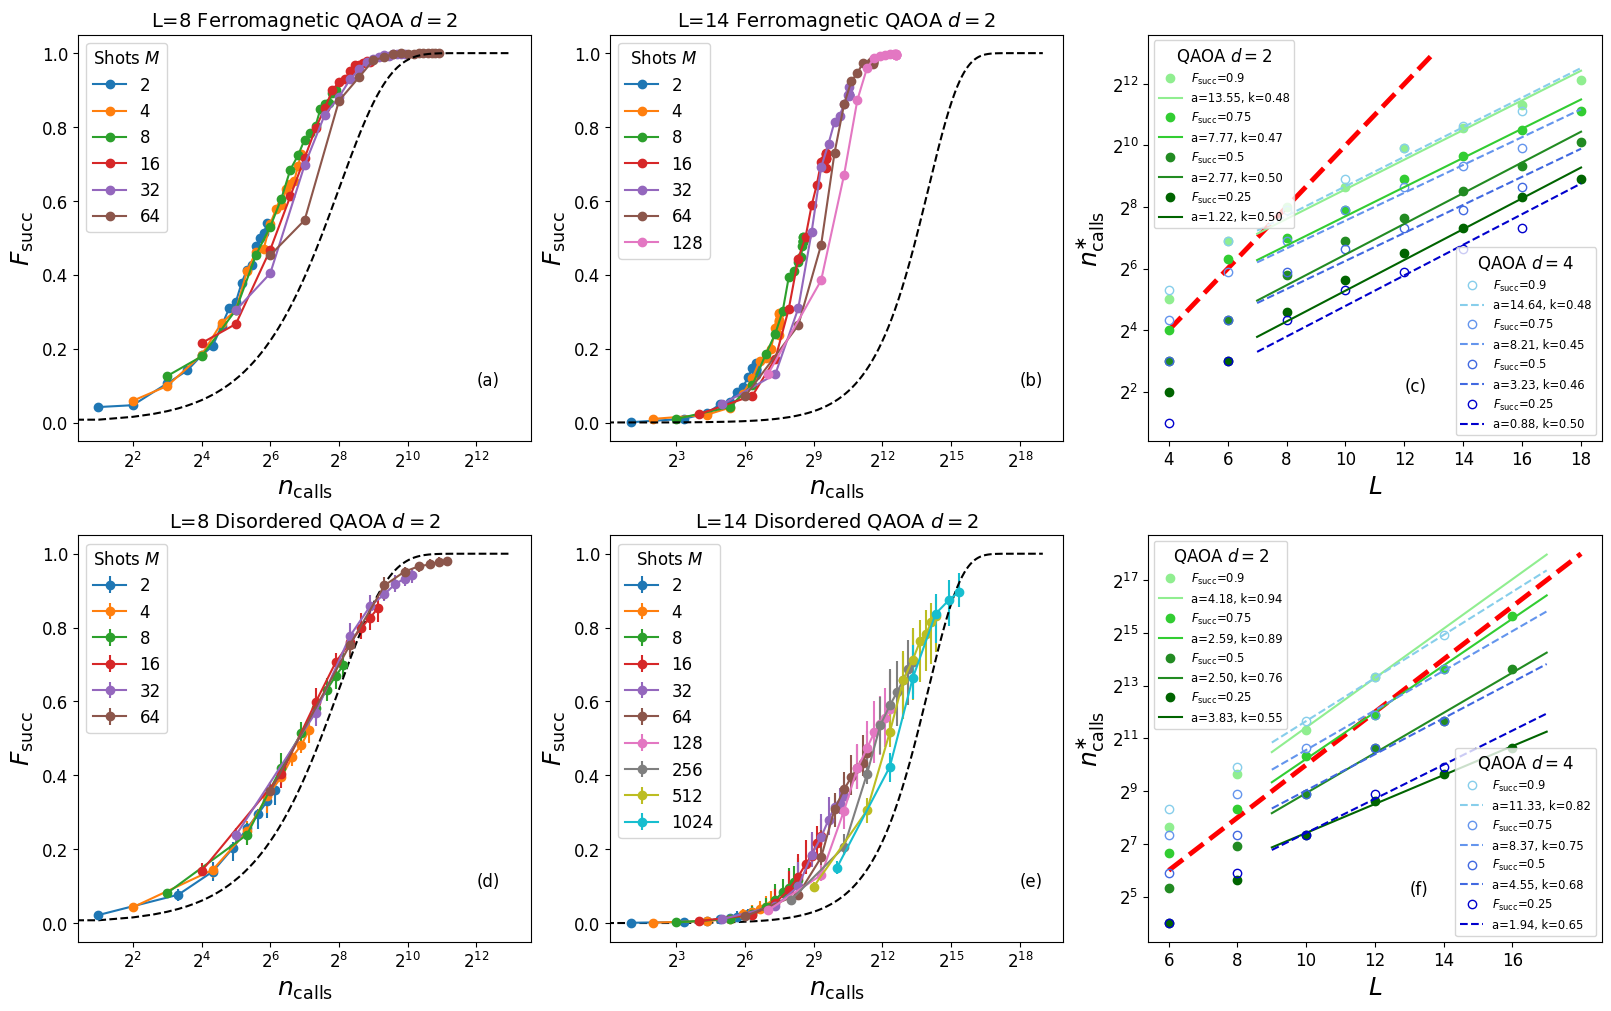

In [41]:
# import matplotlib

# matplotlib.rcParams["font.size"] = 12

SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

def fun_exp(x, a, b):
    return a*2**(b*x)

def fun_lin(x, a, b):
    return a + b*x

fig = plt.figure(constrained_layout=True, figsize=(16,10))
subplots = fig.subplots(2,3)

for i, subplot in enumerate(subplots.ravel()):
    if i == 0:
        qubits = 8
        depth = 2
        max_shots = 128
        for shot, data in ferro_df[(ferro_df['algo'] == 'qaoa') & (ferro_df['circ_depth'] == depth) & (ferro_df['qubits'] == qubits) & (ferro_df['shots'] < max_shots)].groupby('shots'):
            x_axes = data['t'] #*dat[dat['seed'] == 1]["circ_depth"]
            y_axes = data['p_succ']
            subplot.plot(x_axes, y_axes, "-o", label=f"{shot}")

        subplot.plot(np.arange(0,2**(5+qubits),2), 1 - (1-1/(2**qubits))**np.arange(0,2**(5+qubits),2), '--', color="black")
        subplot.set_xscale("log", base=2)

        subplot.set_xlabel(r"$n_{\mathrm{calls}}$")
        subplot.set_ylabel(r"$F_{\mathrm{succ}}$")

        subplot.set_title(f"L={qubits} Ferromagnetic " + r"QAOA $d=$" + f"{depth}", fontsize=14)
        subplot.legend(title=r'Shots $M$', loc="upper left")
        subplot.text(2**12, 0.1, "(a)")

    if i == 1:
        qubits = 14
        depth = 2
        for shot, data in ferro_df[(ferro_df['algo'] == 'qaoa') & (ferro_df['circ_depth'] == depth) & (ferro_df['qubits'] == qubits)].groupby('shots'):
            x_axes = data['t'] #*dat[dat['seed'] == 1]["circ_depth"]
            y_axes = data['p_succ']
            subplot.plot(x_axes, y_axes, "-o", label=f"{shot}")

        subplot.plot(np.arange(0,2**(5+qubits),2), 1 - (1-1/(2**qubits))**np.arange(0,2**(5+qubits),2), '--', color="black")
        subplot.set_xscale("log", base=2)

        subplot.set_xlabel(r"$n_{\mathrm{calls}}$")
        subplot.set_ylabel(r"$F_{\mathrm{succ}}$")

        subplot.set_title(f"L={qubits} Ferromagnetic " + r"QAOA $d=$" + f"{depth}", fontsize=14)
        subplot.legend(title=r'Shots $M$')
        subplot.text(2**18, 0.1, '(b)')

    if i == 2:
        min_qubits, max_qubits = 4, 18
        min_qubits_toplot, max_qubits_toplot = 7, 19
        qubits_toplot = np.arange(min_qubits_toplot, max_qubits_toplot)
        
        depth1 = 2
        depth2 = 4
        plots1, plots2 =[], []

        subplot.plot(np.arange(min_qubits, max_qubits-4), fun_exp(np.arange(min_qubits, max_qubits-4), 1, 1), color='red', linewidth=3.5, linestyle="dashed")

        p_tresholds = [0.9, 0.75, 0.5, 0.25]
        colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
        for j, (p, color) in enumerate(zip(p_tresholds, colors)):
            data1 = ferro_df[(ferro_df['algo'] == 'qaoa') & (ferro_df['circ_depth'] == depth1)]
            data2 = ferro_df[(ferro_df['algo'] == 'qaoa') & (ferro_df['circ_depth'] == depth2)]
    
            gt_p1 = data1[data1['p_succ'] > p].groupby('qubits', as_index=False)['t'].min()
            gt_p2 = data2[data2['p_succ'] > p].groupby('qubits', as_index=False)['t'].min()
            
            popt1, _ = optimize.curve_fit(fun_lin, gt_p1['qubits'], np.log2(gt_p1['t']))
            popt2, _ = optimize.curve_fit(fun_lin, gt_p2['qubits'], np.log2(gt_p2['t']))

            plot1, = subplot.plot(gt_p1['qubits'], gt_p1['t'], "o", label=r"$F_{\mathrm{succ}}$"+f"={p}", color=color)
            plots1.append(plot1)
            plot2, = subplot.plot(gt_p2['qubits'], gt_p2['t'], "o", label=r"$F_{\mathrm{succ}}$"+f"={p}", color=colors[j+5], fillstyle='none')
            plots2.append(plot2)

            plot1,  = subplot.plot(qubits_toplot, fun_exp(qubits_toplot, 2**popt1[0], popt1[1]), "-", label=f"a={2**popt1[0]:.2f}, k={popt1[1]:.2f}", color=color)
            plot2, = subplot.plot(qubits_toplot, fun_exp(qubits_toplot, 2**popt2[0], popt2[1]), "--", label=f"a={2**popt2[0]:.2f}, k={popt2[1]:.2f}", color=colors[j+5])
            plots1.append(plot1)
            plots2.append(plot2)

        subplot.set_yscale('log', base=2)
        subplot.set_ylabel(r"$n^{\ast}_{\mathrm{calls}}$")
        subplot.set_xlabel(r"$L$")
        subplot.set_xticks(np.arange(min_qubits, max_qubits+1, 2))

        first_legend = subplot.legend(handles=plots1, title=r"QAOA $d=$"+f"{depth1}", loc='upper left', fontsize="x-small")
        subplot.add_artist(first_legend)

        subplot.legend(handles=plots2, loc='lower right', title=r"QAOA $d=$"+f"{depth2}", fontsize="x-small")

        #subplot.set_title(r"Scaling and fit with $a \cdot 2^{kL}$", fontsize=14)
       
        subplot.text(12, 2**2, '(c)')

    if i == 3:
        depth = 2
        qubits = 8
        for shot, data in spinglass_df[(spinglass_df['algo'] == 'qaoa') & (spinglass_df['circ_depth'] == depth) & (spinglass_df['qubits'] == qubits)].groupby('shots'):
            x_axes = data[data['seed'] == 1]['t'] #*dat[dat['seed'] == 1]["circ_depth"]
            y_axes = data.groupby(['iter'])['p_succ'].median()
            error = [
                (data.groupby(['iter'])['p_succ'].median() - data.groupby(['iter'])['p_succ'].quantile(0.25)).tolist(),
                (data.groupby(['iter'])['p_succ'].quantile(0.75) - data.groupby(['iter'])['p_succ'].median()).tolist(),
                ]
            subplot.errorbar(x_axes, y_axes, yerr=error, marker="o", label=f"{shot}")
            #subplot.fill_between(x_axes, data.groupby(['iter'])['p_succ'].quantile(0.95), data.groupby(['iter'])['p_succ'].quantile(0.05), alpha=0.3)

        subplot.plot(np.arange(0,2**(5+qubits),2), 1 - (1-1/(2**qubits))**np.arange(0,2**(5+qubits),2), '--', color="black")
        subplot.set_xscale("log", base=2)

        subplot.set_xlabel(r"$n_{\mathrm{calls}}$")
        subplot.set_ylabel(r"$F_{\mathrm{succ}}$")

        subplot.set_title(f"L={qubits} Disordered " + r"QAOA $d=$" + f"{depth}", fontsize=14)
        subplot.legend(title=r'Shots $M$')

        subplot.text(2**12, 0.1, '(d)')

    if i == 4:
        qubits = 14
        depth = 2

        for shot, data in spinglass_df[(spinglass_df['algo'] == 'qaoa') & (spinglass_df['circ_depth'] == depth) & (spinglass_df['qubits'] == qubits)].groupby('shots'):
            x_axes = data[data['seed'] == 1]['t'] #*dat[dat['seed'] == 1]["circ_depth"]
            y_axes = data.groupby(['iter'])['p_succ'].median()
            error = [
                (data.groupby(['iter'])['p_succ'].median() - data.groupby(['iter'])['p_succ'].quantile(0.25)).tolist(),
                (data.groupby(['iter'])['p_succ'].quantile(0.75) - data.groupby(['iter'])['p_succ'].median()).tolist(),
                ]
            subplot.errorbar(x_axes, y_axes, yerr=error, marker="o", label=f"{shot}")
            #subplot.fill_between(x_axes, data.groupby(['iter'])['p_succ'].quantile(0.95), data.groupby(['iter'])['p_succ'].quantile(0.05), alpha=0.3)

        subplot.plot(np.arange(0,2**(5+qubits),2), 1 - (1-1/(2**qubits))**np.arange(0,2**(5+qubits),2), '--', color="black")
        subplot.set_xscale("log", base=2)

        subplot.set_xlabel(r"$n_{\mathrm{calls}}$")
        subplot.set_ylabel(r"$F_{\mathrm{succ}}$")

        subplot.set_title(f"L={qubits} Disordered " + r"QAOA $d=$" + f"{depth}", fontsize=14)
        subplot.legend(title=r'Shots $M$')

        subplot.text(2**18, 0.1, '(e)')

    if i == 5:
        min_qubits, max_qubits = 6, 16
        min_qubits_toplot, max_qubits_toplot = 9, 18
        qubits_toplot = np.arange(min_qubits_toplot, max_qubits_toplot)

        depth1 = 2
        depth2 = 4
        plots1, plots2 = [], []
        
        subplot.plot(np.arange(min_qubits, max_qubits_toplot+1), fun_exp(np.arange(min_qubits, max_qubits_toplot+1), 1, 1), color='red', linewidth=3.5, linestyle="dashed")

        p_tresholds = [0.9, 0.75, 0.5, 0.25]
        colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
        for j, (p, color) in enumerate(zip(p_tresholds, colors)):
            median_for_seed1 = spinglass_df[(spinglass_df['algo'] == 'qaoa') & (spinglass_df['circ_depth'] == depth1) & (spinglass_df['qubits'] >= min_qubits) & (spinglass_df['qubits'] <= max_qubits)].groupby(['t', 'qubits', 'circ_depth'], as_index=False).agg(avg_p_succ = ("p_succ", "median"))
            median_for_seed2 = spinglass_df[(spinglass_df['algo'] == 'qaoa') & (spinglass_df['circ_depth'] == depth2) & (spinglass_df['qubits'] >= min_qubits)].groupby(['t', 'qubits', 'circ_depth'], as_index=False).agg(avg_p_succ = ("p_succ", "median"))
            
            gt_p1 = median_for_seed1[median_for_seed1['avg_p_succ'] > p].groupby('qubits', as_index=False)['t'].min()
            gt_p2 = median_for_seed2[median_for_seed2['avg_p_succ'] > p].groupby('qubits', as_index=False)['t'].min()

            popt1, _ = optimize.curve_fit(fun_lin, gt_p1['qubits'][-4:], np.log2(gt_p1['t'][-4:]))
            plot1, = subplot.plot(gt_p1['qubits'], gt_p1['t'], "o", label=r"$F_{\mathrm{succ}}$"+f"={p}", color=color)
            plots1.append(plot1)
            plot1, = subplot.plot(qubits_toplot, fun_exp(qubits_toplot, 2**popt1[0], popt1[1]), "-", label=f"a={2**popt1[0]:.2f}, k={popt1[1]:.2f}", color=color)
            plots1.append(plot1)

            popt2, _ = optimize.curve_fit(fun_lin, gt_p2['qubits'][-3:], np.log2(gt_p2['t'][-3:]))
            plot2, = subplot.plot(gt_p2['qubits'], gt_p2['t'], "o", label=r"$F_{\mathrm{succ}}$"+f"={p}", fillstyle='none', color=colors[j+5])
            plots2.append(plot2)
            plot2, = subplot.plot(qubits_toplot, fun_exp(qubits_toplot, 2**popt2[0], popt2[1]), "--", label=f"a={2**popt2[0]:.2f}, k={popt2[1]:.2f}", color=colors[j+5])
            plots2.append(plot2)

        subplot.set_yscale('log', base=2)
        subplot.set_ylabel(r"$n^{\ast}_{\mathrm{calls}}$")
        subplot.set_xlabel(r"$L$")
        subplot.set_xticks(np.arange(min_qubits, max_qubits+1, 2))

        first_legend = subplot.legend(handles=plots1, title=r"QAOA $d=$"+f"{depth1}", loc='upper left', fontsize="x-small")
        subplot.add_artist(first_legend)

        subplot.legend(handles=plots2, loc='lower right', title=r"QAOA $d=$"+f"{depth2}", fontsize="x-small")

        #subplot.set_title(r"Scaling and fit with $a \cdot 2^{kL}$", fontsize=14)
       
        subplot.text(13, 2**5.1, '(f)')

plt.savefig("img/fig4.png", dpi=200)


### Figure 1

In [42]:
noise_df = pd.read_csv("datanoise.csv", index_col=0)
noise_df.head()

t  shots  iter  p_succ  qubits  circ_depth algo  succ_true  succ_false  \
0   2      2     1   0.201       4           2  vqe        201         799   
1   4      2     2   0.300       4           2  vqe        300         700   
2   8      2     4   0.446       4           2  vqe        446         554   
3  12      2     6   0.513       4           2  vqe        513         487   
4  16      2     8   0.624       4           2  vqe        624         376   

   noise  
0   True  
1   True  
2   True  
3   True  
4   True

/tmp/ipykernel_394/2387304532.py:76: UserWarning: FixedFormatter should only be used together with FixedLocator
  inplot.set_xticklabels([r"$2.5 \cdot 10^4$", r"$10^5$", r"$2 \cdot 10^5$", r"$3 \cdot 10^5$"], fontsize="small")
/tmp/ipykernel_394/2387304532.py:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  inplot.set_yticklabels([0.75, 0.8, 0.9, 1.0], fontsize="small")


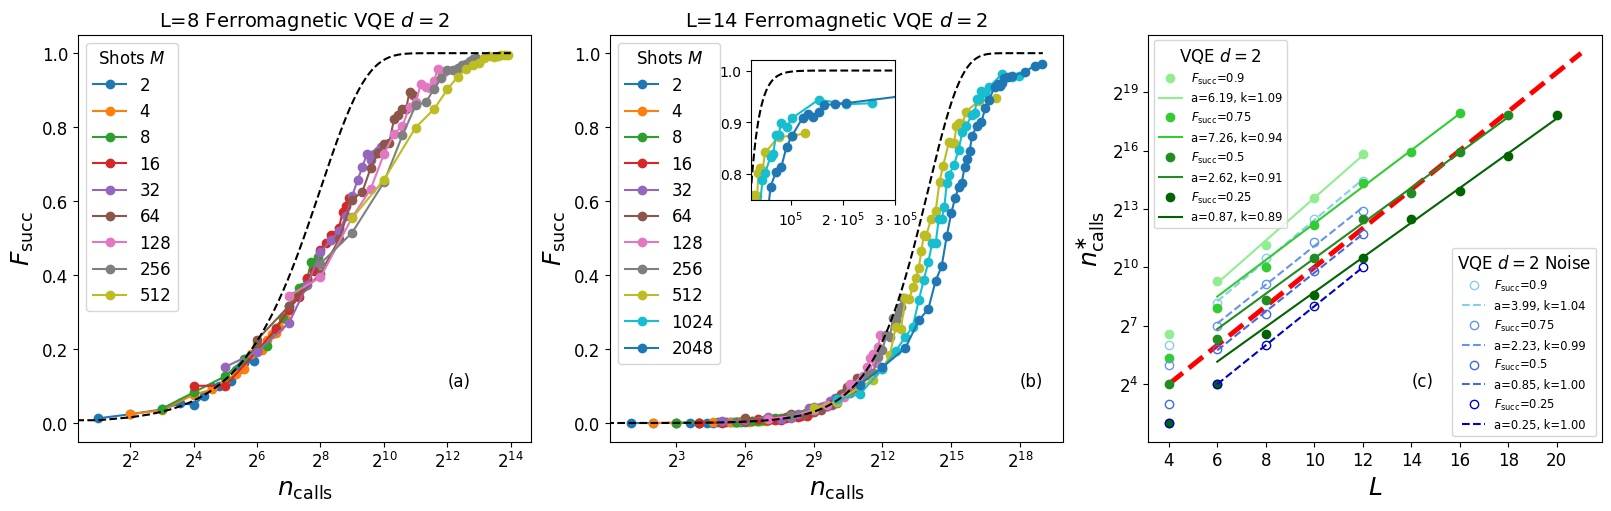

In [44]:
SMALL_SIZE = 8
MEDIUM_SIZE = 12
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title


def fun_exp(x, a, b):
    return a*2**(b*x)

def fun_lin(x, a, b):
    return a + b*x

fig = plt.figure(constrained_layout=True, figsize=(16,5))
subplots = fig.subplots(1,3)
plots1, plots2 = [], [] 

for i, subplot in enumerate(subplots.ravel()):
    if i == 0:
        qubits = 8
        depth = 2
        max_shots = 1024
        algo = 'vqe'
        for shot, data in ferro_df[(ferro_df['algo'] == algo) & (ferro_df['circ_depth'] == depth) & (ferro_df['qubits'] == qubits) & (ferro_df['shots'] < max_shots)].groupby('shots'):
            x_axes = data['t'] #*dat[dat['seed'] == 1]["circ_depth"]
            y_axes = data['p_succ']
            subplot.plot(x_axes, y_axes, "-o", label=f"{shot}")

        subplot.plot(np.arange(0,2**(6+qubits),2), 1 - (1-1/(2**qubits))**np.arange(0,2**(6+qubits),2), '--', color="black")
        subplot.set_xscale("log", base=2)

        subplot.set_xlabel(r"$n_{\mathrm{calls}}$")
        subplot.set_ylabel(r"$F_{\mathrm{succ}}$")

        subplot.set_title(f"L={qubits} Ferromagnetic " + r"VQE $d=$" + f"{depth}", fontsize=14)
        subplot.legend(title=r'Shots $M$')

        subplot.text(2**12, 0.1, '(a)')

    if i == 1:
        qubits = 14
        depth = 2
        algo = 'vqe'

        inplot = fig.add_axes([.466, .61, .09, .28])
        xmin, xmax = 25000,300000
        ymin, ymax = 0.75, 1.02

        for shot, data in ferro_df[(ferro_df['algo'] == algo) & (ferro_df['circ_depth'] == depth) & (ferro_df['qubits'] == qubits)].groupby('shots'):
            x_axes = data['t'] #*dat[dat['seed'] == 1]["circ_depth"]
            y_axes = data['p_succ']
            subplot.plot(x_axes, y_axes, "-o", label=f"{shot}")
            inplot.plot(x_axes, y_axes, "-o")


        subplot.plot(np.arange(0,2**(5+qubits),2), 1 - (1-1/(2**qubits))**np.arange(0,2**(5+qubits),2), '--', color="black")
        subplot.set_xscale("log", base=2)

        subplot.set_xlabel(r"$n_{\mathrm{calls}}$")
        subplot.set_ylabel(r"$F_{\mathrm{succ}}$")

        subplot.set_title(f"L={qubits} Ferromagnetic " + r"VQE $d=$" + f"{depth}", fontsize=14)
        subplot.legend(title=r'Shots $M$')
        
        inplot.plot(np.arange(0,2**(5+qubits),2), 1 - (1-1/(2**qubits))**np.arange(0,2**(5+qubits),2), '--', color="black")

        inplot.set_xlim(xmin, xmax)
        inplot.set_ylim(ymin, ymax)

        inplot.set_xticklabels([r"$2.5 \cdot 10^4$", r"$10^5$", r"$2 \cdot 10^5$", r"$3 \cdot 10^5$"], fontsize="small")
        inplot.set_yticklabels([0.75, 0.8, 0.9, 1.0], fontsize="small")
        inplot.tick_params(  
            axis='both',   # changes apply to both axis
            which='both',      # both major and minor ticks are affected
            bottom=True,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            left = True,
            right=False,
            labelleft=True,
            labelbottom=True,
        )

        subplot.text(2**18, 0.1, '(b)')

    if i == 2:
        min_qubits, max_qubits = 4, 20
        min_qubits_toplot, max_qubits_toplot = 6, 22
        qubits_toplot = np.arange(min_qubits_toplot, max_qubits_toplot)

        depth1 = 2
        depth2 = 2

        maxiter = 40 
        
        subplot.plot(np.arange(min_qubits, max_qubits_toplot), fun_exp(np.arange(min_qubits, max_qubits_toplot), 1, 1), color='red', linewidth=3.5, linestyle="dashed")

        p_tresholds = [0.9, 0.75, 0.5, 0.25]
        colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
        for j, (p, color) in enumerate(zip(p_tresholds, colors)):
            data1 = ferro_df[(ferro_df['algo'] == 'vqe') & (ferro_df['circ_depth'] == depth1) & (ferro_df['qubits'] >= min_qubits) & (ferro_df['iter'] < maxiter)]
            data2 = noise_df[(noise_df['algo'] == 'vqe') & (noise_df['circ_depth'] == depth2) & (noise_df['qubits'] >= min_qubits)]
            
            gt_p1 = data1[data1['p_succ'] > p].groupby('qubits', as_index=False)['t'].min()
            gt_p2 = data2[data2['p_succ'] > p].groupby('qubits', as_index=False)['t'].min()

            popt1, _ = optimize.curve_fit(fun_lin, gt_p1['qubits'][-4:], np.log2(gt_p1['t'][-4:]))
            plot1, = subplot.plot(gt_p1['qubits'], gt_p1['t'], "o", label=r"$F_{\mathrm{succ}}$"+f"={p}", color=color)
            plots1.append(plot1)
            plot1, = subplot.plot(gt_p1['qubits'][1:], fun_exp(gt_p1['qubits'][1:], 2**popt1[0], popt1[1]), "-", label=f"a={2**popt1[0]:.2f}, k={popt1[1]:.2f}", color=color)
            plots1.append(plot1)

            popt2, _ = optimize.curve_fit(fun_lin, gt_p2['qubits'][-4:], np.log2(gt_p2['t'][-4:]))
            plot2, = subplot.plot(gt_p2['qubits'], gt_p2['t'], "o", label=r"$F_{\mathrm{succ}}$"+f"={p}", fillstyle='none', color=colors[j+5])
            plots2.append(plot2)
            plot2, = subplot.plot(gt_p2['qubits'][1:], fun_exp(gt_p2['qubits'][1:], 2**popt2[0], popt2[1]), "--", label=f"a={2**popt2[0]:.2f}, k={popt2[1]:.2f}", color=colors[j+5])
            plots2.append(plot2)

        subplot.set_yscale('log', base=2)
        subplot.set_ylabel(r"$n^{\ast}_{\mathrm{calls}}$")
        subplot.set_xlabel(r"$L$")
        subplot.set_xticks(np.arange(min_qubits, max_qubits+1, 2))

        first_legend = subplot.legend(handles=plots1, title=r"VQE $d=$"+f"{depth1}", loc='upper left', fontsize="x-small")
        ax = subplot.add_artist(first_legend)

        subplot.legend(handles=plots2, loc='lower right', title=r"VQE $d=$"+f"{depth2} Noise", fontsize="x-small")

        #subplot.set_title(r"Scaling and fit with $a \cdot 2^{kL}$", fontsize=14)

        subplot.text(14, 2**3.9, '(c)')

plt.savefig("img/fig1.png", dpi=200)


### Inplot


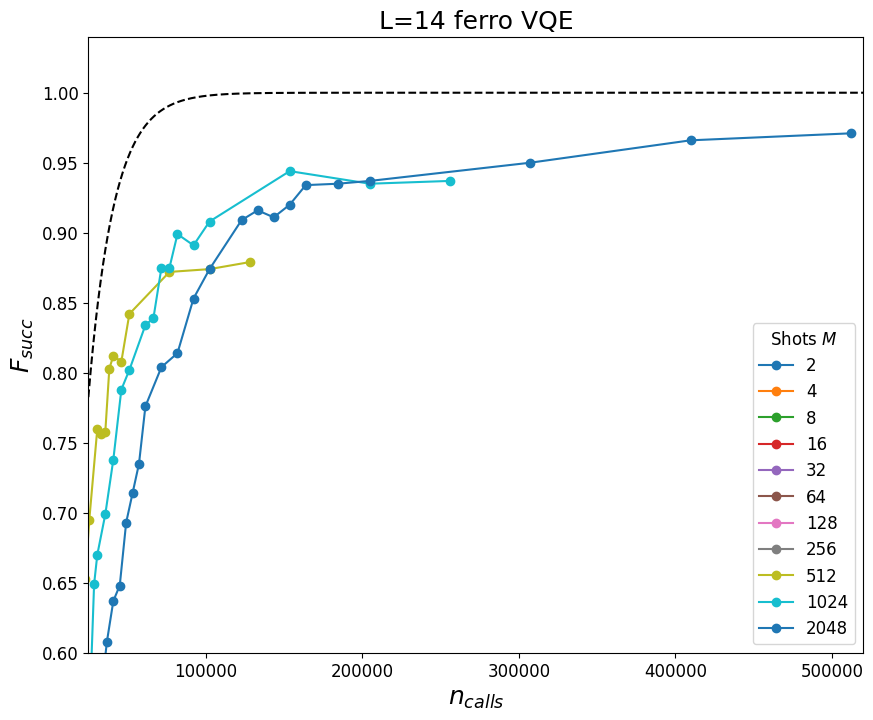

In [33]:
fig, ax = plt.subplots(figsize=(10,8))

qubits = 14
depth = 2
algo = 'vqe'
#xmin, xmax = 2**6, 2**10
xmin, xmax = 25000,520000
ymin, ymax = 0.6, 1.04

for shot, data in ferro_df[(ferro_df['algo'] == algo) & (ferro_df['circ_depth'] == depth) & (ferro_df['qubits'] == qubits)].groupby('shots'):
    x_axes = data['t'] #*dat[dat['seed'] == 1]["circ_depth"]
    y_axes = data['p_succ']
    ax.plot(x_axes, y_axes, "-o", label=f"{shot}")

ax.plot(np.arange(0,2**(5+qubits),2), 1 - (1-1/(2**qubits))**np.arange(0,2**(5+qubits),2), '--', color="black")

ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_xlabel(r"$n_{calls}$")
ax.set_ylabel(r"$F_{succ}$")

ax.legend(title=r'Shots $M$')

ax.set_title(f"L={qubits} ferro VQE")

plt.savefig("img/inplot.png", dpi=300)


### Supplementary Material



#### Figure A1


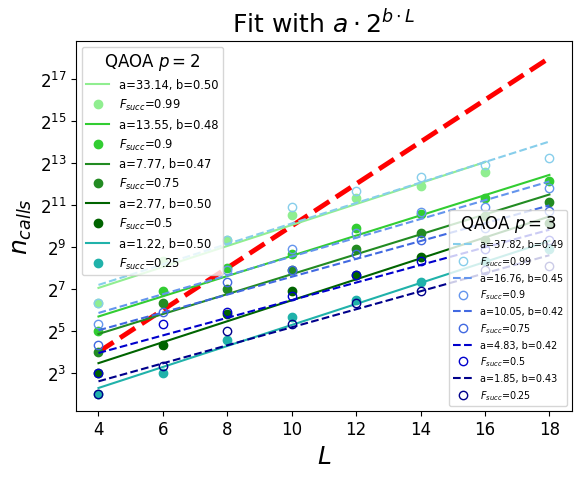

In [34]:
def fun_exp(x, a, b):
    return a*2**(b*x)

def fun_lin(x, a, b):
    return a + b*x

fig, ax = plt.subplots()

min_qubits, max_qubits = 4, 18
min_qubits_toplot, max_qubits_toplot = 4, 19
qubits_toplot = np.arange(min_qubits_toplot, max_qubits_toplot)

depth1 = 2
depth2 = 3

algo = 'qaoa' 

ax.plot(np.arange(min_qubits, max_qubits_toplot), fun_exp(np.arange(min_qubits, max_qubits_toplot), 1, 1), color='red', linewidth=3.5, linestyle="dashed")

plots1, plots2 = [], []

p_tresholds = [0.99, 0.9, 0.75, 0.5, 0.25]
colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
for j, (p, color) in enumerate(zip(p_tresholds, colors)):
    data1 = ferro_df[(ferro_df['algo'] == algo) & (ferro_df['circ_depth'] == depth1) & (ferro_df['qubits'] >= min_qubits)]
    data2 = ferro_df[(ferro_df['algo'] == algo) & (ferro_df['circ_depth'] == depth2) & (ferro_df['qubits'] >= min_qubits)]
    
    gt_p1 = data1[data1['p_succ'] > p].groupby('qubits', as_index=False)['t'].min()
    gt_p2 = data2[data2['p_succ'] > p].groupby('qubits', as_index=False)['t'].min()

    popt1, _ = optimize.curve_fit(fun_lin, gt_p1['qubits'], np.log2(gt_p1['t']))
    plot1, = ax.plot(gt_p1['qubits'], fun_exp(gt_p1['qubits'], 2**popt1[0], popt1[1]), "-", label=f"a={2**popt1[0]:.2f}, b={popt1[1]:.2f}", color=color)
    plots1.append(plot1)
    plot1, = ax.plot(gt_p1['qubits'], gt_p1['t'], "o", label=r"$F_{succ}$"+f"={p}", color=color)
    plots1.append(plot1)

    popt2, _ = optimize.curve_fit(fun_lin, gt_p2['qubits'], np.log2(gt_p2['t']))
    plot2, = ax.plot(gt_p2['qubits'], fun_exp(gt_p2['qubits'], 2**popt2[0], popt2[1]), "--", label=f"a={2**popt2[0]:.2f}, b={popt2[1]:.2f}", color=colors[j+5])
    plots2.append(plot2)
    plot2, = ax.plot(gt_p2['qubits'], gt_p2['t'], "o", label=r"$F_{succ}$"+f"={p}", fillstyle='none', color=colors[j+5])
    plots2.append(plot2)

ax.set_yscale('log', base=2)
ax.set_ylabel(r"$n_{calls}$")
ax.set_xlabel(r"$L$")
ax.set_xticks(np.arange(min_qubits, max_qubits+1, 2))

first_legend = ax.legend(handles=plots1, title=r"QAOA $p=$"+f"{depth1}", loc='upper left', fontsize="x-small")
ax1 = plt.gca().add_artist(first_legend)
ax.legend(handles=plots2, loc='lower right', title=r"QAOA $p=$"+f"{depth2}", fontsize="xx-small")

ax.set_title(r"Fit with $a \cdot 2^{b \cdot L}$")

L=plt.savefig("img/scalingferrop4.png", dpi=300)


#### Figure A2

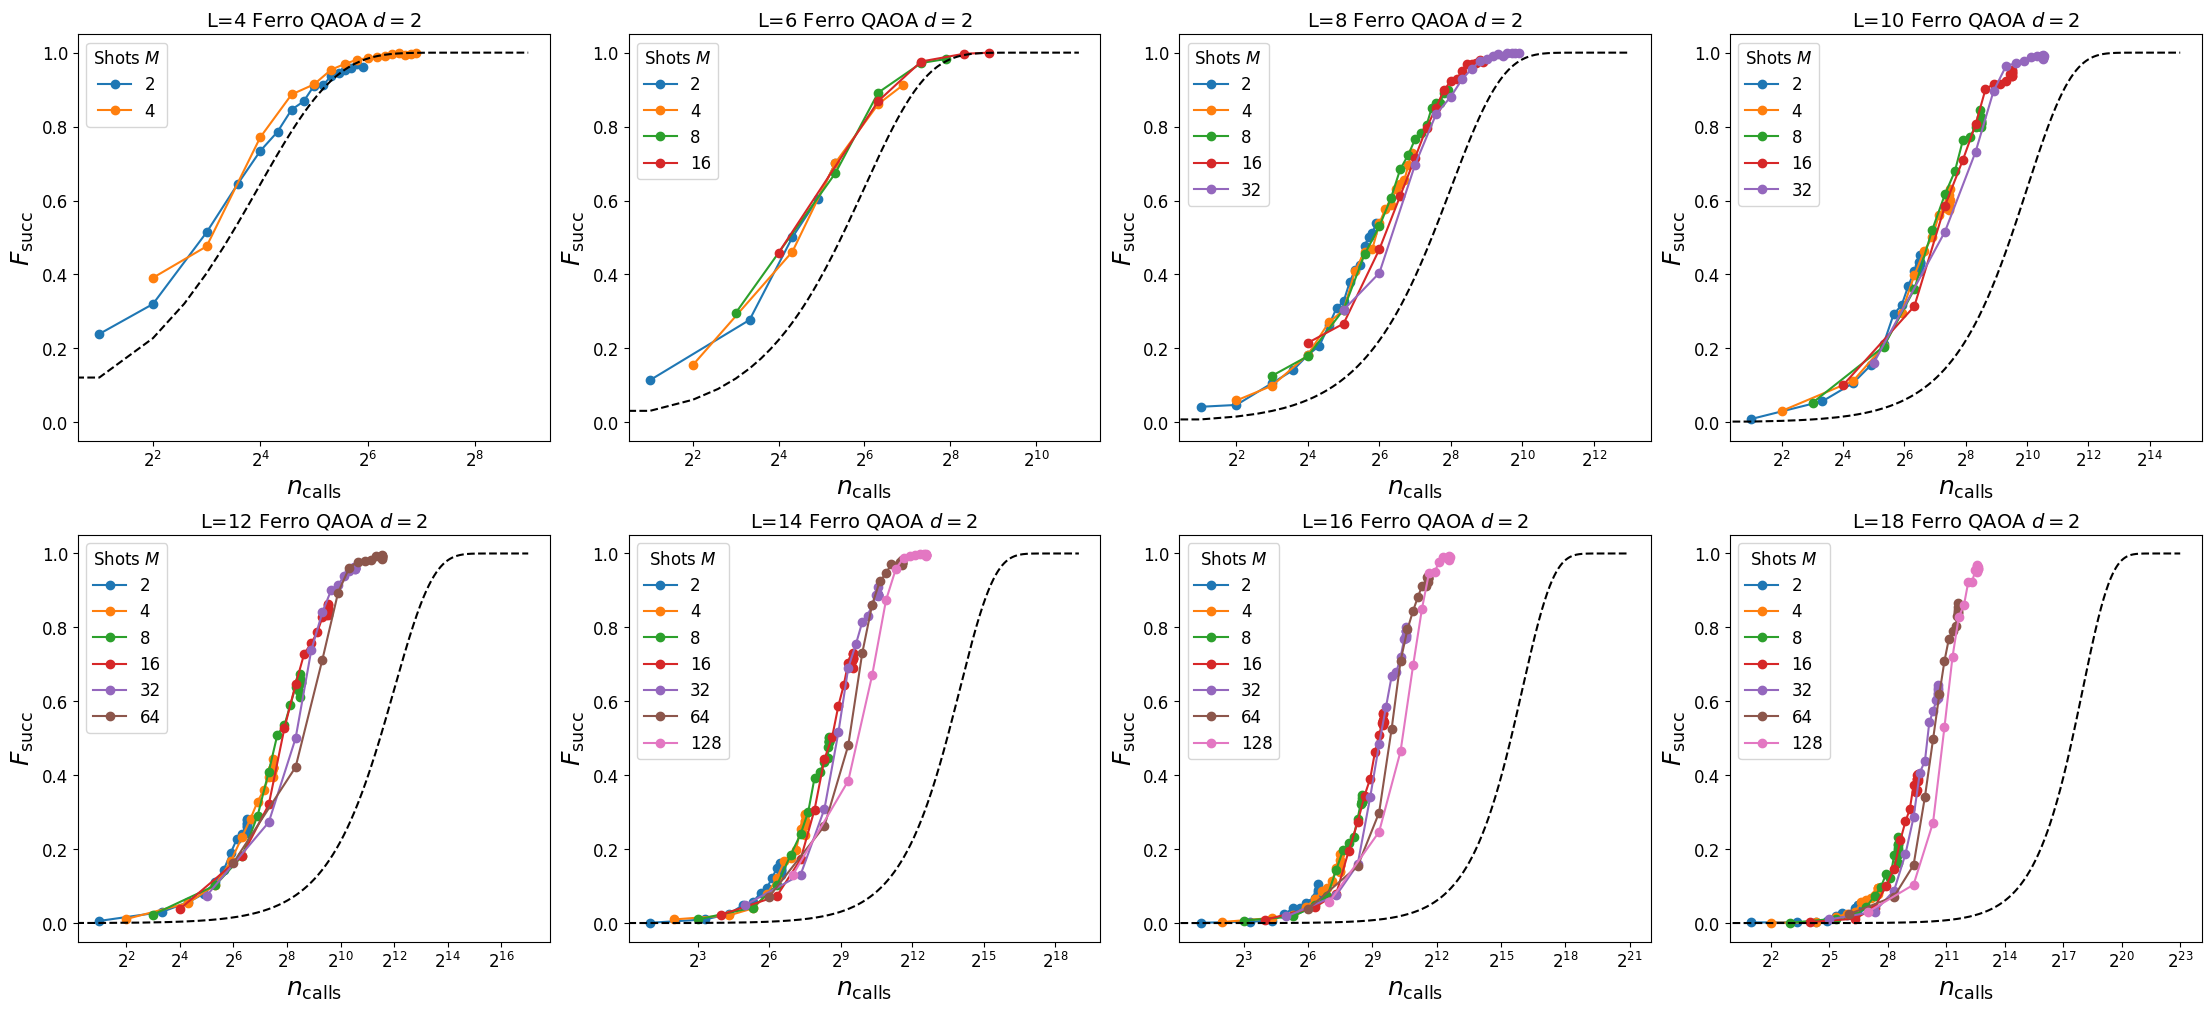

In [35]:
depth = 2
algo = 'qaoa'
max_size = 18

fig = plt.figure(constrained_layout=True, figsize=(22,10))
subplots = fig.subplots(2,4)
for (qubits, data), subplot in zip(ferro_df[(ferro_df['algo'] == algo) & (ferro_df['circ_depth'] == depth) & (ferro_df['qubits'] <= max_size)].groupby('qubits'), subplots.ravel()):
    for shot, dat in data.groupby('shots'):
        if ((qubits==4) & (shot > 4)):
            continue 
        if ((qubits==8) & (shot > 32)):
            continue
        # if ((qubits==10) & (shot > 1024)):
        #     continue 
        # if ((qubits==16) & (shot < 16)):
        #     continue 
        # if ((qubits==18) & (shot < 32)):
        #     continue 


        x_axes = dat['t']#*dat[dat['seed'] == 1]["circ_depth"]
        y_axes = dat['p_succ']

        subplot.plot(x_axes, y_axes, marker="o", label=f"{shot}")
        #subplot.fill_between(x_axes, dat.groupby(['iter'])['p_succ'].quantile(0.95), dat.groupby(['iter'])['p_succ'].quantile(0.05), alpha=0.3)

    subplot.plot(np.arange(0,2**(5+qubits),2), 1 - (1-1/(2**qubits))**np.arange(0,2**(5+qubits),2), '--', color="black")
    subplot.set_xscale("log", base=2)
    
    subplot.set_xlabel(r"$n_{\mathrm{calls}}$")
    subplot.set_ylabel(r"$F_{\mathrm{succ}}$")

    subplot.set_title(f"L={qubits} Ferro " + r"QAOA $d=$" + f"{depth}", fontsize=14)
    subplot.legend(title=r'Shots $M$')

plt.savefig('img/QAOAsupp.png', dpi=300)


#### Figure A3


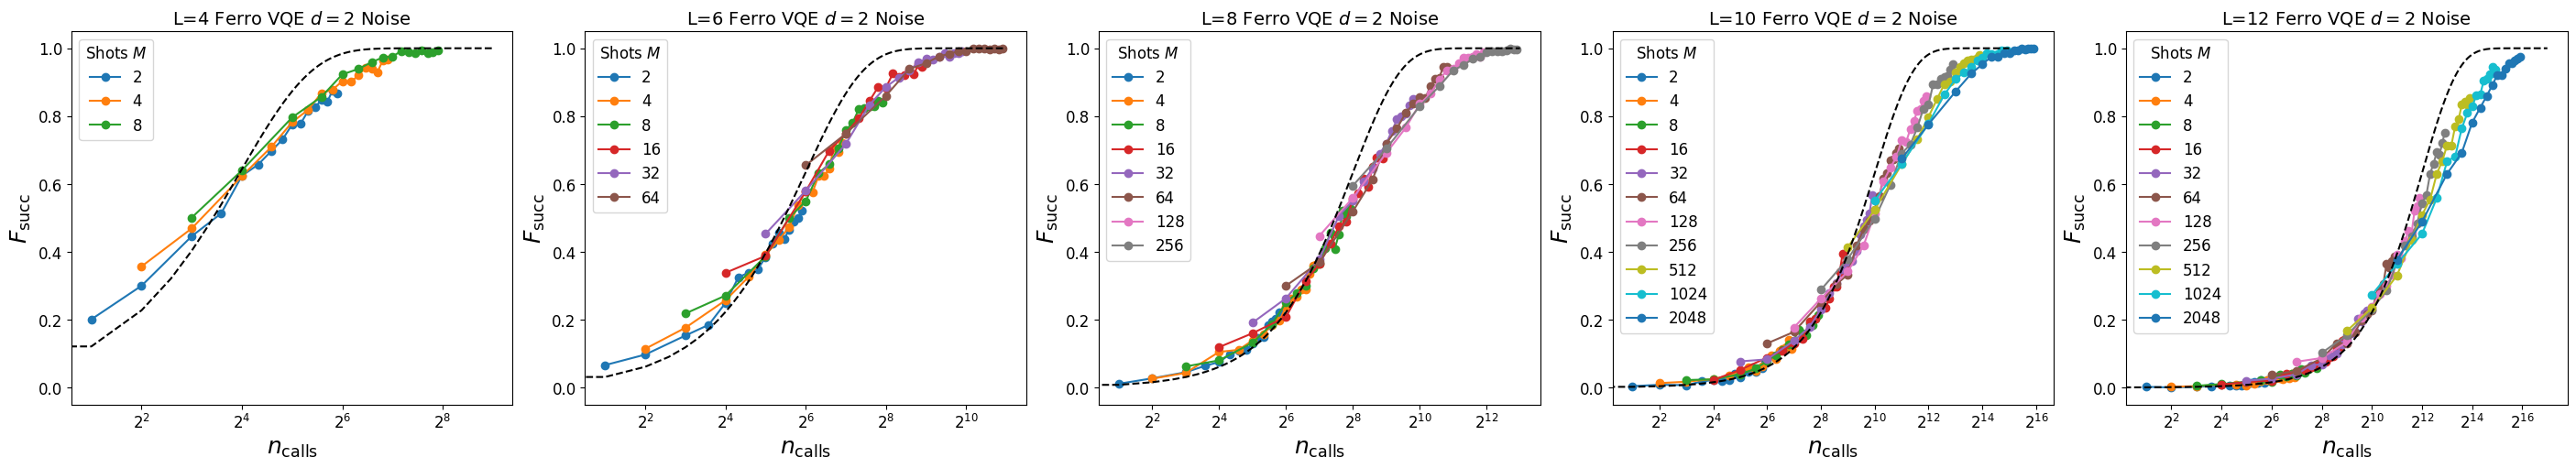

In [36]:
depth = 2
algo = 'vqe'
max_size = 18

fig = plt.figure(constrained_layout=True, figsize=(28,5))
subplots = fig.subplots(1,5)
for (qubits, data), subplot in zip(noise_df[(noise_df['algo'] == algo) & (noise_df['circ_depth'] == depth) & (noise_df['circ_depth'] <= max_size)].groupby('qubits'), subplots.ravel()):
    for shot, dat in data.groupby('shots'):
        if ((qubits==4) & (shot > 8)):
            continue 
        if ((qubits==6) & (shot > 64)):
            continue
        if ((qubits==8) & (shot > 256)):
            continue
        # if ((qubits==10) & (shot > 1024)):
        #     continue 
        # if ((qubits==16) & (shot < 16)):
        #     continue 
        # if ((qubits==18) & (shot < 32)):
        #     continue 


        x_axes = dat['t']#*dat[dat['seed'] == 1]["circ_depth"]
        y_axes = dat['p_succ']

        subplot.plot(x_axes, y_axes, marker="o", label=f"{shot}")
        #subplot.fill_between(x_axes, dat.groupby(['iter'])['p_succ'].quantile(0.95), dat.groupby(['iter'])['p_succ'].quantile(0.05), alpha=0.3)

    subplot.plot(np.arange(0,2**(5+qubits),2), 1 - (1-1/(2**qubits))**np.arange(0,2**(5+qubits),2), '--', color="black")
    subplot.set_xscale("log", base=2)
    
    subplot.set_xlabel(r"$n_{\mathrm{calls}}$")
    subplot.set_ylabel(r"$F_{\mathrm{succ}}$")

    subplot.set_title(f"L={qubits} Ferro " + r"VQE $d=$" + f"{depth} Noise", fontsize=14)
    subplot.legend(title=r'Shots $M$')

plt.savefig('img/VQENoisesupp.png', dpi=300)


#### Figure A4


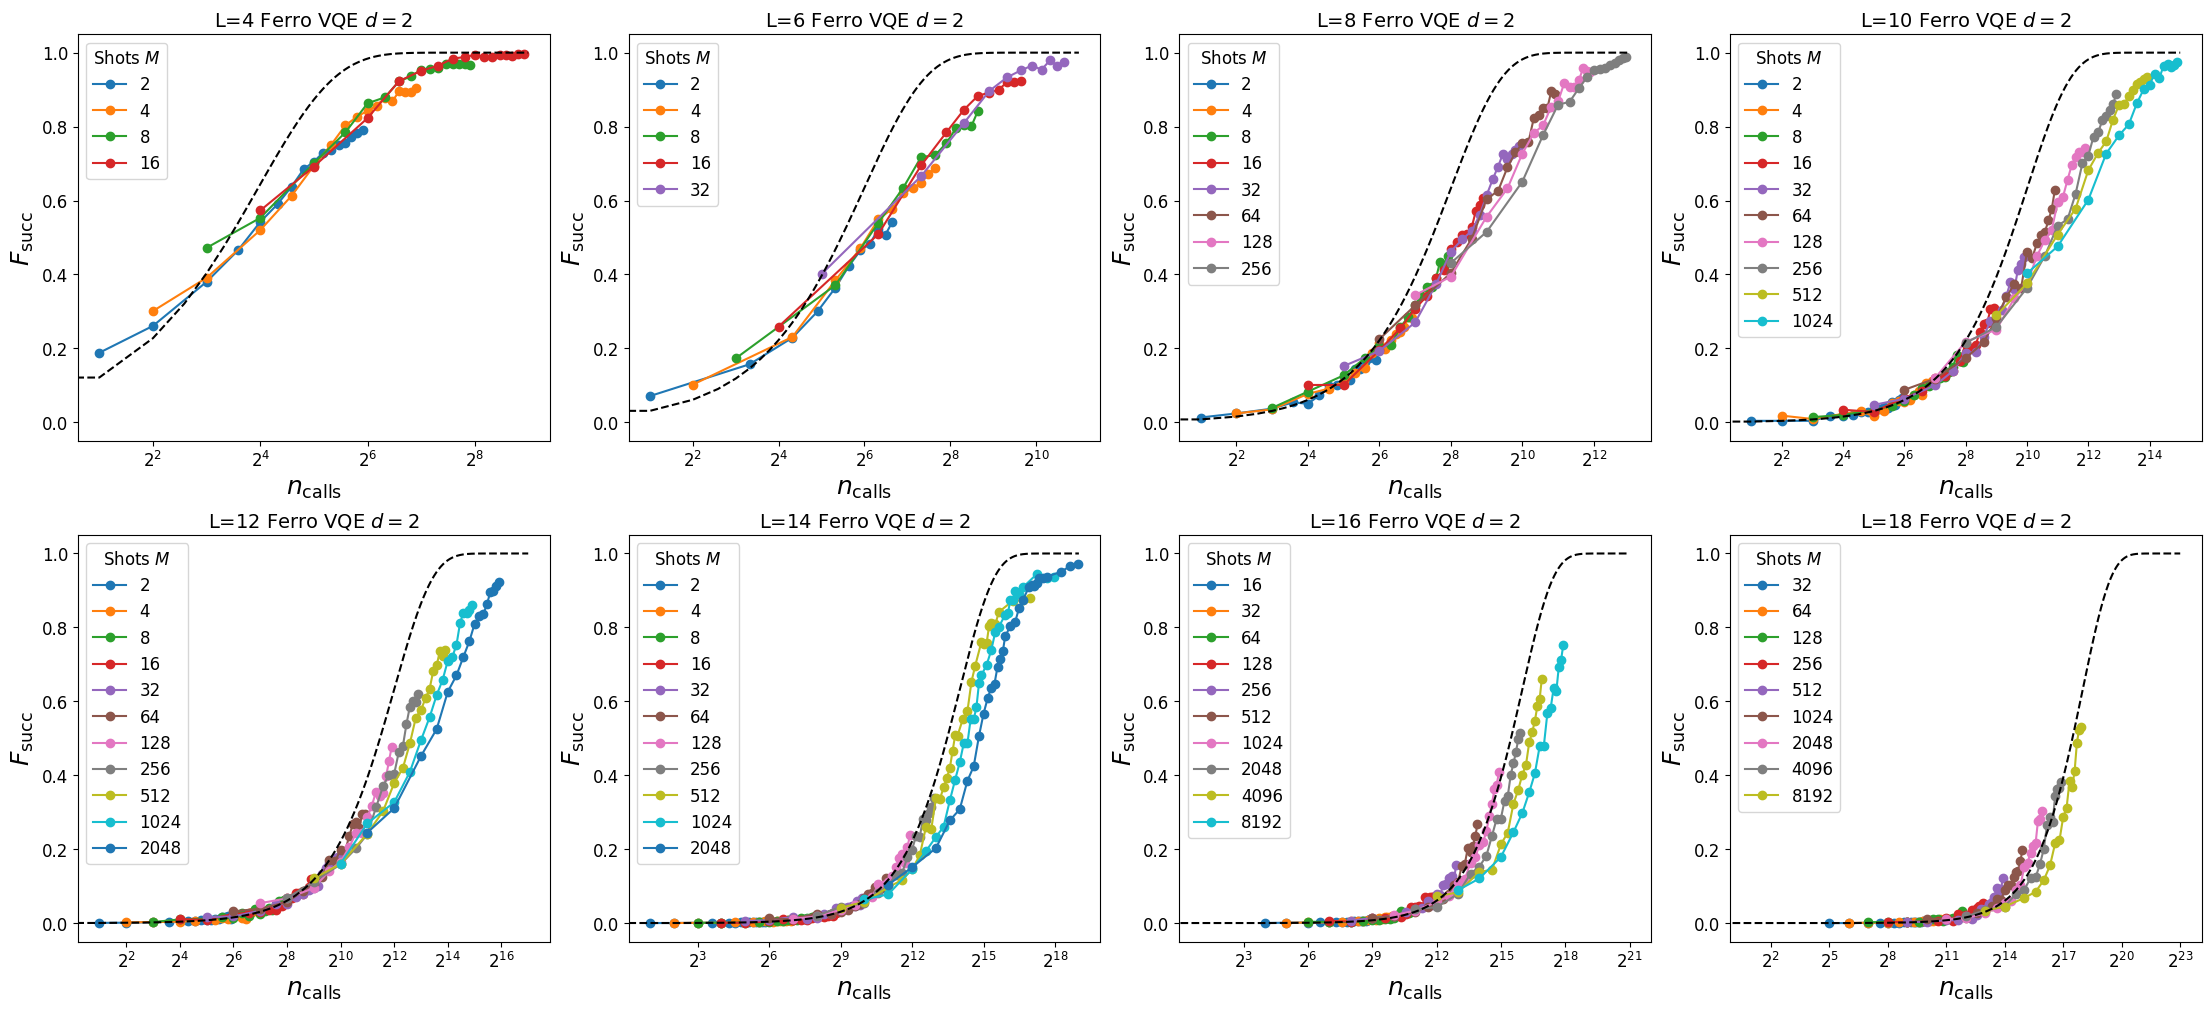

In [37]:
depth = 2
algo = 'vqe'
max_size = 18

fig = plt.figure(constrained_layout=True, figsize=(22,10))
subplots = fig.subplots(2,4)
for (qubits, data), subplot in zip(ferro_df[(ferro_df['algo'] == algo) & (ferro_df['circ_depth'] == depth) & (ferro_df['qubits'] <= max_size)].groupby('qubits'), subplots.ravel()):
    for shot, dat in data.groupby('shots'):
        if ((qubits==4) & (shot > 16)):
            continue 
        if ((qubits==8) & (shot > 256)):
            continue
        if ((qubits==10) & (shot > 1024)):
            continue 
        if ((qubits==16) & (shot < 16)):
            continue 
        if ((qubits==18) & (shot < 32)):
            continue 


        x_axes = dat['t']#*dat[dat['seed'] == 1]["circ_depth"]
        y_axes = dat['p_succ']

        subplot.plot(x_axes, y_axes, marker="o", label=f"{shot}")
        #subplot.fill_between(x_axes, dat.groupby(['iter'])['p_succ'].quantile(0.95), dat.groupby(['iter'])['p_succ'].quantile(0.05), alpha=0.3)

    subplot.plot(np.arange(0,2**(5+qubits),2), 1 - (1-1/(2**qubits))**np.arange(0,2**(5+qubits),2), '--', color="black")
    subplot.set_xscale("log", base=2)
    
    subplot.set_xlabel(r"$n_{\mathrm{calls}}$")
    subplot.set_ylabel(r"$F_{\mathrm{succ}}$")

    subplot.set_title(f"L={qubits} Ferro " + r"VQE $d=$" + f"{depth}", fontsize=14)
    subplot.legend(title=r'Shots $M$')

plt.savefig('img/VQEsupp.png', dpi=300)


#### Figure A3


/tmp/ipykernel_369/3920031309.py:27: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  popt1, _ = optimize.curve_fit(fun_lin,  data_final['qubits'][-4:], np.log2(data_final['p_succ_final'][-4:]))
/tmp/ipykernel_369/3920031309.py:33: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  popt1bis, _ = optimize.curve_fit(fun_lin,  data_final2['qubits'][-6:], np.log2(data_final2['p_succ_final'][-6:]))
/tmp/ipykernel_369/3920031309.py:36: FutureWarning: The behavior of `series[i:j]` with an integ

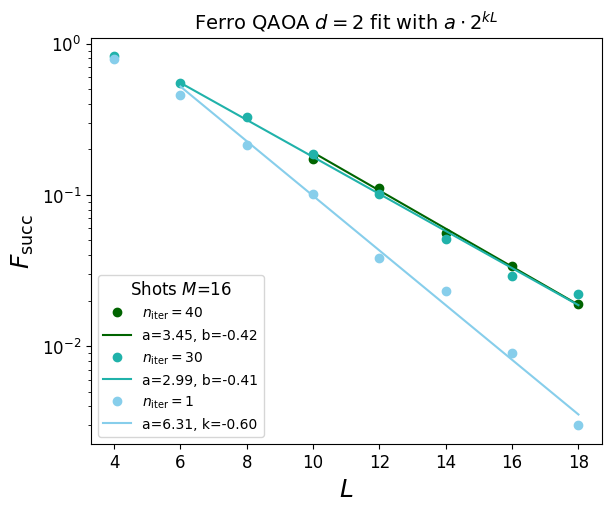

In [38]:
depth = 2
algo = 'qaoa'
max_size = 18
iter_final = 40
iter_final2 = 30

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(6,5))
#subplots = fig.subplots(2,4)

#for (iter, data), plt in zip(ferro_df[(ferro_df['algo'] == algo) & (ferro_df['circ_depth'] == depth) & (ferro_df['circ_depth'] <= max_size)].groupby('iter'), subplots.ravel()):
data = ferro_df[(ferro_df['algo'] == algo) & (ferro_df['circ_depth'] == depth) & ((ferro_df['iter'] == 1) | (ferro_df['iter'] == iter_final) | (ferro_df['iter'] == iter_final2))]
colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
for i, (shot, dat) in enumerate(data.groupby('shots')):
    if shot != 16:
        continue 

    data1 = dat[(dat['iter'] == 1)]
    #data_final = iter1_qaoa
    data_final = dat[(dat['iter'] == iter_final)]
    data_final2 = dat[(dat['iter'] == iter_final2)]



    # x_axes = dat['qubits']#*dat[dat['seed'] == 1]["circ_depth"]
    # y_axes = dat['p_succ']

    popt1, _ = optimize.curve_fit(fun_lin,  data_final['qubits'][-4:], np.log2(data_final['p_succ_final'][-4:]))
    plot1, = ax.plot(data_final['qubits'], data_final['p_succ_final'], "o", label=r"$n_{\mathrm{iter}} =$" + f"{iter_final}", color=colors[i])
    plots1.append(plot1)
    plot1, = ax.plot(data_final['qubits'], fun_exp(data_final['qubits'], 2**popt1[0], popt1[1]), "-", label=f"a={2**popt1[0]:.2f}, b={popt1[1]:.2f}", color=colors[i])
    plots1.append(plot1)

    popt1bis, _ = optimize.curve_fit(fun_lin,  data_final2['qubits'][-6:], np.log2(data_final2['p_succ_final'][-6:]))
    plot1, = ax.plot(data_final2['qubits'], data_final2['p_succ_final'], "o", label=r"$n_{\mathrm{iter}} =$" + f"{iter_final2}", color=colors[i+1])
    plots1.append(plot1)
    plot1, = ax.plot(data_final2['qubits'][1:], fun_exp(data_final2['qubits'][1:], 2**popt1bis[0], popt1bis[1]), "-", label=f"a={2**popt1bis[0]:.2f}, b={popt1bis[1]:.2f}", color=colors[i+1])
    plots1.append(plot1)

    popt2, _ = optimize.curve_fit(fun_lin, data1['qubits'][-6:], np.log2(data1['p_succ'][-6:]))
    plot2, = ax.plot(data1['qubits'], data1['p_succ'], "o", label=r"$n_{\mathrm{iter}} = 1$", color=colors[i+2])
    plots2.append(plot2)
    plot2, = ax.plot(data1['qubits'][1:], fun_exp(data1['qubits'][1:], 2**popt2[0], popt2[1]), "-", label=f"a={2**popt2[0]:.2f}, k={popt2[1]:.2f}", color=colors[i+2])
    plots2.append(plot2)

    #ax.plot(x_axes, y_axes, marker="o", label=f"{shot}")
    #subplot.fill_between(x_axes, data1.groupby(['iter'])['p_succ'].quantile(0.95), dat.groupby(['iter'])['p_succ'].quantile(0.05), alpha=0.3)

#ax.plot(np.arange(2, 20, 2), np.exp(-np.arange(2, 20, 2)), '--', color="black")
ax.set_yscale("log", base=10)

ax.set_xlabel(r"$L$")
ax.set_ylabel(r"$F_{\mathrm{succ}}$")

ax.set_title(f"Ferro " + r"QAOA $d=$" + f"{depth} fit with " + r"$a \cdot 2^{kL}$", fontsize=14)
ax.legend(title=r"Shots $M$"+f"=16", loc='lower left', fontsize='small')

plt.savefig('img/QAOA_scaling.png', dpi=300)

In [ ]:
iter1_qaoa = pd.read_csv("data_-pi_iter1.csv")
iter1_qaoa_initcorrect = pd.read_csv("data_0pi_iter1.csv")



depth = 2
algo = 'qaoa'
max_size = 18
iter_final = 40
iter_final2 = 30

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(6,5))
#subplots = fig.subplots(2,4)

#for (iter, data), plt in zip(ferro_df[(ferro_df['algo'] == algo) & (ferro_df['circ_depth'] == depth) & (ferro_df['circ_depth'] <= max_size)].groupby('iter'), subplots.ravel()):
data = ferro_df[(ferro_df['algo'] == algo) & (ferro_df['circ_depth'] == depth) & ((ferro_df['iter'] == 1) | (ferro_df['iter'] == iter_final) | (ferro_df['iter'] == iter_final2))]
colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
for i, (shot, dat) in enumerate(data.groupby('shots')):
    if shot != 16:
        continue 

    data1 = dat[(dat['iter'] == 1)]
    data_final = iter1_qaoa
    data_final2 = iter1_qaoa_initcorrect
    #data_final = dat[(dat['iter'] == iter_final)]
    #data_final2 = dat[(dat['iter'] == iter_final2)]



    # x_axes = dat['qubits']#*dat[dat['seed'] == 1]["circ_depth"]
    # y_axes = dat['p_succ']

    popt1, _ = optimize.curve_fit(fun_lin,  data_final['qubits'][2:], np.log2(data_final['p_succ_final'][2:]))
    plot1, = ax.plot(data_final['qubits'], data_final['p_succ_final'], "o", label="Correct QAOA", color=colors[i+1])
    plots1.append(plot1)
    plot1, = ax.plot(data_final['qubits'][1:], fun_exp(data_final['qubits'][1:], 2**popt1[0], popt1[1]), "-", label=f"a={2**popt1[0]:.2f}, b={popt1[1]:.2f}", color=colors[i+1])
    plots1.append(plot1)

    # popt1bis, _ = optimize.curve_fit(fun_lin,  data_final2['qubits'][-6:], np.log2(data_final2['p_succ_final'][-6:]))
    # plot1, = ax.plot(data_final2['qubits'], data_final2['p_succ_final'], "o", label="Correct QAOA " + r"$\theta \in [0,\pi]$", color=colors[i])
    # plots1.append(plot1)
    # plot1, = ax.plot(data_final2['qubits'], fun_exp(data_final2['qubits'], 2**popt1bis[0], popt1bis[1]), "-", label=f"a={2**popt1bis[0]:.2f}, b={popt1bis[1]:.2f}", color=colors[i])
    # plots1.append(plot1)

    popt2, _ = optimize.curve_fit(fun_lin, data1['qubits'][2:], np.log2(data1['p_succ'][2:]))
    plot2, = ax.plot(data1['qubits'], data1['p_succ'], "o", label="Wrong QAOA", color=colors[i+2])
    plots2.append(plot2)
    plot2, = ax.plot(data1['qubits'][1:], fun_exp(data1['qubits'][1:], 2**popt2[0], popt2[1]), "-", label=f"a={2**popt2[0]:.2f}, k={popt2[1]:.2f}", color=colors[i+2])
    plots2.append(plot2)

    #ax.plot(x_axes, y_axes, marker="o", label=f"{shot}")
    #subplot.fill_between(x_axes, data1.groupby(['iter'])['p_succ'].quantile(0.95), dat.groupby(['iter'])['p_succ'].quantile(0.05), alpha=0.3)

#ax.plot(np.arange(2, 20, 2), np.exp(-np.arange(2, 20, 2)), '--', color="black")
ax.set_yscale("log", base=10)

ax.set_xlabel(r"$L$")
ax.set_ylabel(r"$F_{\mathrm{succ}}$")

ax.set_title(f"Ferro " + r"QAOA $d=$" + f"{depth} fit with " + r"$a \cdot 2^{kL}$", fontsize=14)
ax.legend(title=r"Shots $M$"+f"=16", loc='lower left', fontsize='small')

plt.savefig('img/QAOA_iter1.png', dpi=300)



#### Figure A5

Linear initialization as in [Quantum annealing initialization of the quantum approximate optimization algorithm](http://arxiv.org/abs/2101.05742).

In [40]:
opt_qaoa = pd.read_csv("data-opt.csv", index_col=0)
opt_qaoa_2 = pd.read_csv("data-opt2.csv", index_col=0)

In [41]:
opt_qaoa_2.head()

t  shots  iter  p_succ  qubits  circ_depth  algo  succ_true  succ_false  \
0   2      2     1   0.822       4           2  qaoa        822         178   
1  10      2     5   0.823       4           2  qaoa        823         177   
2  20      2    10   0.951       4           2  qaoa        951          49   
3  30      2    15   0.982       4           2  qaoa        982          18   
4  40      2    20   0.990       4           2  qaoa        990          10   

   p_succ_final  
0         0.573  
1         0.502  
2         0.431  
3         0.439  
4         0.460

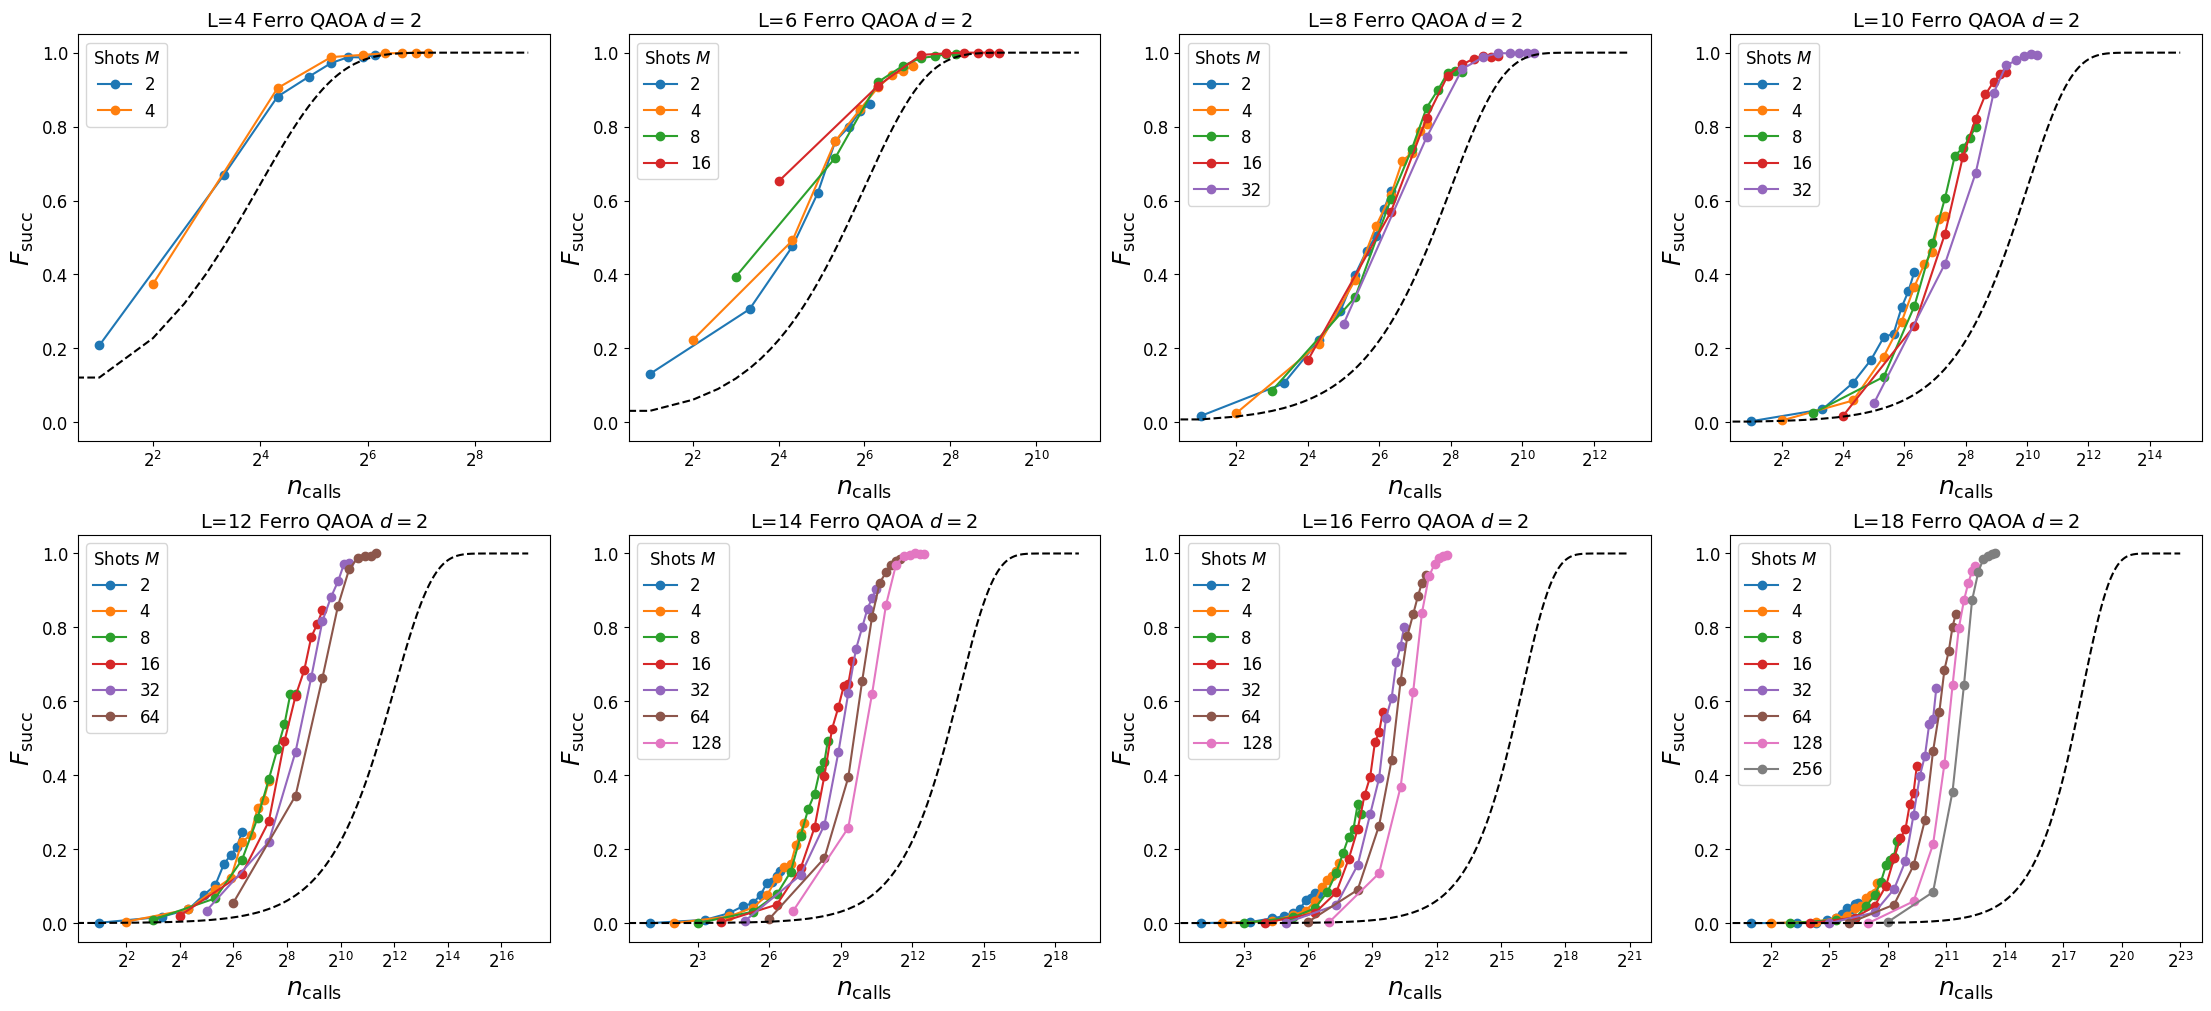

In [42]:
depth = 2
algo = 'qaoa'

fig = plt.figure(constrained_layout=True, figsize=(22,10))
subplots = fig.subplots(2,4)
for (qubits, data), subplot in zip(opt_qaoa[(opt_qaoa['algo'] == algo) & (opt_qaoa['circ_depth'] == depth)].groupby('qubits'), subplots.ravel()):
    for shot, dat in data.groupby('shots'):
        # if ((qubits==4) & (shot > 4)):
        #     continue 
        # if ((qubits==8) & (shot > 32)):
        #     continue
        # if ((qubits==10) & (shot > 1024)):
        #     continue 
        # if ((qubits==16) & (shot < 16)):
        #     continue 
        # if ((qubits==18) & (shot < 32)):
        #     continue 

        x_axes = dat['t']
        y_axes = dat['p_succ']

        subplot.plot(x_axes, y_axes, marker="o", label=f"{shot}")
        #subplot.fill_between(x_axes, dat.groupby(['iter'])['p_succ'].quantile(0.95), dat.groupby(['iter'])['p_succ'].quantile(0.05), alpha=0.3)

    subplot.plot(np.arange(0,2**(5+qubits),2), 1 - (1-1/(2**qubits))**np.arange(0,2**(5+qubits),2), '--', color="black")
    subplot.set_xscale("log", base=2)
    
    subplot.set_xlabel(r"$n_{\mathrm{calls}}$")
    subplot.set_ylabel(r"$F_{\mathrm{succ}}$")

    subplot.set_title(f"L={qubits} Ferro " + r"QAOA $d=$" + f"{depth}", fontsize=14)
    subplot.legend(title=r'Shots $M$')

plt.savefig('img/QAOA_opt.png', dpi=300)


#### Figure A6


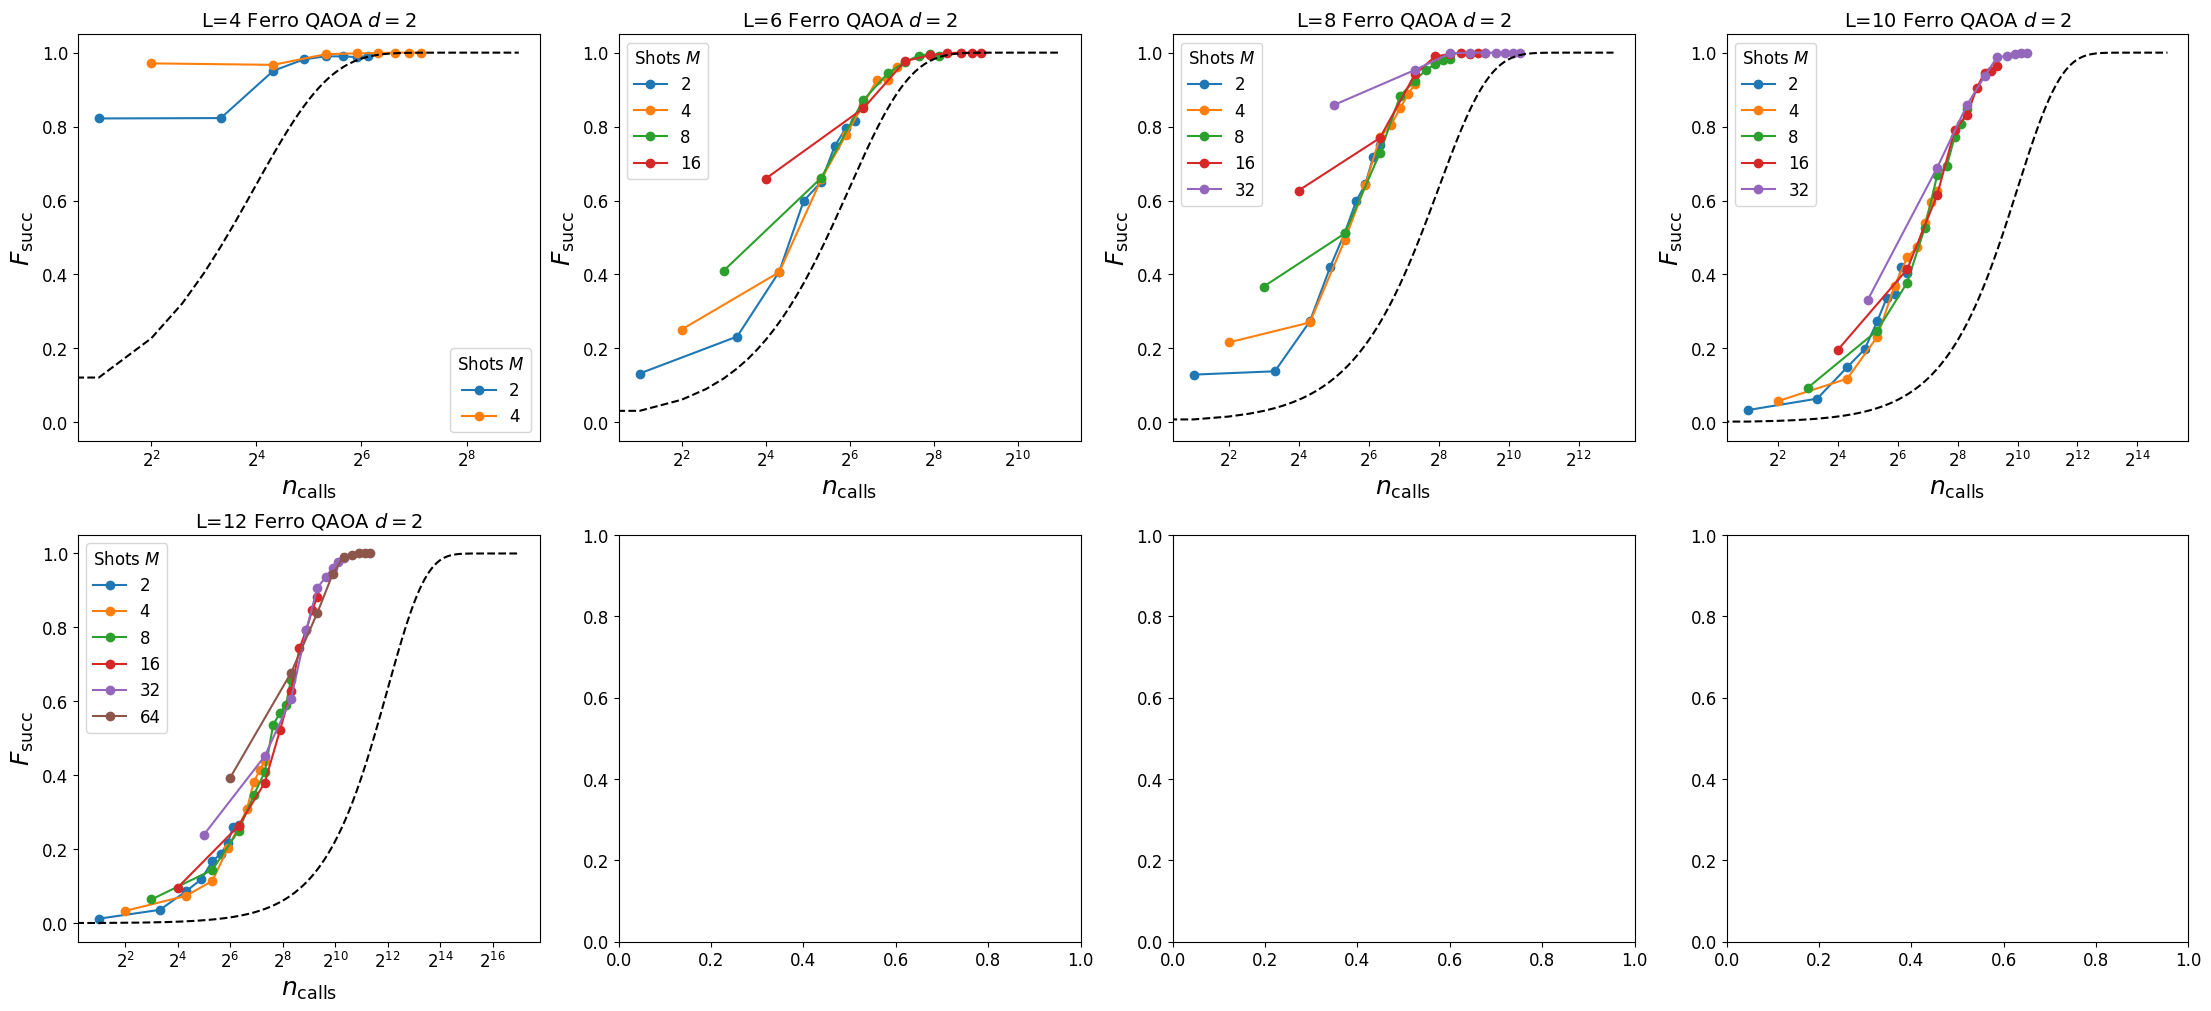

In [43]:
depth = 2
algo = 'qaoa'
max_size = 18

fig = plt.figure(constrained_layout=True, figsize=(22,10))
subplots = fig.subplots(2,4)
for (qubits, data), subplot in zip(opt_qaoa_2[(opt_qaoa_2['algo'] == algo) & (opt_qaoa_2['circ_depth'] == depth) & (opt_qaoa_2['qubits'] <= max_size)].groupby('qubits'), subplots.ravel()):
    for shot, dat in data.groupby('shots'):
        # if ((qubits==4) & (shot > 4)):
        #     continue 
        # if ((qubits==8) & (shot > 32)):
        #     continue
        # if ((qubits==10) & (shot > 1024)):
        #     continue 
        # if ((qubits==16) & (shot < 16)):
        #     continue 
        # if ((qubits==18) & (shot < 32)):
        #     continue 


        x_axes = dat['t']#*dat[dat['seed'] == 1]["circ_depth"]
        y_axes = dat['p_succ']

        subplot.plot(x_axes, y_axes, marker="o", label=f"{shot}")
        #subplot.fill_between(x_axes, dat.groupby(['iter'])['p_succ'].quantile(0.95), dat.groupby(['iter'])['p_succ'].quantile(0.05), alpha=0.3)

    subplot.plot(np.arange(0,2**(5+qubits),2), 1 - (1-1/(2**qubits))**np.arange(0,2**(5+qubits),2), '--', color="black")
    subplot.set_xscale("log", base=2)
    
    subplot.set_xlabel(r"$n_{\mathrm{calls}}$")
    subplot.set_ylabel(r"$F_{\mathrm{succ}}$")

    subplot.set_title(f"L={qubits} Ferro " + r"QAOA $d=$" + f"{depth}", fontsize=14)
    subplot.legend(title=r'Shots $M$')

plt.savefig('img/QAOA_opt2.png', dpi=300)


#### Figure A7


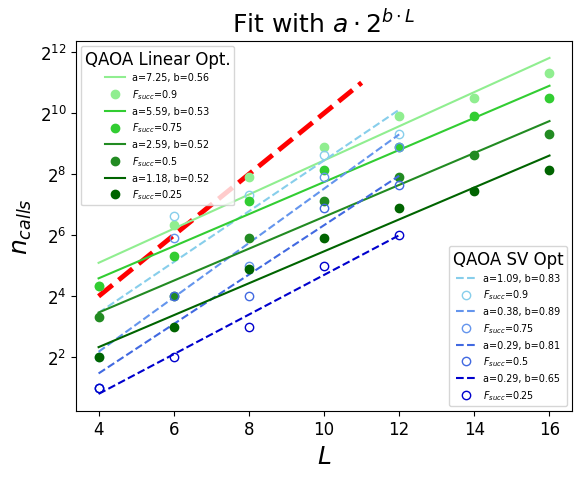

In [44]:
def fun_exp(x, a, b):
    return a*2**(b*x)

def fun_lin(x, a, b):
    return a + b*x

fig, ax = plt.subplots()

min_qubits, max_qubits = 4, 16
min_qubits_toplot, max_qubits_toplot = 4, 12
qubits_toplot = np.arange(min_qubits_toplot, max_qubits_toplot)

depth1 = 2
depth2 = 2

algo = 'qaoa' 

ax.plot(np.arange(min_qubits, max_qubits_toplot), fun_exp(np.arange(min_qubits, max_qubits_toplot), 1, 1), color='red', linewidth=3.5, linestyle="dashed")

plots1, plots2 = [], []

p_tresholds = [0.9, 0.75, 0.5, 0.25]
colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
for j, (p, color) in enumerate(zip(p_tresholds, colors)):
    data1 = opt_qaoa[(opt_qaoa['algo'] == algo) & (opt_qaoa['circ_depth'] == depth1) & (opt_qaoa['qubits'] >= min_qubits) & (opt_qaoa['qubits'] <= max_qubits)]
    data2 = opt_qaoa_2[(opt_qaoa_2['algo'] == algo) & (opt_qaoa_2['circ_depth'] == depth2) & (opt_qaoa_2['qubits'] >= min_qubits) & (opt_qaoa_2['qubits'] <= max_qubits)]
    
    gt_p1 = data1[data1['p_succ'] > p].groupby('qubits', as_index=False)['t'].min()
    gt_p2 = data2[data2['p_succ'] > p].groupby('qubits', as_index=False)['t'].min()

    popt1, _ = optimize.curve_fit(fun_lin, gt_p1['qubits'], np.log2(gt_p1['t']))
    plot1, = ax.plot(gt_p1['qubits'], fun_exp(gt_p1['qubits'], 2**popt1[0], popt1[1]), "-", label=f"a={2**popt1[0]:.2f}, b={popt1[1]:.2f}", color=color)
    plots1.append(plot1)
    plot1, = ax.plot(gt_p1['qubits'], gt_p1['t'], "o", label=r"$F_{succ}$"+f"={p}", color=color)
    plots1.append(plot1)

    popt2, _ = optimize.curve_fit(fun_lin, gt_p2['qubits'], np.log2(gt_p2['t']))
    plot2, = ax.plot(gt_p2['qubits'], fun_exp(gt_p2['qubits'], 2**popt2[0], popt2[1]), "--", label=f"a={2**popt2[0]:.2f}, b={popt2[1]:.2f}", color=colors[j+5])
    plots2.append(plot2)
    plot2, = ax.plot(gt_p2['qubits'], gt_p2['t'], "o", label=r"$F_{succ}$"+f"={p}", fillstyle='none', color=colors[j+5])
    plots2.append(plot2)

ax.set_yscale('log', base=2)
ax.set_ylabel(r"$n_{calls}$")
ax.set_xlabel(r"$L$")
ax.set_xticks(np.arange(min_qubits, max_qubits+1, 2))

first_legend = ax.legend(handles=plots1, title=r"QAOA Linear Opt.", loc='upper left', fontsize="xx-small")
ax1 = plt.gca().add_artist(first_legend)
ax.legend(handles=plots2, loc='lower right', title=r"QAOA SV Opt", fontsize="xx-small")

ax.set_title(r"Fit with $a \cdot 2^{b \cdot L}$")

plt.savefig("img/scalingferro_opt.png", dpi=300)


#### Figure A8

Plot with fixed M=16 (as Guglielmo's)

In [45]:
opt_qaoa.describe()

t       shots        iter      p_succ      qubits  \
count    412.000000  412.000000  412.000000  412.000000  412.000000   
mean     680.466019   30.868932   21.128641    0.461505   12.752427   
std     1383.097021   49.194507   13.478665    0.368248    4.162966   
min        2.000000    2.000000    1.000000    0.000000    4.000000   
25%       60.000000    4.000000   10.000000    0.095750   10.000000   
50%      160.000000    8.000000   20.000000    0.395000   14.000000   
75%      640.000000   32.000000   35.000000    0.846500   16.000000   
max    11520.000000  256.000000   45.000000    1.000000   18.000000   

       circ_depth    succ_true   succ_false  p_succ_final  
count       412.0   412.000000   412.000000    412.000000  
mean          2.0   461.504854   538.495146      0.110454  
std           0.0   368.247811   368.247811      0.133730  
min           2.0     0.000000     0.000000      0.000000  
25%           2.0    95.750000   153.500000      0.012000  
50%           2.0   395.000000   605.000000      0.056500  
75%           2.0   846.500000   904.250000      0.175250  
max           2.0  1000.000000  1000.000000      0.617000

/tmp/ipykernel_369/1475570238.py:42: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plot1, = ax.plot(dat['qubits'][1:], fun_exp(dat['qubits'][1:], 2**popt1[0], popt1[1]), "-", label=f"a={2**popt1[0]:.2f}, b={popt1[1]:.2f}", color=color)
/tmp/ipykernel_369/1475570238.py:51: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  popt2, _ = optimize.curve_fit(fun_lin, dat['qubits'][2:], np.log2(dat['p_succ'][2:]))
/home/beppe/miniconda3/envs/cvar/lib/python3.10/site-packages/scipy/optimize/_m

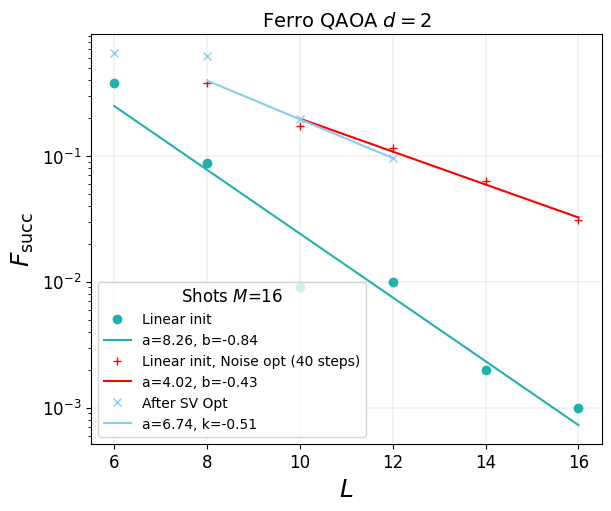

In [46]:
depth = 2
algo = 'qaoa'
max_size = 16
iter_final = 40
iter_final2 = 30

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(6,5))
#subplots = fig.subplots(2,4)

#for (iter, data), plt in zip(opt_qaoa[(ferro_df['algo'] == algo) & (ferro_df['circ_depth'] == depth) & (ferro_df['circ_depth'] <= max_size)].groupby('iter'), subplots.ravel()):
data1 = opt_qaoa[(opt_qaoa['algo'] == algo) & (opt_qaoa['circ_depth'] == depth) & (opt_qaoa['iter'] == 1) & (opt_qaoa['qubits'] <= max_size)] # | (opt_qaoa['iter'] == iter_final) | (opt_qaoa['iter'] == iter_final2))]
colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
for i, (shot, dat) in enumerate(data1.groupby('shots')):
    if shot != 16:
        continue 
    #data_final = dat[(dat['iter'] == iter_final)]
    #data_final2 = dat[(dat['iter'] == iter_final2)]

    # x_axes = dat['qubits']#*dat[dat['seed'] == 1]["circ_depth"]
    # y_axes = dat['p_succ']

    popt1, _ = optimize.curve_fit(fun_lin,  dat['qubits'], np.log2(dat['p_succ_final']))
    plot1, = ax.plot(dat['qubits'], dat['p_succ_final'], "o", label="Linear init", color=colors[i+1])
    plots1.append(plot1)
    plot1, = ax.plot(dat['qubits'], fun_exp(dat['qubits'], 2**popt1[0], popt1[1]), "-", label=f"a={2**popt1[0]:.2f}, b={popt1[1]:.2f}", color=colors[i+1])
    plots1.append(plot1)

data1_final = opt_qaoa[(opt_qaoa['algo'] == algo) & (opt_qaoa['circ_depth'] == depth) & (opt_qaoa['iter'] == iter_final) & (opt_qaoa['qubits'] <= max_size)] # | (opt_qaoa['iter'] == iter_final) | (opt_qaoa['iter'] == iter_final2))]
color = 'r'
for i, (shot, dat) in enumerate(data1_final.groupby('shots')):
    if shot != 16:
        continue 
    #data_final = dat[(dat['iter'] == iter_final)]
    #data_final2 = dat[(dat['iter'] == iter_final2)]

    # x_axes = dat['qubits']#*dat[dat['seed'] == 1]["circ_depth"]
    # y_axes = dat['p_succ']

    popt1, _ = optimize.curve_fit(fun_lin,  dat['qubits'], np.log2(dat['p_succ_final']))
    plot1, = ax.plot(dat['qubits'], dat['p_succ_final'], "+", label="Linear init, Noise opt (40 steps)", color=color)
    plots1.append(plot1)
    plot1, = ax.plot(dat['qubits'][1:], fun_exp(dat['qubits'][1:], 2**popt1[0], popt1[1]), "-", label=f"a={2**popt1[0]:.2f}, b={popt1[1]:.2f}", color=color)
    plots1.append(plot1)

data2 = opt_qaoa_2[(opt_qaoa_2['algo'] == algo) & (opt_qaoa_2['circ_depth'] == depth) & (opt_qaoa_2['iter'] == 1)] # | (opt_qaoa_2['iter'] == iter_final) | (opt_qaoa_2['iter'] == iter_final2))]
colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
for i, (shot, dat) in enumerate(data2.groupby('shots')):
    if shot != 16:
        continue 

    popt2, _ = optimize.curve_fit(fun_lin, dat['qubits'][2:], np.log2(dat['p_succ'][2:]))
    plot2, = ax.plot(dat['qubits'], dat['p_succ'], "x", label="After SV Opt", color=colors[i+2])
    plots2.append(plot2)
    plot2, = ax.plot(dat['qubits'][1:], fun_exp(dat['qubits'][1:], 2**popt2[0], popt2[1]), "-", label=f"a={2**popt2[0]:.2f}, k={popt2[1]:.2f}", color=colors[i+2])
    plots2.append(plot2)

    #ax.plot(x_axes, y_axes, marker="o", label=f"{shot}")
    #subplot.fill_between(x_axes, data2.groupby(['iter'])['p_succ'].quantile(0.95), dat.groupby(['iter'])['p_succ'].quantile(0.05), alpha=0.3)

#ax.plot(np.arange(2, 20, 2), np.exp(-np.arange(2, 20, 2)), '--', color="black")
ax.set_yscale("log", base=10)

ax.grid(linewidth = 0.2)

ax.set_xlabel(r"$L$")
ax.set_ylabel(r"$F_{\mathrm{succ}}$")

ax.set_title(f"Ferro " + r"QAOA $d=2$", fontsize=14)
ax.legend(title=r"Shots $M$"+f"=16", loc='lower left', fontsize='small')

plt.savefig("img/m16-smart_init.png", dpi=300)




#### Figure A9



In [22]:
data_opt_080 = pd.read_csv("data_opt16shots.csv", index_col=0)

In [23]:
data_opt_080.describe()

t  shots   iter      p_succ      qubits  circ_depth    succ_true  \
count  100.0  100.0  100.0  100.000000  100.000000  100.000000   100.000000   
mean    16.0   16.0    1.0    0.911450   13.000000   18.200000   911.450000   
std      0.0    0.0    0.0    0.227044    5.773503   11.243854   227.044265   
min     16.0   16.0    1.0    0.017000    4.000000    2.000000    17.000000   
25%     16.0   16.0    1.0    0.989750    8.000000    8.000000   989.750000   
50%     16.0   16.0    1.0    1.000000   13.000000   18.000000  1000.000000   
75%     16.0   16.0    1.0    1.000000   18.000000   28.000000  1000.000000   
max     16.0   16.0    1.0    1.000000   22.000000   36.000000  1000.000000   

       succ_false  p_succ_final  
count  100.000000    100.000000  
mean    88.550000      0.866420  
std    227.044265      0.266735  
min      0.000000      0.009000  
25%      0.000000      0.908500  
50%      0.000000      0.998000  
75%     10.250000      1.000000  
max    983.000000      1.000000

/tmp/ipykernel_372/846344174.py:19: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  popt1, _ = optimize.curve_fit(fun_lin,  dat['qubits'][2:], np.log2(dat['p_succ_final'][2:]))


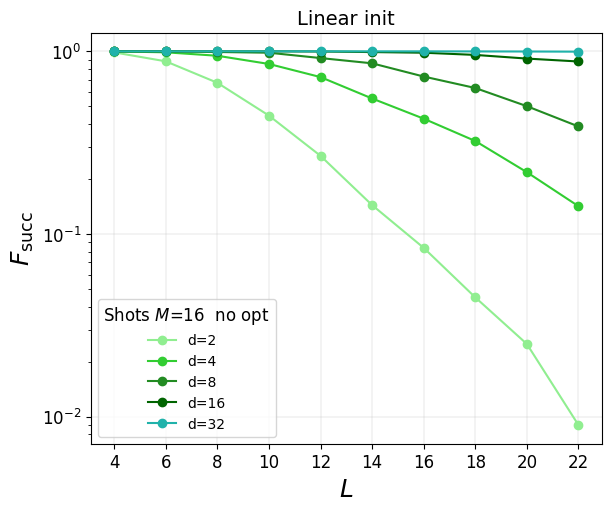

In [29]:
#depths = [2,4,8,12,16,20,24,28,32,36]
depths = [2,4,8,16,32]
algo = 'qaoa'

def fun_exp(x, a, b):
    return a*2**(b*x)

def fun_lin(x, a, b):
    return a + b*x

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(6,5))

colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
for k, depth in enumerate(depths):
    if ((depth == 2) or (depth == 4) or (depth == 8) or (depth == 16) or (depth == 32)):
        dat = data_opt_080[(data_opt_080['algo'] == algo) & (data_opt_080['circ_depth'] == depth)]
        dat = dat[dat["p_succ_final"]!=0]

        popt1, _ = optimize.curve_fit(fun_lin,  dat['qubits'][2:], np.log2(dat['p_succ_final'][2:]))
        ax.plot(dat['qubits'], dat['p_succ_final'], "-o", label=f"d={depth}", color=colors[k])
        #ax.plot(dat['qubits'][2:], fun_exp(dat['qubits'][2:], 2**popt1[0], popt1[1]), "-", label=f"a={2**popt1[0]:.2f}, b={popt1[1]:.2f}", color=colors[k+1])


ax.set_xticks(np.arange(data_opt_080['qubits'].min(), data_opt_080['qubits'].max() + 2, 2))
ax.set_yscale("log", base=10)

ax.grid(linewidth = 0.2)

ax.set_xlabel(r"$L$")
ax.set_ylabel(r"$F_{\mathrm{succ}}$")

ax.set_title(f"Linear init", fontsize=14) #+ r" Fit $a \cdot 2^{bx}$
ax.legend(title=r"Shots $M$"+f"=16 " + " no opt", loc='lower left', fontsize='small')

plt.savefig("img/depth-smart_init.png", dpi=300)


#### Figure A10


In [50]:
data_linopt = pd.read_csv("data_linopt.csv", index_col=0)
data_linopt.describe()

t       shots        iter      p_succ      qubits  \
count    690.000000  690.000000  690.000000  690.000000  690.000000   
mean     719.939130   27.588406   26.010145    0.778132   12.226087   
std     1391.532086   43.141161   18.169055    0.301479    4.003759   
min        2.000000    2.000000    1.000000    0.007000    4.000000   
25%       60.000000    4.000000   10.000000    0.621250   10.000000   
50%      160.000000    8.000000   25.000000    0.954000   12.000000   
75%      640.000000   32.000000   40.000000    1.000000   16.000000   
max    11264.000000  256.000000   70.000000    1.000000   18.000000   

       circ_depth    succ_true  succ_false  p_succ_final  
count  690.000000   690.000000  690.000000    690.000000  
mean     2.788406   778.131884  221.868116      0.380006  
std      0.978067   301.478916  301.478916      0.315246  
min      2.000000     7.000000    0.000000      0.001000  
25%      2.000000   621.250000    0.000000      0.090000  
50%      2.000000   954.000000   46.000000      0.302500  
75%      4.000000  1000.000000  378.750000      0.631750  
max      4.000000  1000.000000  993.000000      1.000000

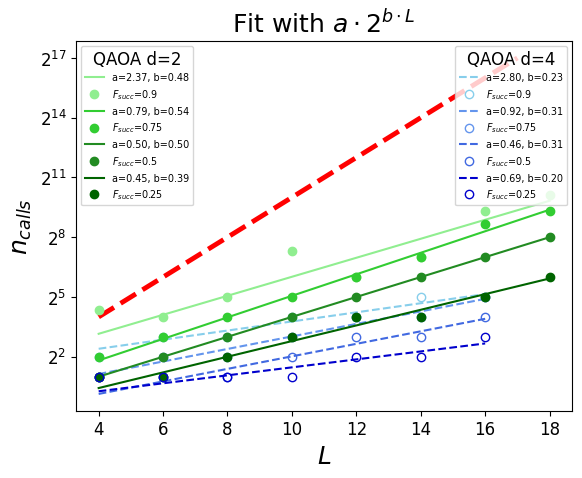

In [51]:
def fun_exp(x, a, b):
    return a*2**(b*x)

def fun_lin(x, a, b):
    return a + b*x

fig, ax = plt.subplots()

min_qubits, max_qubits = 4, 18
min_qubits_toplot, max_qubits_toplot = 4, 18
qubits_toplot = np.arange(min_qubits_toplot, max_qubits_toplot)

depth1 = 2
depth2 = 4

algo = 'qaoa' 

ax.plot(np.arange(min_qubits, max_qubits_toplot), fun_exp(np.arange(min_qubits, max_qubits_toplot), 1, 1), color='red', linewidth=3.5, linestyle="dashed")

plots1, plots2 = [], []

p_tresholds = [0.9, 0.75, 0.5, 0.25]
colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
for j, (p, color) in enumerate(zip(p_tresholds, colors)):
    data1 = data_linopt[(data_linopt['algo'] == algo) & (data_linopt['circ_depth'] == depth1) & (data_linopt['qubits'] >= min_qubits) & (data_linopt['qubits'] <= max_qubits)]
    data2 = data_linopt[(data_linopt['algo'] == algo) & (data_linopt['circ_depth'] == depth2) & (data_linopt['qubits'] >= min_qubits) & (data_linopt['qubits'] <= max_qubits)]
    
    gt_p1 = data1[data1['p_succ'] > p].groupby('qubits', as_index=False)['t'].min()
    gt_p2 = data2[data2['p_succ'] > p].groupby('qubits', as_index=False)['t'].min()

    popt1, _ = optimize.curve_fit(fun_lin, gt_p1['qubits'][1:], np.log2(gt_p1['t'][1:]))
    plot1, = ax.plot(gt_p1['qubits'], fun_exp(gt_p1['qubits'], 2**popt1[0], popt1[1]), "-", label=f"a={2**popt1[0]:.2f}, b={popt1[1]:.2f}", color=color)
    plots1.append(plot1)
    plot1, = ax.plot(gt_p1['qubits'], gt_p1['t'], "o", label=r"$F_{succ}$"+f"={p}", color=color)
    plots1.append(plot1)

    popt2, _ = optimize.curve_fit(fun_lin, gt_p2['qubits'][1:], np.log2(gt_p2['t'][1:]))
    plot2, = ax.plot(gt_p2['qubits'], fun_exp(gt_p2['qubits'], 2**popt2[0], popt2[1]), "--", label=f"a={2**popt2[0]:.2f}, b={popt2[1]:.2f}", color=colors[j+5])
    plots2.append(plot2)
    plot2, = ax.plot(gt_p2['qubits'], gt_p2['t'], "o", label=r"$F_{succ}$"+f"={p}", fillstyle='none', color=colors[j+5])
    plots2.append(plot2)

ax.set_yscale('log', base=2)
ax.set_ylabel(r"$n_{calls}$")
ax.set_xlabel(r"$L$")
ax.set_xticks(np.arange(min_qubits, max_qubits+1, 2))

first_legend = ax.legend(handles=plots1, title=f"QAOA d={depth1}", loc='upper left', fontsize="xx-small")
ax1 = plt.gca().add_artist(first_legend)
ax.legend(handles=plots2, loc='upper right', title=f"QAOA d={depth2}", fontsize="xx-small")
ax.set_title(r"Fit with $a \cdot 2^{b \cdot L}$")

plt.savefig("img/scalingferro_linopt.png", dpi=300)


#### Figure A11


In [4]:
data_linopt = pd.read_csv("data_linopt.csv", index_col=0)

ferro_list = [pd.read_csv(f"data_n{n}-test.csv", index_col=0) for n in range(4,22,2)]
data_randinit = pd.concat(ferro_list, ignore_index=True)
data_randinit.describe()

t        shots         iter       p_succ       qubits  \
count    6504.000000  6504.000000  6504.000000  6504.000000  6504.000000   
mean     8629.852091   479.106396    20.571187     0.423677    12.462485   
std     25813.072109  1206.442781    17.597937     0.392283     4.728275   
min         2.000000     2.000000     1.000000     0.000000     4.000000   
25%       112.000000     8.000000     8.000000     0.033000     8.000000   
50%       640.000000    32.000000    18.000000     0.297500    12.000000   
75%      4096.000000   256.000000    28.000000     0.861000    16.000000   
max    512000.000000  8192.000000   250.000000     1.000000    20.000000   

        circ_depth    succ_true    succ_false  p_succ_final  
count  6504.000000  6504.000000   6504.000000   6504.000000  
mean      1.967405   454.534287   1585.751691      0.226609  
std       0.792193   501.467539   2976.353463      0.314536  
min       1.000000     0.000000      0.000000      0.000000  
25%       1.000000    47.000000    139.000000      0.004000  
50%       2.000000   328.000000    708.000000      0.057000  
75%       2.000000   874.000000    974.000000      0.343000  
max       4.000000  7895.000000  10000.000000      1.000000

/tmp/ipykernel_394/3157352990.py:40: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  subplot.plot(dat_rand['qubits'][:-1], dat_rand['p_succ_final'][:-1], "-o", label=f"d={depth}, no opt., random init.", color=colors_rand[k % 2])
/tmp/ipykernel_394/3157352990.py:41: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  subplot.plot(dat_after_opt_rand['qubits'][:-1], dat_after_opt_rand['p_succ_final'][:-1], "--x", label=f"d={depth}," + r" $n_{\mathrm{iter}}$=" + f"{maxiter_rand}, random init

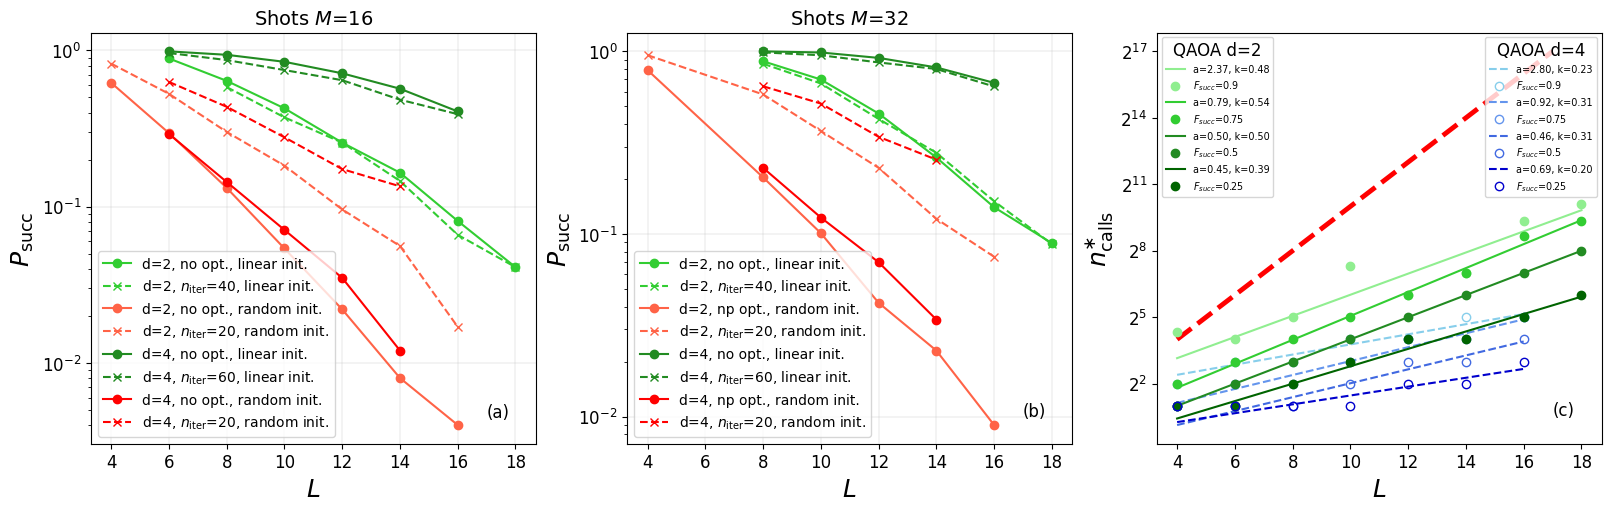

In [49]:
depths = [2,4]
maxiter_d2 = 40
maxiter_d4 = 60
maxiter_rand = 20

def fun_exp(x, a, b):
    return a*2**(b*x)

def fun_lin(x, a, b):
    return a + b*x


fig = plt.figure(constrained_layout=True, figsize=(16,5))
subplots = fig.subplots(1,3)
plots1, plots2 = [], [] 

for i, subplot in enumerate(subplots.ravel()):
    if i==0:
        shots = 16
        colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
        colors_rand = ["tomato", "red"]
        for k, depth in enumerate(depths):
            if ((depth == 2) or (depth == 4)):
                dat = data_linopt[(data_linopt['shots'] == shots) & (data_linopt['circ_depth'] == depth) & (data_linopt['iter'] == 1)]
                dat_rand = data_randinit[(data_randinit['shots'] == shots) & (data_randinit['circ_depth'] == depth) & (data_randinit['iter'] == 1) & (data_randinit['algo'] == "qaoa")]

                dat = dat[dat["p_succ_final"]!=0]

                #popt1, _ = optimize.curve_fit(fun_lin,  dat['qubits'][1:], np.log2(dat['p_succ'][1:]))
                subplot.plot(dat['qubits'], dat['p_succ_final'], "-o", label=f"d={depth}, no opt., linear init.", color=colors[k+1])
                #subplot.plot(dat['qubits'][1:], fun_exp(dat['qubits'][1:], 2**popt1[0], popt1[1]), "-", label=f"a={2**popt1[0]:.2f}, b={popt1[1]:.2f}", color=colors[k+1])

                maxiter = maxiter_d2 if depth==2 else maxiter_d4
                dat_after_opt = data_linopt[(data_linopt['shots'] == shots) & (data_linopt['circ_depth'] == depth) & (data_linopt['iter'] == maxiter)]
                dat_after_opt_rand = data_randinit[(data_randinit['shots'] == shots) & (data_randinit['circ_depth'] == depth) & (data_randinit['iter'] == maxiter_rand) & (data_randinit['algo'] == "qaoa")]

                #popt2, _ = optimize.curve_fit(fun_lin,  dat_after_opt['qubits'][1:], np.log2(dat_after_opt['p_succ_final'][1:]))
                subplot.plot(dat_after_opt['qubits'], dat_after_opt['p_succ_final'], "--x", label=f"d={depth}," + r" $n_{\mathrm{iter}}$=" + f"{maxiter}, linear init.", color=colors[k+1])

                subplot.plot(dat_rand['qubits'][:-1], dat_rand['p_succ_final'][:-1], "-o", label=f"d={depth}, no opt., random init.", color=colors_rand[k % 2])
                subplot.plot(dat_after_opt_rand['qubits'][:-1], dat_after_opt_rand['p_succ_final'][:-1], "--x", label=f"d={depth}," + r" $n_{\mathrm{iter}}$=" + f"{maxiter_rand}, random init.", color=colors_rand[k % 2])
                #subplot.plot(dat_after_opt['qubits'][1:], fun_exp(dat_after_opt['qubits'][1:], 2**popt2[0], popt2[1]), "-", label=f"a={2**popt2[0]:.2f}, b={popt2[1]:.2f}", color=colors[k+1])
        subplot.set_xticks(np.arange(data_linopt['qubits'].min(), data_linopt['qubits'].max() + 2, 2))
        subplot.set_yscale("log", base=10)
        subplot.grid(linewidth = 0.2)
        subplot.set_xlabel(r"$L$")
        subplot.set_ylabel(r"$P_{\mathrm{succ}}$")
        subplot.set_title(r"Shots $M$"+f"={shots}", fontsize=14)
        subplot.legend(loc='lower left', fontsize='small')
        subplot.text(17, 0.0045, '(a)')

    if i==1:
        shots = 32
        colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
        colors_rand = ["tomato", "red"]
        for k, depth in enumerate(depths):
            if ((depth == 2) or (depth == 4)):
                dat = data_linopt[(data_linopt['shots'] == shots) & (data_linopt['circ_depth'] == depth) & (data_linopt['iter'] == 1)]
                dat_rand = data_randinit[(data_randinit['shots'] == shots) & (data_randinit['circ_depth'] == depth) & (data_randinit['iter'] == 1) & (data_randinit['algo'] == "qaoa")]

                dat = dat[dat["p_succ_final"]!=0]

                #popt1, _ = optimize.curve_fit(fun_lin,  dat['qubits'][1:], np.log2(dat['p_succ'][1:]))
                subplot.plot(dat['qubits'], dat['p_succ_final'], "-o", label=f"d={depth}, no opt., linear init.", color=colors[k+1])
                #subplot.plot(dat['qubits'][1:], fun_exp(dat['qubits'][1:], 2**popt1[0], popt1[1]), "-", label=f"a={2**popt1[0]:.2f}, b={popt1[1]:.2f}", color=colors[k+1])

                maxiter = maxiter_d2 if depth==2 else maxiter_d4
                dat_after_opt = data_linopt[(data_linopt['shots'] == shots) & (data_linopt['circ_depth'] == depth) & (data_linopt['iter'] == maxiter)]
                dat_after_opt_rand = data_randinit[(data_randinit['shots'] == shots) & (data_randinit['circ_depth'] == depth) & (data_randinit['iter'] == maxiter_rand) & (data_randinit['algo'] == "qaoa")]

                #popt2, _ = optimize.curve_fit(fun_lin,  dat_after_opt['qubits'][1:], np.log2(dat_after_opt['p_succ_final'][1:]))
                subplot.plot(dat_after_opt['qubits'], dat_after_opt['p_succ_final'], "--x", label=f"d={depth}," + r" $n_{\mathrm{iter}}$=" + f"{maxiter}, linear init.", color=colors[k+1])

                subplot.plot(dat_rand['qubits'][:-1], dat_rand['p_succ_final'][:-1], "-o", label=f"d={depth}, np opt., random init.", color=colors_rand[k % 2])
                subplot.plot(dat_after_opt_rand['qubits'][:-1], dat_after_opt_rand['p_succ_final'][:-1], "--x", label=f"d={depth}," + r" $n_{\mathrm{iter}}$=" + f"{maxiter_rand}, random init.", color=colors_rand[k % 2])
                #subplot.plot(dat_after_opt['qubits'][1:], fun_exp(dat_after_opt['qubits'][1:], 2**popt2[0], popt2[1]), "-", label=f"a={2**popt2[0]:.2f}, b={popt2[1]:.2f}", color=colors[k+1])
        subplot.set_xticks(np.arange(data_linopt['qubits'].min(), data_linopt['qubits'].max() + 2, 2))
        subplot.set_yscale("log", base=10)
        subplot.grid(linewidth = 0.2)
        subplot.set_xlabel(r"$L$")
        subplot.set_ylabel(r"$P_{\mathrm{succ}}$")
        subplot.set_title(r"Shots $M$"+f"={shots}", fontsize=14)
        subplot.legend(loc='lower left', fontsize='small')
        subplot.text(17, 10**-2, '(b)')

    if i==2:
        min_qubits, max_qubits = 4, 18
        min_qubits_toplot, max_qubits_toplot = 4, 18
        qubits_toplot = np.arange(min_qubits_toplot, max_qubits_toplot)
        depth1 = 2
        depth2 = 4
        algo = 'qaoa' 
        subplot.plot(np.arange(min_qubits, max_qubits_toplot), fun_exp(np.arange(min_qubits, max_qubits_toplot), 1, 1), color='red', linewidth=3.5, linestyle="dashed")
        plots1, plots2 = [], []
        p_tresholds = [0.9, 0.75, 0.5, 0.25]
        colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
        for j, (p, color) in enumerate(zip(p_tresholds, colors)):
            data1 = data_linopt[(data_linopt['algo'] == algo) & (data_linopt['circ_depth'] == depth1) & (data_linopt['qubits'] >= min_qubits) & (data_linopt['qubits'] <= max_qubits)]
            data2 = data_linopt[(data_linopt['algo'] == algo) & (data_linopt['circ_depth'] == depth2) & (data_linopt['qubits'] >= min_qubits) & (data_linopt['qubits'] <= max_qubits)]
            gt_p1 = data1[data1['p_succ'] > p].groupby('qubits', as_index=False)['t'].min()
            gt_p2 = data2[data2['p_succ'] > p].groupby('qubits', as_index=False)['t'].min()

            popt1, _ = optimize.curve_fit(fun_lin, gt_p1['qubits'][1:], np.log2(gt_p1['t'][1:]))
            plot1, = subplot.plot(gt_p1['qubits'], fun_exp(gt_p1['qubits'], 2**popt1[0], popt1[1]), "-", label=f"a={2**popt1[0]:.2f}, k={popt1[1]:.2f}", color=color)
            plots1.append(plot1)
            plot1, = subplot.plot(gt_p1['qubits'], gt_p1['t'], "o", label=r"$F_{succ}$"+f"={p}", color=color)
            plots1.append(plot1)
            popt2, _ = optimize.curve_fit(fun_lin, gt_p2['qubits'][1:], np.log2(gt_p2['t'][1:]))
            plot2, = subplot.plot(gt_p2['qubits'], fun_exp(gt_p2['qubits'], 2**popt2[0], popt2[1]), "--", label=f"a={2**popt2[0]:.2f}, k={popt2[1]:.2f}", color=colors[j+5])
            plots2.append(plot2)
            plot2, = subplot.plot(gt_p2['qubits'], gt_p2['t'], "o", label=r"$F_{succ}$"+f"={p}", fillstyle='none', color=colors[j+5])
            plots2.append(plot2)

        subplot.set_yscale('log', base=2)
        subplot.set_ylabel(r"$n^{\ast}_{\mathrm{calls}}$")
        subplot.set_xlabel(r"$L$")
        subplot.set_xticks(np.arange(min_qubits, max_qubits+1, 2))
        first_legend = subplot.legend(handles=plots1, title=f"QAOA d={depth1}", loc='upper left', fontsize="xx-small")
        ax1 = plt.gca().add_artist(first_legend)
        subplot.legend(handles=plots2, loc='upper right', title=f"QAOA d={depth2}", fontsize="xx-small")
        #subplot.set_title(r"Fit with $a \cdot 2^{k \cdot L}$")
        subplot.text(17, 1.5, '(c)')

plt.savefig(f"img/fig4", dpi=200)


#### A11 bis


In [36]:
ferro_list = [pd.read_csv(f"data_n{n}-test.csv", index_col=0) for n in range(4,22,2)]
data_randinit = pd.concat(ferro_list, ignore_index=True)
data_randinit.describe()

t        shots         iter       p_succ       qubits  \
count    6504.000000  6504.000000  6504.000000  6504.000000  6504.000000   
mean     8629.852091   479.106396    20.571187     0.423677    12.462485   
std     25813.072109  1206.442781    17.597937     0.392283     4.728275   
min         2.000000     2.000000     1.000000     0.000000     4.000000   
25%       112.000000     8.000000     8.000000     0.033000     8.000000   
50%       640.000000    32.000000    18.000000     0.297500    12.000000   
75%      4096.000000   256.000000    28.000000     0.861000    16.000000   
max    512000.000000  8192.000000   250.000000     1.000000    20.000000   

        circ_depth    succ_true    succ_false  p_succ_final  
count  6504.000000  6504.000000   6504.000000   6504.000000  
mean      1.967405   454.534287   1585.751691      0.226609  
std       0.792193   501.467539   2976.353463      0.314536  
min       1.000000     0.000000      0.000000      0.000000  
25%       1.000000    47.000000    139.000000      0.004000  
50%       2.000000   328.000000    708.000000      0.057000  
75%       2.000000   874.000000    974.000000      0.343000  
max       4.000000  7895.000000  10000.000000      1.000000

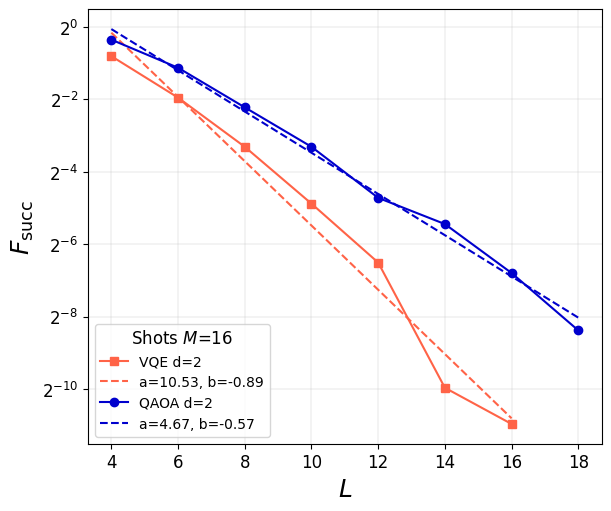

In [35]:
depth = 2
algos = ['qaoa', 'vqe']

def fun_exp(x, a, b):
    return a*2**(b*x)

def fun_lin(x, a, b):
    return a + b*x

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(6,5))

shots = 16
colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
colors_rand = ["tomato", "red"]

#dat = data_linopt[(data_linopt['shots'] == shots) & (data_linopt['circ_depth'] == depth) & (data_linopt['iter'] == 1)]
dat_qaoa = data_randinit[(data_randinit['shots'] == shots) & (data_randinit['circ_depth'] == depth) & (data_randinit['iter'] == 1) & (data_randinit['algo'] == "qaoa")]
dat_vqe = data_randinit[(data_randinit['shots'] == shots) & (data_randinit['circ_depth'] == depth) & (data_randinit['iter'] == 1) & (data_randinit['algo'] == "vqe")]

popt1, _ = optimize.curve_fit(fun_lin, dat_vqe['qubits'].iloc[:-2], np.log2(dat_vqe['p_succ'].iloc[:-2]))
popt2, _ = optimize.curve_fit(fun_lin,  dat_qaoa['qubits'], np.log2(dat_qaoa['p_succ']))

ax.plot(dat_vqe['qubits'].iloc[:-2], dat_vqe['p_succ'].iloc[:-2], "-s", label=f"VQE d={depth}", color=colors_rand[0])
ax.plot(dat_vqe['qubits'].iloc[:-2], fun_exp(dat_vqe['qubits'].iloc[:-2], 2**popt1[0], popt1[1]), "--", label=f"a={2**popt1[0]:.2f}, b={popt1[1]:.2f}", color=colors_rand[0])

ax.plot(dat_qaoa['qubits'], dat_qaoa['p_succ'], "-o", label=f"QAOA d={depth}", color=colors[-2])
ax.plot(dat_qaoa['qubits'], fun_exp(dat_qaoa['qubits'], 2**popt2[0], popt2[1]), "--", label=f"a={2**popt2[0]:.2f}, b={popt2[1]:.2f}", color=colors[-2])

ax.set_xticks(np.arange(data_linopt['qubits'].min(), data_linopt['qubits'].max() + 2, 2))
ax.set_yscale("log", base=2)
ax.grid(linewidth = 0.2)
ax.set_xlabel(r"$L$")
ax.set_ylabel(r"$F_{\mathrm{succ}}$")
#ax.set_title(f"QAOA", fontsize=14)
ax.legend(title=r"Shots $M$"+f"={shots} ", loc='lower left', fontsize='small')

plt.savefig(f"img/fig3", dpi=200)

In [41]:
dat_vqe

t  shots  iter  p_succ  qubits  circ_depth algo  succ_true  succ_false  \
478   16     16     1  0.5730       4           2  vqe        573         427   
864   16     16     1  0.2590       6           2  vqe        259         741   
1499  16     16     1  0.1010       8           2  vqe        101         899   
2202  16     16     1  0.0340      10           2  vqe         34         966   
3112  16     16     1  0.0110      12           2  vqe         11         989   
3854  16     16     1  0.0010      14           2  vqe          1         999   
4745  16     16     1  0.0005      16           2  vqe          5        9995   
5676  16     16     1  0.0000      18           2  vqe          0       10000   
6344  16     16     1  0.0000      20           2  vqe          0        1000   

      p_succ_final  
478         0.4410  
864         0.1640  
1499        0.0480  
2202        0.0230  
3112        0.0040  
3854        0.0000  
4745        0.0002  
5676        0.0000  
6344        0.0000


#### Figure A12


In [56]:
data_linopt = pd.read_csv("data_linopt.csv", index_col=0)
data_linopt.describe()

t       shots        iter      p_succ      qubits  \
count    690.000000  690.000000  690.000000  690.000000  690.000000   
mean     719.939130   27.588406   26.010145    0.778132   12.226087   
std     1391.532086   43.141161   18.169055    0.301479    4.003759   
min        2.000000    2.000000    1.000000    0.007000    4.000000   
25%       60.000000    4.000000   10.000000    0.621250   10.000000   
50%      160.000000    8.000000   25.000000    0.954000   12.000000   
75%      640.000000   32.000000   40.000000    1.000000   16.000000   
max    11264.000000  256.000000   70.000000    1.000000   18.000000   

       circ_depth    succ_true  succ_false  p_succ_final  
count  690.000000   690.000000  690.000000    690.000000  
mean     2.788406   778.131884  221.868116      0.380006  
std      0.978067   301.478916  301.478916      0.315246  
min      2.000000     7.000000    0.000000      0.001000  
25%      2.000000   621.250000    0.000000      0.090000  
50%      2.000000   954.000000   46.000000      0.302500  
75%      4.000000  1000.000000  378.750000      0.631750  
max      4.000000  1000.000000  993.000000      1.000000

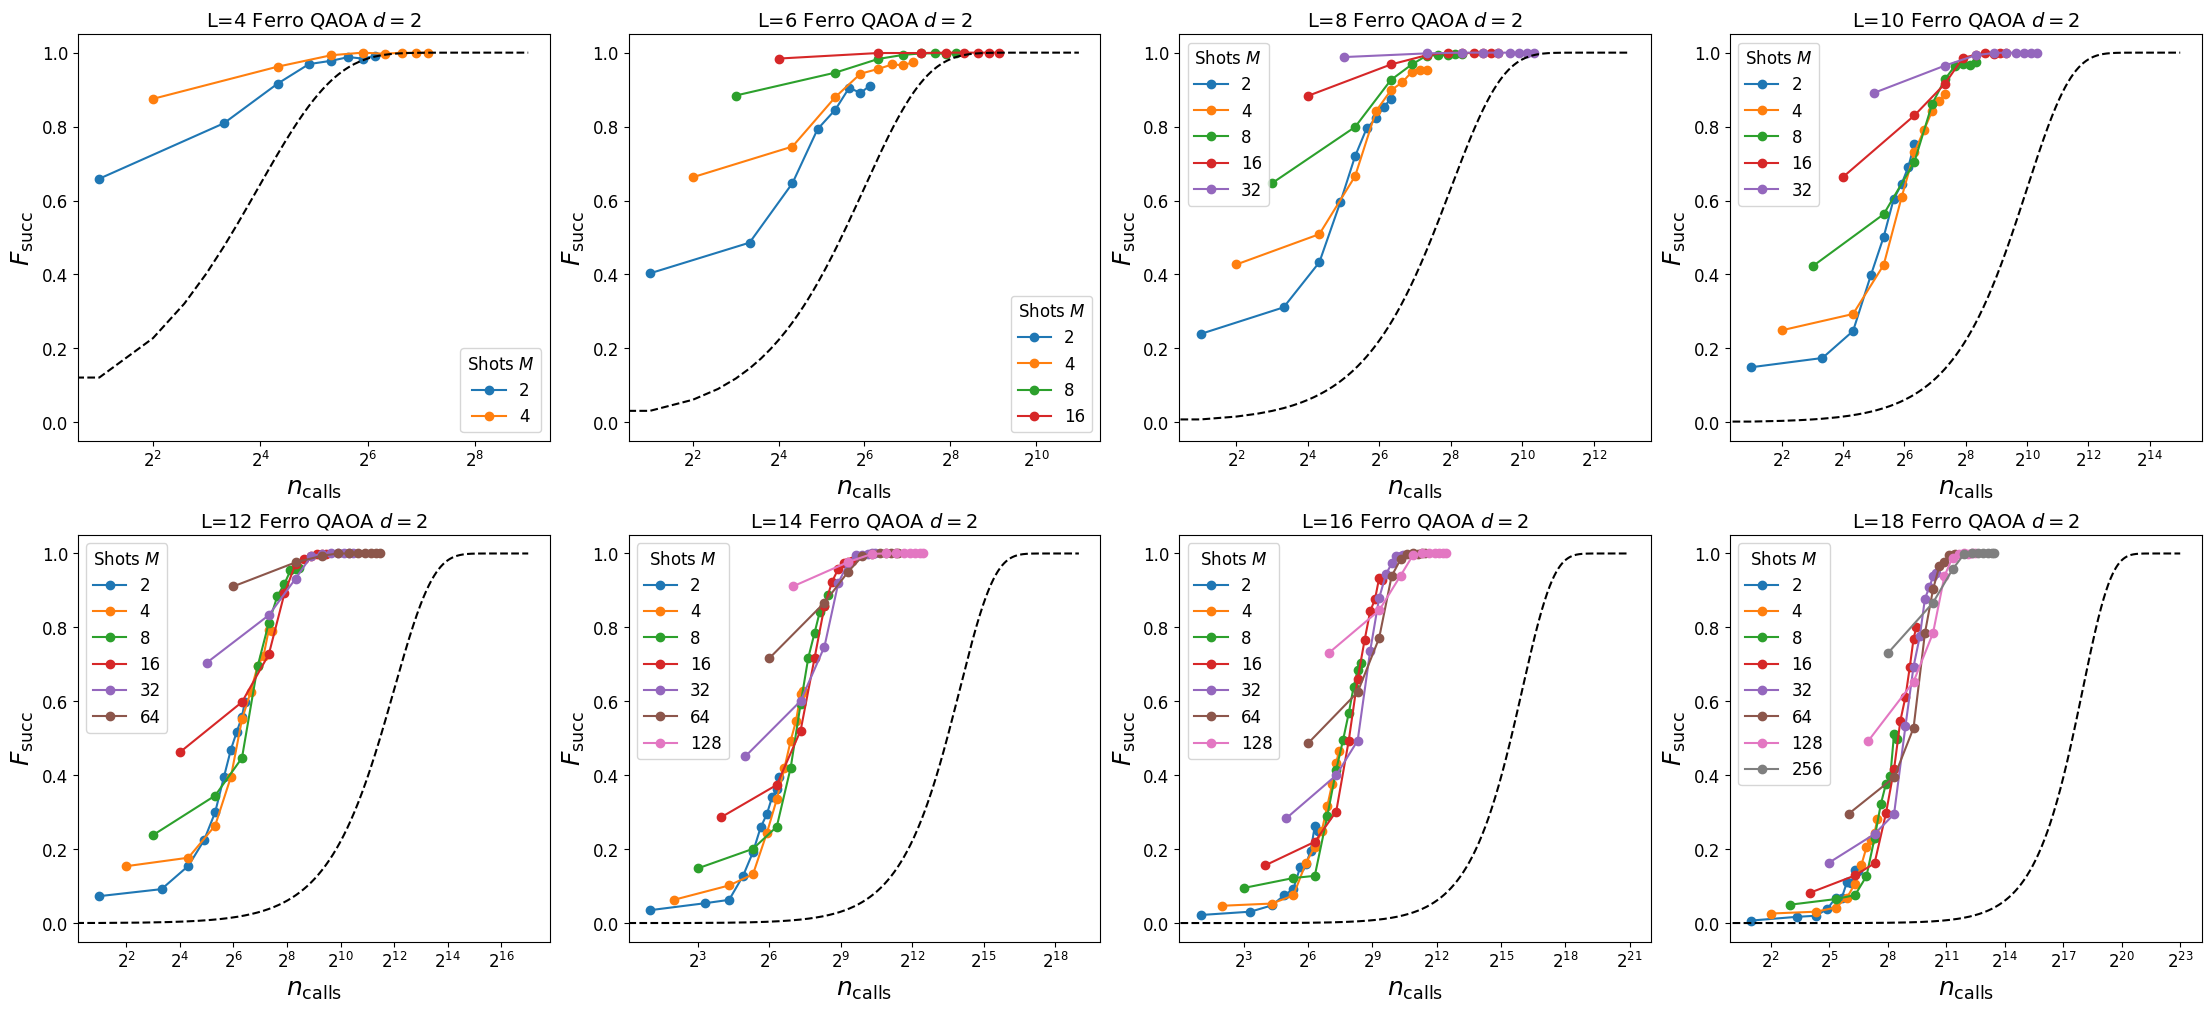

In [59]:
depth = 2
algo = 'qaoa'

fig = plt.figure(constrained_layout=True, figsize=(22,10))
subplots = fig.subplots(2,4)
for (qubits, data), subplot in zip(data_linopt[(data_linopt['algo'] == algo) & (data_linopt['circ_depth'] == depth)].groupby('qubits'), subplots.ravel()):
    for shot, dat in data.groupby('shots'):
        # if ((qubits==4) & (shot > 4)):
        #     continue 
        # if ((qubits==8) & (shot > 32)):
        #     continue
        # if ((qubits==10) & (shot > 1024)):
        #     continue 
        # if ((qubits==16) & (shot < 16)):
        #     continue 
        # if ((qubits==18) & (shot < 32)):
        #     continue 

        x_axes = dat['t']
        y_axes = dat['p_succ']

        subplot.plot(x_axes, y_axes, marker="o", label=f"{shot}")
        #subplot.fill_between(x_axes, dat.groupby(['iter'])['p_succ'].quantile(0.95), dat.groupby(['iter'])['p_succ'].quantile(0.05), alpha=0.3)

    subplot.plot(np.arange(0,2**(5+qubits),2), 1 - (1-1/(2**qubits))**np.arange(0,2**(5+qubits),2), '--', color="black")
    subplot.set_xscale("log", base=2)
    
    subplot.set_xlabel(r"$n_{\mathrm{calls}}$")
    subplot.set_ylabel(r"$F_{\mathrm{succ}}$")

    subplot.set_title(f"L={qubits} Ferro " + r"QAOA $d=$" + f"{depth}", fontsize=14)
    subplot.legend(title=r'Shots $M$')

plt.savefig(f'img/depth{depth}_lininit.png', dpi=300)


#### Figure A13


In [25]:
data_rand = pd.read_csv("data_spinglass.csv", index_col=0)
data_linearinit_rand = pd.read_csv("data_lininit_rand.csv", index_col=0)

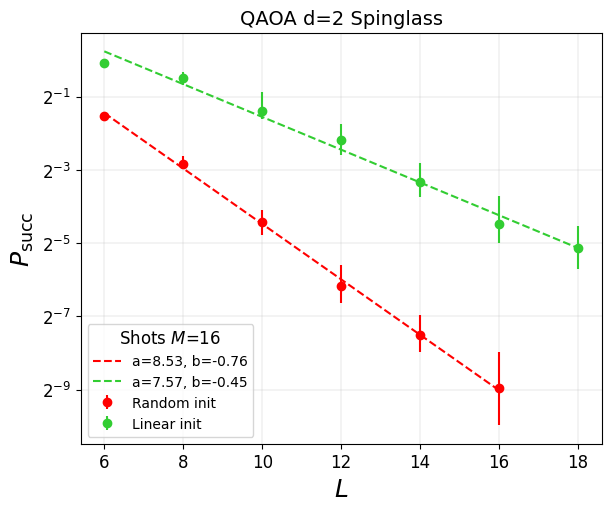

In [26]:
depth = 2
maxiter_d2 = 40
maxiter_rand = 20
shots = 16

def fun_exp(x, a, b):
    return a*2**(b*x)

def fun_lin(x, a, b):
    return a + b*x

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(6,5))

colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
colors_rand = ["tomato", "red"]

dat_randinit = data_rand[(data_rand['shots'] == shots) & (data_rand['circ_depth'] == depth) & (data_rand['iter'] == 1) & (data_rand['algo'] == "qaoa")]
dat_linearinit = data_linearinit_rand[(data_linearinit_rand['shots'] == shots) & (data_linearinit_rand['circ_depth'] == depth) & (data_linearinit_rand['iter'] == 1) & (data_linearinit_rand['algo'] == "qaoa")]

x_axes = dat_randinit[dat_randinit['seed'] == 1]['qubits'] #*dat_randinit[dat_randinit['seed'] == 1]["circ_depth"]
y_axes = dat_randinit.groupby(['qubits'])['p_succ'].median()
error = [
        (y_axes - dat_randinit.groupby(['qubits'])['p_succ'].quantile(0.25)).tolist(),
        (dat_randinit.groupby(['qubits'])['p_succ'].quantile(0.75) - y_axes).tolist(),
        ]
ax.errorbar(x_axes, y_axes, yerr=error, marker="o", color=colors_rand[k%2], ls="None", label=f"Random init")
popt1, _ = optimize.curve_fit(fun_lin, x_axes, np.log2(y_axes))
ax.plot(x_axes, fun_exp(x_axes, 2**popt1[0], popt1[1]), "--", label=f"a={2**popt1[0]:.2f}, b={popt1[1]:.2f}", color=colors_rand[k%2])


x_axes = dat_linearinit[dat_linearinit['seed'] == 1]['qubits'] #*dat_linearinit[dat_linearinit['seed'] == 1]["circ_depth"]
y_axes = dat_linearinit.groupby(['qubits'])['p_succ'].median()
error = [
        (dat_linearinit.groupby(['qubits'])['p_succ'].median() - dat_linearinit.groupby(['qubits'])['p_succ'].quantile(0.25)).tolist(),
        (dat_linearinit.groupby(['qubits'])['p_succ'].quantile(0.75) - dat_linearinit.groupby(['qubits'])['p_succ'].median()).tolist(),
        ]
ax.errorbar(x_axes, y_axes, yerr=error, marker="o", color=colors[k], ls="None", label=f"Linear init")

popt2, _ = optimize.curve_fit(fun_lin,  x_axes, np.log2(y_axes))
ax.plot(x_axes, fun_exp(x_axes, 2**popt2[0], popt2[1]), "--", label=f"a={2**popt2[0]:.2f}, b={popt2[1]:.2f}", color=colors[k])
#dat = dat[dat["p_succ_final"]!=0]

#popt1, _ = optimize.curve_fit(fun_lin,  dat['qubits'][1:], np.log2(dat['p_succ'][1:]))
#ax.plot(dat['qubits'].mean(), dat['p_succ'].mean(), "-o", label=f"d={depth}, iter=1, linear init", color=colors[k+1])
#ax.plot(dat_linearinit['qubits'], dat_linearinit['p_succ_final'], "-o", label=f"d={depth}, iter=1, random init", color=colors_rand[k % 2])
#ax.plot(dat['qubits'][1:], fun_exp(dat['qubits'][1:], 2**popt1[0], popt1[1]), "-", label=f"a={2**popt1[0]:.2f}, b={popt1[1]:.2f}", color=colors[k+1])

#maxiter = maxiter_d2 if depth==2 else maxiter_d4
#dat_after_opt = data_rand[(data_rand['shots'] == shots) & (data_rand['circ_depth'] == depth) & (data_rand['iter'] == maxiter)]
#dat_after_opt_rand = data_linopt[(data_linearinit_rand['circ_depth'] == depth) & (data_linearinit_rand['iter'] == maxiter_rand)]

#popt2, _ = optimize.curve_fit(fun_lin,  dat_after_opt['qubits'][1:], np.log2(dat_after_opt['p_succ_final'][1:]))
#ax.plot(dat_after_opt['qubits'].mean(), dat_after_opt['p_succ'].mean(), "--+", label=f"d={depth}, iter={maxiter}, linear init", color=colors[k+1])
#ax.plot(dat_after_opt_rand['qubits'], dat_after_opt_rand['p_succ_final'], "--+", label=f"d={depth}, iter=1, random init", color=colors_rand[k % 2])
#ax.plot(dat_after_opt['qubits'][1:], fun_exp(dat_after_opt['qubits'][1:], 2**popt2[0], popt2[1]), "-", label=f"a={2**popt2[0]:.2f}, b={popt2[1]:.2f}", color=colors[k+1])




ax.set_xticks(np.arange(dat_linearinit['qubits'].min(), dat_linearinit['qubits'].max() + 2, 2))
ax.set_yscale("log", base=2)

ax.grid(linewidth = 0.2)

ax.set_xlabel(r"$L$")
ax.set_ylabel(r"$P_{\mathrm{succ}}$")

ax.set_title(f"QAOA d=2 Spinglass", fontsize=14)
ax.legend(title=r"Shots $M$"+f"={shots} ", loc='lower left', fontsize='small')

plt.savefig(f"img/shots{shots}-lininit_prob_spinglass.png", dpi=300)


#### Figure A14
 

In [62]:
data_rand = pd.read_csv("data_spinglass.csv", index_col=0)
data_linearinit_rand = pd.read_csv("data_lininit_rand.csv", index_col=0)

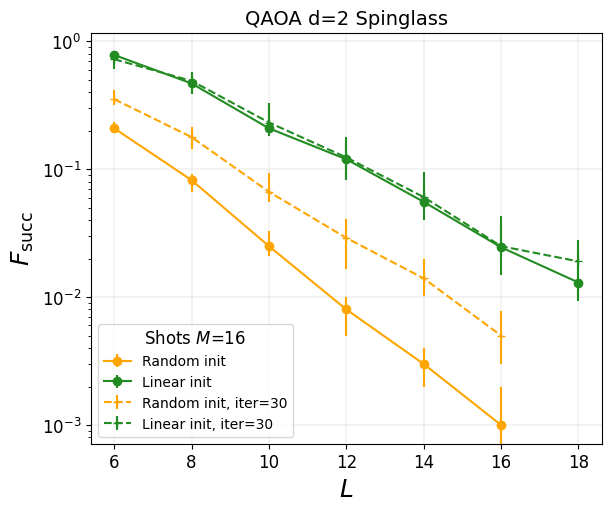

In [68]:
depth = 2
maxiter = 30
shots = 16

def fun_exp(x, a, b):
    return a*2**(b*x)

def fun_lin(x, a, b):
    return a + b*x

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(6,5))

colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
colors_rand = ["orange", "darkorange"]

dat_randinit = data_rand[(data_rand['shots'] == shots) & (data_rand['circ_depth'] == depth) & (data_rand['iter'] == 1) & (data_rand['algo'] == "qaoa")]
dat_linearinit = data_linearinit_rand[(data_linearinit_rand['shots'] == shots) & (data_linearinit_rand['circ_depth'] == depth) & (data_linearinit_rand['iter'] == 1) & (data_linearinit_rand['algo'] == "qaoa")]

x_axes = dat_randinit[dat_randinit['seed'] == 1]['qubits'] #*dat_randinit[dat_randinit['seed'] == 1]["circ_depth"]
y_axes = dat_randinit.groupby(['qubits'])['p_succ_final'].median()
error = [
        (dat_randinit.groupby(['qubits'])['p_succ_final'].median() - dat_randinit.groupby(['qubits'])['p_succ_final'].quantile(0.25)).tolist(),
        (dat_randinit.groupby(['qubits'])['p_succ_final'].quantile(0.75) - dat_randinit.groupby(['qubits'])['p_succ_final'].median()).tolist(),
        ]
ax.errorbar(x_axes, y_axes, yerr=error, marker="o", color=colors_rand[0], label=f"Random init")

x_axes = dat_linearinit[dat_linearinit['seed'] == 1]['qubits'] #*dat_linearinit[dat_linearinit['seed'] == 1]["circ_depth"]
y_axes = dat_linearinit.groupby(['qubits'])['p_succ_final'].median()
error = [
        (dat_linearinit.groupby(['qubits'])['p_succ_final'].median() - dat_linearinit.groupby(['qubits'])['p_succ_final'].quantile(0.25)).tolist(),
        (dat_linearinit.groupby(['qubits'])['p_succ_final'].quantile(0.75) - dat_linearinit.groupby(['qubits'])['p_succ_final'].median()).tolist(),
        ]
ax.errorbar(x_axes, y_axes, yerr=error, marker="o", color=colors[2], label=f"Linear init")

dat_randinit_final = data_rand[(data_rand['shots'] == shots) & (data_rand['circ_depth'] == depth) & (data_rand['iter'] == maxiter) & (data_rand['algo'] == "qaoa")]
dat_linearinit_final = data_linearinit_rand[(data_linearinit_rand['shots'] == shots) & (data_linearinit_rand['circ_depth'] == depth) & (data_linearinit_rand['iter'] == maxiter) & (data_linearinit_rand['algo'] == "qaoa")]

x_axes = dat_randinit_final[dat_randinit_final['seed'] == 1]['qubits'] #*dat_randinit_final[dat_randinit_final['seed'] == 1]["circ_depth"]
y_axes = dat_randinit_final.groupby(['qubits'])['p_succ_final'].median()
error = [
        (dat_randinit_final.groupby(['qubits'])['p_succ_final'].median() - dat_randinit_final.groupby(['qubits'])['p_succ_final'].quantile(0.25)).tolist(),
        (dat_randinit_final.groupby(['qubits'])['p_succ_final'].quantile(0.75) - dat_randinit_final.groupby(['qubits'])['p_succ_final'].median()).tolist(),
        ]
ax.errorbar(x_axes, y_axes, yerr=error, marker="+", ls='--', color=colors_rand[0], label=f"Random init, iter={maxiter}")

x_axes = dat_linearinit_final[dat_linearinit_final['seed'] == 1]['qubits'] #*dat_linearinit_final[dat_linearinit_final['seed'] == 1]["circ_depth"]
y_axes = dat_linearinit_final.groupby(['qubits'])['p_succ_final'].median()
error = [
        (dat_linearinit_final.groupby(['qubits'])['p_succ_final'].median() - dat_linearinit_final.groupby(['qubits'])['p_succ_final'].quantile(0.25)).tolist(),
        (dat_linearinit_final.groupby(['qubits'])['p_succ_final'].quantile(0.75) - dat_linearinit_final.groupby(['qubits'])['p_succ_final'].median()).tolist(),
        ]
ax.errorbar(x_axes, y_axes, yerr=error, marker="+", ls='--', color=colors[2], label=f"Linear init, iter={maxiter}")


ax.set_xticks(np.arange(dat_linearinit['qubits'].min(), dat_linearinit['qubits'].max() + 2, 2))
ax.set_yscale("log", base=10)

ax.grid(linewidth = 0.2)

ax.set_xlabel(r"$L$")
ax.set_ylabel(r"$F_{\mathrm{succ}}$")

ax.set_title(f"QAOA d=2 Spinglass", fontsize=14)
ax.legend(title=r"Shots $M$"+f"={shots} ", loc='lower left', fontsize='small')

plt.savefig(f"img/shots{shots}-fsucc_spinglass.png", dpi=300)


#### Figure A15

In [15]:
data_rand = pd.read_csv("data_spinglass.csv", index_col=0)
data_linearinit_rand = pd.read_csv("data_lininit_rand.csv", index_col=0)

/tmp/ipykernel_394/1046840831.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x_axes, y_axes, yerr=error, marker="o", fmt='o', color=colors_rand[-1], label=f"Random init., no opt.")
/tmp/ipykernel_394/1046840831.py:47: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x_axes, y_axes, yerr=error, marker="o", fmt='o', color=colors[-1], label=f"Linear init., no opt.")


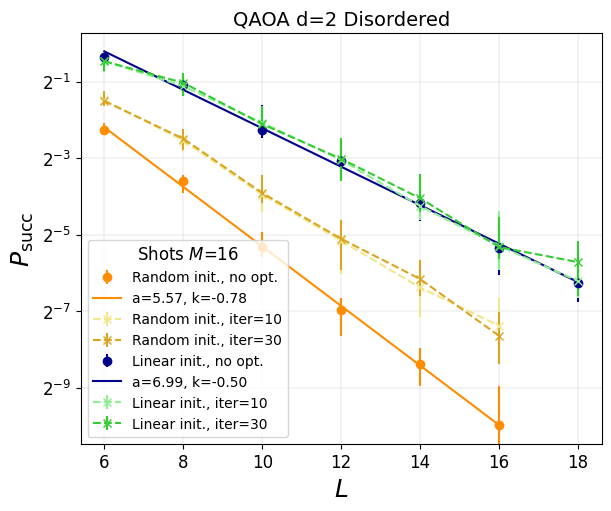

In [51]:
depth = 2
maxiters = [10, 30]
shots = 16

def fun_exp(x, a, b):
    return a*2**(b*x)

def fun_lin(x, a, b):
    return a + b*x

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(6,5))

colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
colors_rand = ["khaki", "goldenrod", "darkgoldenrod", "orange", "darkorange"]

dat_randinit = data_rand[(data_rand['shots'] == shots) & (data_rand['circ_depth'] == depth) & (data_rand['iter'] == 1) & (data_rand['algo'] == "qaoa")]
dat_linearinit = data_linearinit_rand[(data_linearinit_rand['shots'] == shots) & (data_linearinit_rand['circ_depth'] == depth) & (data_linearinit_rand['iter'] == 1) & (data_linearinit_rand['algo'] == "qaoa")]


x_axes = dat_randinit[dat_randinit['seed'] == 1]['qubits'] #*dat_randinit[dat_randinit['seed'] == 1]["circ_depth"]
y_axes = dat_randinit.groupby(['qubits'])['p_succ_final'].median()
error = [
        (dat_randinit.groupby(['qubits'])['p_succ_final'].median() - dat_randinit.groupby(['qubits'])['p_succ_final'].quantile(0.25)).tolist(),
        (dat_randinit.groupby(['qubits'])['p_succ_final'].quantile(0.75) - dat_randinit.groupby(['qubits'])['p_succ_final'].median()).tolist(),
        ]
ax.errorbar(x_axes, y_axes, yerr=error, marker="o", fmt='o', color=colors_rand[-1], label=f"Random init., no opt.")
popt1, _ = optimize.curve_fit(fun_lin, x_axes, np.log2(y_axes))
ax.plot(x_axes, fun_exp(x_axes, 2**popt1[0], popt1[1]), "-", label=f"a={2**popt1[0]:.2f}, k={popt1[1]:.2f}", color=colors_rand[-1])

for k, maxiter in enumerate(maxiters):
    dat_randinit_final = data_rand[(data_rand['shots'] == shots) & (data_rand['circ_depth'] == depth) & (data_rand['iter'] == maxiter) & (data_rand['algo'] == "qaoa")]

    x_axes = dat_randinit_final[dat_randinit_final['seed'] == 1]['qubits'] #*dat_randinit_final[dat_randinit_final['seed'] == 1]["circ_depth"]
    y_axes = dat_randinit_final.groupby(['qubits'])['p_succ_final'].median()
    error = [
            (dat_randinit_final.groupby(['qubits'])['p_succ_final'].median() - dat_randinit_final.groupby(['qubits'])['p_succ_final'].quantile(0.25)).tolist(),
            (dat_randinit_final.groupby(['qubits'])['p_succ_final'].quantile(0.75) - dat_randinit_final.groupby(['qubits'])['p_succ_final'].median()).tolist(),
            ]
    ax.errorbar(x_axes, y_axes, yerr=error, marker="x", ls='--', color=colors_rand[k], label=f"Random init., iter={maxiter}")

x_axes = dat_linearinit[dat_linearinit['seed'] == 1]['qubits'] #*dat_linearinit[dat_linearinit['seed'] == 1]["circ_depth"]
y_axes = dat_linearinit.groupby(['qubits'])['p_succ_final'].median()
error = [
        (dat_linearinit.groupby(['qubits'])['p_succ_final'].median() - dat_linearinit.groupby(['qubits'])['p_succ_final'].quantile(0.25)).tolist(),
        (dat_linearinit.groupby(['qubits'])['p_succ_final'].quantile(0.75) - dat_linearinit.groupby(['qubits'])['p_succ_final'].median()).tolist(),
        ]
ax.errorbar(x_axes, y_axes, yerr=error, marker="o", fmt='o', color=colors[-1], label=f"Linear init., no opt.")
popt2, _ = optimize.curve_fit(fun_lin,  x_axes, np.log2(y_axes))
ax.plot(x_axes, fun_exp(x_axes, 2**popt2[0], popt2[1]), "-", label=f"a={2**popt2[0]:.2f}, k={popt2[1]:.2f}", color=colors[-1])

for k, maxiter in enumerate(maxiters):
    dat_linearinit_final = data_linearinit_rand[(data_linearinit_rand['shots'] == shots) & (data_linearinit_rand['circ_depth'] == depth) & (data_linearinit_rand['iter'] == maxiter) & (data_linearinit_rand['algo'] == "qaoa")]

    x_axes = dat_linearinit_final[dat_linearinit_final['seed'] == 1]['qubits'] #*dat_linearinit_final[dat_linearinit_final['seed'] == 1]["circ_depth"]
    y_axes = dat_linearinit_final.groupby(['qubits'])['p_succ_final'].median()
    error = [
            (dat_linearinit_final.groupby(['qubits'])['p_succ_final'].median() - dat_linearinit_final.groupby(['qubits'])['p_succ_final'].quantile(0.25)).tolist(),
            (dat_linearinit_final.groupby(['qubits'])['p_succ_final'].quantile(0.75) - dat_linearinit_final.groupby(['qubits'])['p_succ_final'].median()).tolist(),
            ]
    ax.errorbar(x_axes, y_axes, yerr=error, marker="x", ls='--', color=colors[k], label=f"Linear init., iter={maxiter}")


ax.set_xticks(np.arange(dat_linearinit['qubits'].min(), dat_linearinit['qubits'].max() + 2, 2))
ax.set_yscale("log", base=2)

ax.grid(linewidth = 0.2)

ax.set_xlabel(r"$L$")
ax.set_ylabel(r"$P_{\mathrm{succ}}$")

ax.set_title(f"QAOA d=2 Disordered", fontsize=14)

handles, labels = plt.gca().get_legend_handles_labels()
order = [2,0,3,4,5,1,6,7]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], title=r"Shots $M$"+f"={shots}", loc='lower left', fontsize='small')
#ax.legend(title=r"Shots $M$"+f"={shots} ", loc='lower left', fontsize='small')

plt.savefig(f"img/fig5.png", dpi=200)


#### Figure A16


In [69]:
data_rand = pd.read_csv("data_spinglass.csv", index_col=0)
data_linearinit_rand = pd.read_csv("data_lininit_rand.csv", index_col=0)

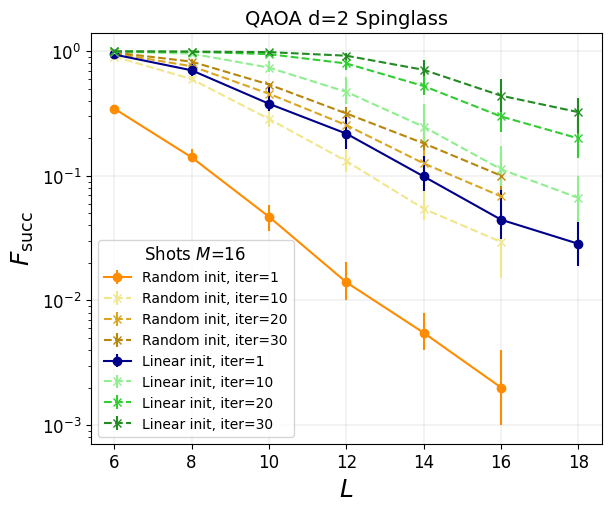

In [70]:
depth = 2
maxiters = [10, 20, 30]
shots = 16

def fun_exp(x, a, b):
    return a*2**(b*x)

def fun_lin(x, a, b):
    return a + b*x

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(6,5))

colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
colors_rand = ["khaki", "goldenrod", "darkgoldenrod", "orange", "darkorange"]

dat_randinit = data_rand[(data_rand['shots'] == shots) & (data_rand['circ_depth'] == depth) & (data_rand['iter'] == 1) & (data_rand['algo'] == "qaoa")]
dat_linearinit = data_linearinit_rand[(data_linearinit_rand['shots'] == shots) & (data_linearinit_rand['circ_depth'] == depth) & (data_linearinit_rand['iter'] == 1) & (data_linearinit_rand['algo'] == "qaoa")]


x_axes = dat_randinit[dat_randinit['seed'] == 1]['qubits'] #*dat_randinit[dat_randinit['seed'] == 1]["circ_depth"]
y_axes = dat_randinit.groupby(['qubits'])['p_succ'].median()
error = [
        (dat_randinit.groupby(['qubits'])['p_succ'].median() - dat_randinit.groupby(['qubits'])['p_succ'].quantile(0.25)).tolist(),
        (dat_randinit.groupby(['qubits'])['p_succ'].quantile(0.75) - dat_randinit.groupby(['qubits'])['p_succ'].median()).tolist(),
        ]
ax.errorbar(x_axes, y_axes, yerr=error, marker="o", color=colors_rand[-1], label=f"Random init, iter=1")
for k, maxiter in enumerate(maxiters):
    dat_randinit_final = data_rand[(data_rand['shots'] == shots) & (data_rand['circ_depth'] == depth) & (data_rand['iter'] == maxiter) & (data_rand['algo'] == "qaoa")]

    x_axes = dat_randinit_final[dat_randinit_final['seed'] == 1]['qubits'] #*dat_randinit_final[dat_randinit_final['seed'] == 1]["circ_depth"]
    y_axes = dat_randinit_final.groupby(['qubits'])['p_succ'].median()
    error = [
            (dat_randinit_final.groupby(['qubits'])['p_succ'].median() - dat_randinit_final.groupby(['qubits'])['p_succ'].quantile(0.25)).tolist(),
            (dat_randinit_final.groupby(['qubits'])['p_succ'].quantile(0.75) - dat_randinit_final.groupby(['qubits'])['p_succ'].median()).tolist(),
            ]
    ax.errorbar(x_axes, y_axes, yerr=error, marker="x", ls='--', color=colors_rand[k], label=f"Random init, iter={maxiter}")

x_axes = dat_linearinit[dat_linearinit['seed'] == 1]['qubits'] #*dat_linearinit[dat_linearinit['seed'] == 1]["circ_depth"]
y_axes = dat_linearinit.groupby(['qubits'])['p_succ'].median()
error = [
        (dat_linearinit.groupby(['qubits'])['p_succ'].median() - dat_linearinit.groupby(['qubits'])['p_succ'].quantile(0.25)).tolist(),
        (dat_linearinit.groupby(['qubits'])['p_succ'].quantile(0.75) - dat_linearinit.groupby(['qubits'])['p_succ'].median()).tolist(),
        ]
ax.errorbar(x_axes, y_axes, yerr=error, marker="o", color=colors[-1], label=f"Linear init, iter=1")
for k, maxiter in enumerate(maxiters):
    dat_linearinit_final = data_linearinit_rand[(data_linearinit_rand['shots'] == shots) & (data_linearinit_rand['circ_depth'] == depth) & (data_linearinit_rand['iter'] == maxiter) & (data_linearinit_rand['algo'] == "qaoa")]

    x_axes = dat_linearinit_final[dat_linearinit_final['seed'] == 1]['qubits'] #*dat_linearinit_final[dat_linearinit_final['seed'] == 1]["circ_depth"]
    y_axes = dat_linearinit_final.groupby(['qubits'])['p_succ'].median()
    error = [
            (dat_linearinit_final.groupby(['qubits'])['p_succ'].median() - dat_linearinit_final.groupby(['qubits'])['p_succ'].quantile(0.25)).tolist(),
            (dat_linearinit_final.groupby(['qubits'])['p_succ'].quantile(0.75) - dat_linearinit_final.groupby(['qubits'])['p_succ'].median()).tolist(),
            ]
    ax.errorbar(x_axes, y_axes, yerr=error, marker="x", ls='--', color=colors[k], label=f"Linear init, iter={maxiter}")


ax.set_xticks(np.arange(dat_linearinit['qubits'].min(), dat_linearinit['qubits'].max() + 2, 2))
ax.set_yscale("log", base=10)

ax.grid(linewidth = 0.2)

ax.set_xlabel(r"$L$")
ax.set_ylabel(r"$F_{\mathrm{succ}}$")

ax.set_title(f"QAOA d=2 Spinglass", fontsize=14)
ax.legend(title=r"Shots $M$"+f"={shots} ", loc='lower left', fontsize='small')

plt.savefig(f"img/shots{shots}-fsucc-maxiters_spinglass.png", dpi=300)


#### Figure A17


In [3]:
data_lininit_spinglass = pd.read_csv("data_spinglass_iter1.csv", index_col=0)
data_lininit_spinglass.describe()

t   shots    iter       p_succ       qubits   circ_depth  \
count  1500.0  1500.0  1500.0  1500.000000  1500.000000  1500.000000   
mean     16.0    16.0     1.0     0.730276    13.000000    12.400000   
std       0.0     0.0     0.0     0.390488     5.746478    10.914184   
min      16.0    16.0     1.0     0.000000     4.000000     2.000000   
25%      16.0    16.0     1.0     0.400750     8.000000     4.000000   
50%      16.0    16.0     1.0     0.994000    13.000000     8.000000   
75%      16.0    16.0     1.0     1.000000    18.000000    16.000000   
max      16.0    16.0     1.0     1.000000    22.000000    32.000000   

         succ_true   succ_false  p_succ_final         seed  
count  1500.000000  1500.000000   1500.000000  1500.000000  
mean    730.276000   269.724000      0.668434    15.500000  
std     390.487875   390.487875      0.399899     8.658328  
min       0.000000     0.000000      0.000000     1.000000  
25%     400.750000     0.000000      0.226750     8.000000  
50%     994.000000     6.000000      0.915500    15.500000  
75%    1000.000000   599.250000      1.000000    23.000000  
max    1000.000000  1000.000000      1.000000    30.000000

In [4]:
data_lininit_ferro = pd.read_csv("data_opt16shots.csv", index_col=0)
data_lininit_ferro.describe()

t  shots   iter      p_succ      qubits  circ_depth    succ_true  \
count  100.0  100.0  100.0  100.000000  100.000000  100.000000   100.000000   
mean    16.0   16.0    1.0    0.911450   13.000000   18.200000   911.450000   
std      0.0    0.0    0.0    0.227044    5.773503   11.243854   227.044265   
min     16.0   16.0    1.0    0.017000    4.000000    2.000000    17.000000   
25%     16.0   16.0    1.0    0.989750    8.000000    8.000000   989.750000   
50%     16.0   16.0    1.0    1.000000   13.000000   18.000000  1000.000000   
75%     16.0   16.0    1.0    1.000000   18.000000   28.000000  1000.000000   
max     16.0   16.0    1.0    1.000000   22.000000   36.000000  1000.000000   

       succ_false  p_succ_final  
count  100.000000    100.000000  
mean    88.550000      0.866420  
std    227.044265      0.266735  
min      0.000000      0.009000  
25%      0.000000      0.908500  
50%      0.000000      0.998000  
75%     10.250000      1.000000  
max    983.000000      1.000000

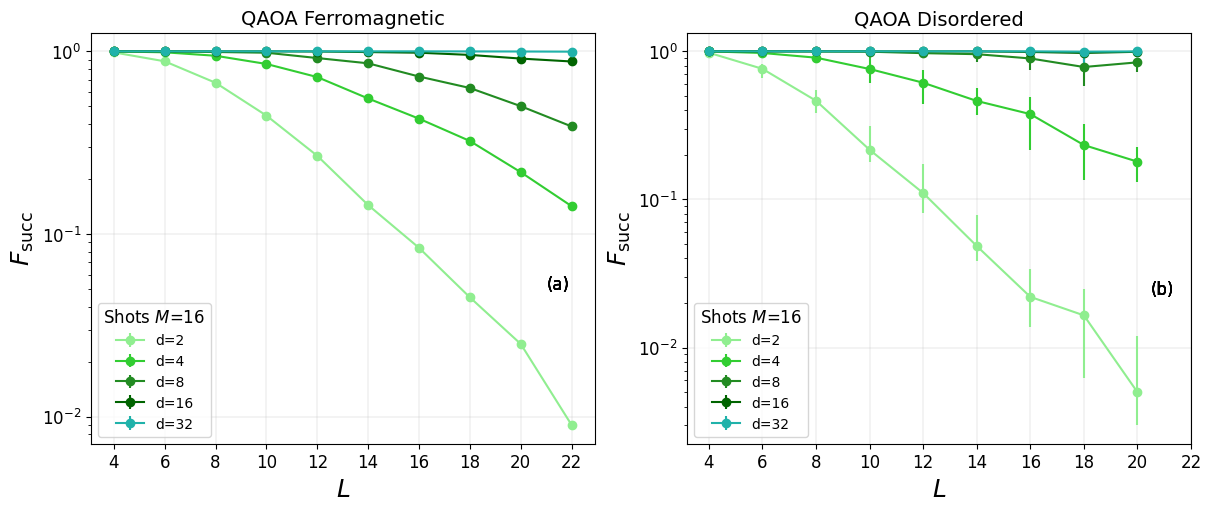

In [5]:
depths = [2,4,8,16,32]
algo = 'qaoa'
which_prob = 'p_succ_final'

def fun_exp(x, a, b):
    return a*2**(b*x)

def fun_lin(x, a, b):
    return a + b*x

fig = plt.figure(constrained_layout=True, figsize=(12,5))
#fig = plt.figure(constrained_layout=True, figsize=(16,5))
subplots = fig.subplots(1,2)
plots1, plots2 = [], [] 

for i, subplot in enumerate(subplots.ravel()):

    colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']

    if i==0:
        for k, depth in enumerate(depths):
            dat = data_lininit_ferro[(data_lininit_ferro['algo'] == algo) & (data_lininit_ferro['circ_depth'] == depth)]
            dat = dat[dat[which_prob]!=0]

            x_axes = dat['qubits'] #*dat[dat['seed'] == 1]["circ_depth"]
            y_axes = dat.groupby(['qubits'])[which_prob].median()
            error = [
                (y_axes - dat.groupby(['qubits'])[which_prob].quantile(0.25)).tolist(),
                (dat.groupby(['qubits'])[which_prob].quantile(0.75) - y_axes).tolist(),
                ]

            #popt1, _ = optimize.curve_fit(fun_lin,  x_axes[2:], np.log2(y_axes[2:]))
            subplot.errorbar(x_axes, y_axes, yerr=error, marker="o", label=f"d={depth}", color=colors[k])
            subplot.set_title(f"QAOA Ferromagnetic", fontsize=14)
            subplot.text(21, 0.05, '(a)')



    if i==1:
        for k, depth in enumerate(depths):
            dat = data_lininit_spinglass[(data_lininit_spinglass['algo'] == algo) & (data_lininit_spinglass['circ_depth'] == depth)]
            dat = dat[dat[which_prob]!=0]

            x_axes = dat[dat['seed'] == 1]['qubits']
            y_axes = dat.groupby(['qubits'])[which_prob].median()
            error = [
                (y_axes - dat.groupby(['qubits'])[which_prob].quantile(0.25)).tolist(),
                (dat.groupby(['qubits'])[which_prob].quantile(0.75) - y_axes).tolist(),
                ]

            #popt2, _ = optimize.curve_fit(fun_lin,  x_axes[2:], np.log2(y_axes[2:]))
            subplot.errorbar(x_axes, y_axes, yerr=error, marker="o", label=f"d={depth}", color=colors[k])
            subplot.set_title(f"QAOA Disordered", fontsize=14)
            subplot.text(20.5, 0.023, '(b)')


    subplot.set_xticks(np.arange(data_lininit_spinglass['qubits'].min(), data_lininit_spinglass['qubits'].max() + 2, 2))
    subplot.set_yscale("log", base=10)

    subplot.grid(linewidth = 0.2)

    subplot.set_xlabel(r"$L$")
    subplot.set_ylabel(r"$F_{\mathrm{succ}}$")

    subplot.legend(title=r"Shots $M$"+f"=16", loc='lower left', fontsize='small')

plt.savefig("img/fig6.png", dpi=200)


### Figure A18


In [3]:
filenames = [
            "results/gradient/shotsNone_maxiter080_eta1.json",
            "results/gradient/shotsNone_maxiter080_eta01.json",
            "results/gradient/shotsNone_maxiter080_eta001.json",
            "results/gradient/shotsNone_maxiter240.json"
            ]
runs = []
for filename in filenames: 
    with open(filename, "r") as file:
        # data are a list with #initial_points elements
        runs.append(json.load(file)[0]["loss"])

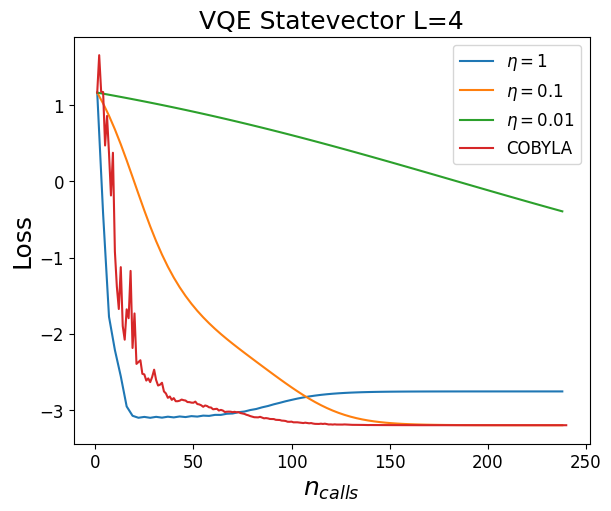

In [4]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(6,5))

ax.plot(np.arange(1,241,3), runs[0], label=r"$\eta=1$")
ax.plot(np.arange(1,241,3), runs[1], label=r"$\eta=0.1$")
ax.plot(np.arange(1,241,3), runs[2], label=r"$\eta=0.01$")
ax.plot(np.arange(1,241), runs[3], label="COBYLA")
ax.set_xlabel(r"$n_{calls}$")
ax.set_ylabel("Loss")
ax.legend()
ax.set_title("VQE Statevector L=4")

plt.savefig("img/figa18.png", dpi=200)



### Figure A19


In [5]:
filenames = [
            "results/no_grad/shots0016_maxiter080_eta1.json",
            "results/no_grad/shots0016_maxiter080_eta01.json",
            "results/no_grad/shots0016_maxiter080_eta001.json",
            "results/no_grad/shots0016_maxiter080_eta0001.json",
            "results/no_grad/shots0016_maxiter080_eta00001.json",
            "results/no_grad/shots0016_maxiter240.json"
            ]
runs = []
for filename in filenames: 
    with open(filename, "r") as file:
        # data are a list with #initial_points elements
        runs.append(json.load(file)[0]["loss"])

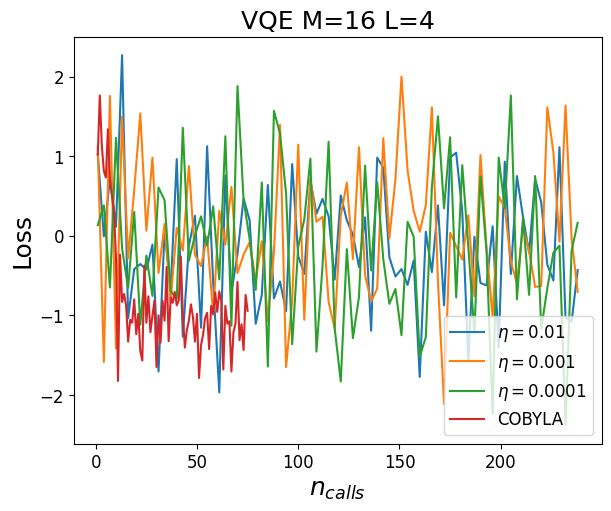

In [6]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(6,5))

#ax.plot(np.arange(1,241,3), runs[0], label=r"$\eta=1$")
#ax.plot(np.arange(1,241,3), runs[1], label=r"$\eta=0.1$")
ax.plot(np.arange(1,241,3), runs[2], label=r"$\eta=0.01$")
ax.plot(np.arange(1,241,3), runs[3], label=r"$\eta=0.001$")
ax.plot(np.arange(1,241,3), runs[4], label=r"$\eta=0.0001$")
ax.plot(np.arange(1,76), runs[5], label="COBYLA")
ax.set_xlabel(r"$n_{calls}$")
ax.set_ylabel("Loss")
ax.legend()
ax.set_title("VQE " + r"M=16" + r" L=4")

plt.savefig("img/figa19.png", dpi=200)


### Figure A20


In [7]:
filenames = [
            "results/no_grad/shots2048_maxiter080_eta01.json",
            "results/no_grad/shots2048_maxiter080_eta001.json",
            "results/no_grad/shots2048_maxiter080_eta0001.json",
            "results/no_grad/shots2048_maxiter240.json"
            ]
runs = []
for filename in filenames: 
    with open(filename, "r") as file:
        # data are a list with #initial_points elements
        runs.append(json.load(file)[0]["loss"])

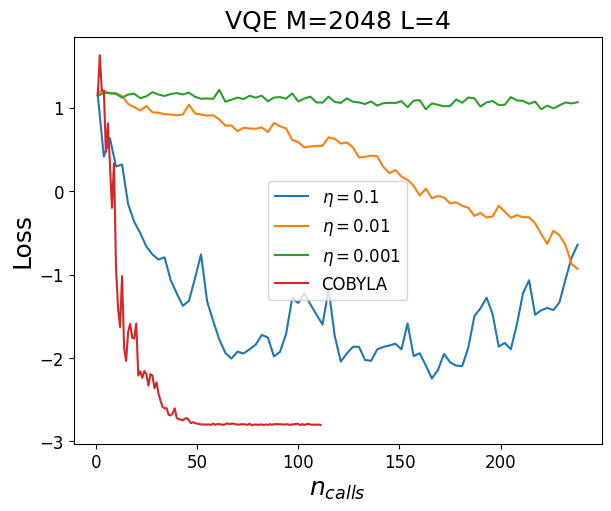

In [8]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(6,5))

ax.plot(np.arange(1,241,3), runs[0], label=r"$\eta=0.1$")
ax.plot(np.arange(1,241,3), runs[1], label=r"$\eta=0.01$")
ax.plot(np.arange(1,241,3), runs[2], label=r"$\eta=0.001$")
ax.plot(np.arange(1,112), runs[-1], label="COBYLA")
ax.set_xlabel(r"$n_{calls}$")
ax.set_ylabel("Loss")
ax.legend()
ax.set_title("VQE " + r"M=2048" + r" L=4")

plt.savefig("img/figa20.png", dpi=200)


### Figure A21


In [14]:
datagrad = pd.read_csv("datagrad_m2048.csv", index_col=0)
datagrad.describe()

t   shots        iter     p_succ     qubits  circ_depth  \
count  4.600000e+01    46.0   46.000000  46.000000  46.000000        46.0   
mean   3.536807e+05  2048.0  172.695652   0.791413  10.739130         1.0   
std    4.008803e+05     0.0  195.742333   0.320658   4.548185         0.0   
min    6.144000e+03  2048.0    3.000000   0.009000   4.000000         1.0   
25%    6.144000e+04  2048.0   30.000000   0.633500   6.500000         1.0   
50%    1.228800e+05  2048.0   60.000000   0.990000  10.000000         1.0   
75%    6.144000e+05  2048.0  300.000000   1.000000  14.000000         1.0   
max    1.228800e+06  2048.0  600.000000   1.000000  18.000000         1.0   

         succ_true  succ_false  p_succ_final  
count    46.000000   46.000000     46.000000  
mean    791.413043  208.586957      0.453109  
std     320.657628  320.657628      0.358614  
min       9.000000    0.000000      0.004000  
25%     633.500000    0.000000      0.115000  
50%     990.000000   10.000000      0.398000  
75%    1000.000000  366.500000      0.768000  
max    1000.000000  991.000000      0.969000

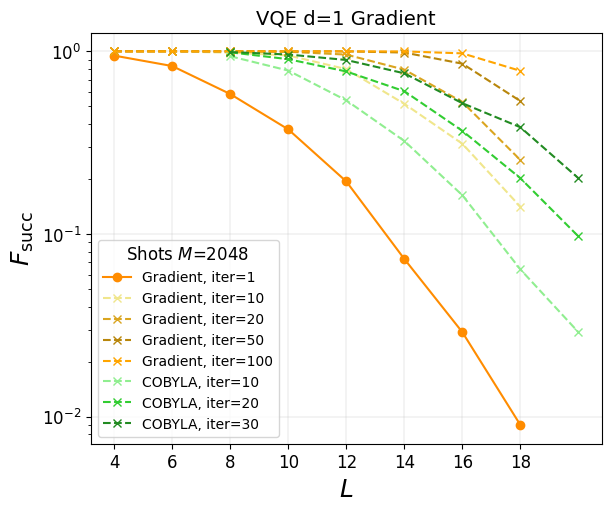

In [36]:
depth = 1
maxiters_grad = [30, 60, 150, 300]
maxiters_nograd = [10, 20, 30]
shots = 2048
algo = "vqe"

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(6,5))

colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
colors_rand = ["khaki", "goldenrod", "darkgoldenrod", "orange", "darkorange"]

dat_grad = datagrad[(datagrad['shots'] == shots) & (datagrad['circ_depth'] == depth) & (datagrad['iter'] == 3) & (datagrad['algo'] == algo)]

x_axes = dat_grad['qubits'] #*dat_grad[dat_grad['seed'] == 1]["circ_depth"]
y_axes = dat_grad['p_succ']
ax.plot(x_axes, y_axes, marker="o", color=colors_rand[-1], label=f"Gradient, iter=1")
for k, maxiter in enumerate(maxiters_grad):
    dat_grad_final = datagrad[(datagrad['shots'] == shots) & (datagrad['circ_depth'] == depth) & (datagrad['iter'] == maxiter) & (datagrad['algo'] == algo)]

    x_axes = dat_grad_final['qubits'] #*dat_grad_final[dat_grad_final['seed'] == 1]["circ_depth"]
    y_axes = dat_grad_final['p_succ']
    ax.plot(x_axes, y_axes, marker="x", ls='--', color=colors_rand[k], label=f"Gradient, iter={maxiter//3}")

dat_nograd = ferro_df[(ferro_df['shots'] == shots) & (ferro_df['circ_depth'] == depth) & (ferro_df['iter'] == 3) & (ferro_df['algo'] == algo)]

x_axes = dat_nograd['qubits'] #*dat_nograd[dat_nograd['seed'] == 1]["circ_depth"]
y_axes = dat_nograd['p_succ']
#ax.plot(x_axes, y_axes, marker="o", color=colors[-1], label=f"COBYLA, iter=1")
for k, maxiter in enumerate(maxiters_nograd):
    dat_grad_final = ferro_df[(ferro_df['shots'] == shots) & (ferro_df['circ_depth'] == depth) & (ferro_df['iter'] == maxiter) & (ferro_df['algo'] == algo)]

    x_axes = dat_grad_final['qubits'] #*dat_grad_final[dat_grad_final['seed'] == 1]["circ_depth"]
    y_axes = dat_grad_final['p_succ']
    ax.plot(x_axes, y_axes, marker="x", ls='--', color=colors[k], label=f"COBYLA, iter={maxiter}")


ax.set_xticks(np.arange(dat_grad['qubits'].min(), dat_grad['qubits'].max() + 2, 2))
ax.set_yscale("log", base=10)

ax.grid(linewidth = 0.2)

ax.set_xlabel(r"$L$")
ax.set_ylabel(r"$F_{\mathrm{succ}}$")

ax.set_title(f"VQE d=1 Gradient", fontsize=14)
ax.legend(title=r"Shots $M$"+f"={shots} ", loc='lower left', fontsize='small')

plt.savefig(f"img/figa21", dpi=300)


### Figure A22


In [6]:
datagrad_1632 = pd.read_csv("datagrad_m1632.csv", index_col=0)
datagrad_1632.describe()

t        shots        iter      p_succ      qubits  \
count  1.020000e+02   102.000000  102.000000  102.000000  102.000000   
mean   1.395360e+05   877.019608  114.647059    0.559853   11.274510   
std    2.988162e+05  1004.627974  133.011177    0.433480    5.210722   
min    4.800000e+02    16.000000    3.000000    0.000000    4.000000   
25%    1.440000e+03    16.000000   30.000000    0.031500    6.000000   
50%    2.880000e+03    32.000000   60.000000    0.701500   10.000000   
75%    1.228800e+05  2048.000000  150.000000    0.999000   16.000000   
max    1.228800e+06  2048.000000  600.000000    1.000000   20.000000   

       circ_depth    succ_true   succ_false  p_succ_final  
count       102.0   102.000000   102.000000    102.000000  
mean          1.0   559.852941   440.147059      0.248333  
std           0.0   433.480147   433.480147      0.325600  
min           1.0     0.000000     0.000000      0.000000  
25%           1.0    31.500000     1.000000      0.002250  
50%           1.0   701.500000   298.500000      0.054000  
75%           1.0   999.000000   968.500000      0.506250  
max           1.0  1000.000000  1000.000000      0.969000

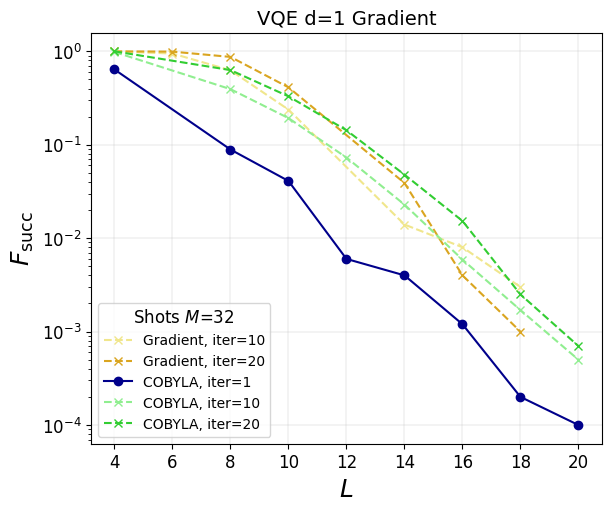

In [13]:
depth = 1
maxiters_grad = [30, 60]
maxiters_nograd = [10, 20]
shots = 32
algo = "vqe"

fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(6,5))

colors = ['lightgreen', 'limegreen', 'forestgreen', 'darkgreen','lightseagreen', 'skyblue', 'cornflowerblue' , 'royalblue', 'mediumblue', 'darkblue']
colors_rand = ["khaki", "goldenrod", "darkgoldenrod", "orange", "darkorange"]

#dat_grad_1632 = datagrad_1632[(datagrad_1632['shots'] == shots) & (datagrad_1632['circ_depth'] == depth) & (datagrad_1632['iter'] == 3) & (datagrad_1632['algo'] == algo)]

#x_axes = dat_grad_1632['qubits'] #*dat_grad_1632[dat_grad_1632['seed'] == 1]["circ_depth"]
#y_axes = dat_grad_1632['p_succ']
#ax.plot(x_axes, y_axes, marker="o", color=colors_rand[-1], label=f"Gradient, iter=1")
for k, maxiter in enumerate(maxiters_grad):
    dat_grad_final = datagrad_1632[(datagrad_1632['shots'] == shots) & (datagrad_1632['circ_depth'] == depth) & (datagrad_1632['iter'] == maxiter) & (datagrad_1632['algo'] == algo)]

    x_axes = dat_grad_final['qubits'] #*dat_grad_final[dat_grad_final['seed'] == 1]["circ_depth"]
    y_axes = dat_grad_final['p_succ']
    ax.plot(x_axes, y_axes, marker="x", ls='--', color=colors_rand[k], label=f"Gradient, iter={maxiter//3}")

dat_nograd = ferro_df[(ferro_df['shots'] == shots) & (ferro_df['circ_depth'] == depth) & (ferro_df['iter'] == 1) & (ferro_df['algo'] == algo)]

x_axes = dat_nograd['qubits'] #*dat_nograd[dat_nograd['seed'] == 1]["circ_depth"]
y_axes = dat_nograd['p_succ']
ax.plot(x_axes, y_axes, marker="o", color=colors[-1], label=f"COBYLA, iter=1")
for k, maxiter in enumerate(maxiters_nograd):
    dat_grad_final = ferro_df[(ferro_df['shots'] == shots) & (ferro_df['circ_depth'] == depth) & (ferro_df['iter'] == maxiter) & (ferro_df['algo'] == algo)]

    x_axes = dat_grad_final['qubits'] #*dat_grad_final[dat_grad_final['seed'] == 1]["circ_depth"]
    y_axes = dat_grad_final['p_succ']
    ax.plot(x_axes, y_axes, marker="x", ls='--', color=colors[k], label=f"COBYLA, iter={maxiter}")


ax.set_xticks(np.arange(dat_nograd['qubits'].min(), dat_nograd['qubits'].max() + 1, 2))
ax.set_yscale("log", base=10)

ax.grid(linewidth = 0.2)

ax.set_xlabel(r"$L$")
ax.set_ylabel(r"$F_{\mathrm{succ}}$")

ax.set_title(f"VQE d=1 Gradient", fontsize=14)
ax.legend(title=r"Shots $M$"+f"={shots} ", loc='lower left', fontsize='small')

plt.savefig(f"img/figa22-M{shots}", dpi=300)


### Scaling computation


In [ ]:


L = 100
# depth
d = 2
#seconds
t_gate = 10**(-8) 
# exponent
k = 0.5

print(f"Month {2**(k*L) * d * t_gate / 60 / 60 / 24 / 30}") # months


### Figure A2
Energy per sample increasing L


In [ ]:
spins = 8
dim = 1
h_ext = 0.05
type_ising = "random"
seed = 42 # not used

J, h = utils.get_ising_params(spins, h_ext, type_ising, seed)
print(J, h)

adj_dict = {}
for i in range(spins):
    if i == spins - 1:
        continue
    adj_dict[(i, i + 1)] = J[i]
# class devoted to set the couplings and get the energy
model = ising.Ising(spins, dim=dim, adj_dict=adj_dict, h_field=h)

energies = []
for i, sample in enumerate(itertools.product([0, 1], repeat=model.spins)):
    print(sample)
    energies.append(model.energy(np.asarray(sample) * 2 - 1))

In [ ]:
plt.plot(energies)

In [ ]:
# Select length of axes and the space between tick labels
xmin, xmax, ymin, ymax = 0, 265, -8, 8

# Plot points
fig, ax = plt.subplots(figsize=(8, 4))


# Draw lines connecting points to axes
line1, = ax.plot(np.arange(5, len(energies)+5), energies, color='black', linewidth=1.5)

# Set identical scales for both axes
ax.set(xlim=(xmin-1, xmax+1), ylim=(ymin-1, ymax+1))

# Set bottom and left spines as x and y axes of coordinate system
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Create 'x' and 'y' labels placed at the end of the axes
ax.set_xlabel('L', size=18, labelpad=-24, x=1.03)
ax.set_ylabel('Energy', size=18, labelpad=-21, y=1.02, rotation=0)

# Draw arrows
arrow_fmt = dict(markersize=4, color='black', clip_on=False)
ax.plot((1), (0), marker='>', transform=ax.get_yaxis_transform(), **arrow_fmt)
ax.plot((0), (1), marker='^', transform=ax.get_xaxis_transform(), **arrow_fmt)

ax.tick_params(  
    axis='both',   # changes apply to both axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left = True,
    right=False,
    labelleft=True,
    labelbottom=False,
)

plt.savefig("figa2.png", dpi=300)


## Ferromagnetic model



In [ ]:
import itertools
import os

import numpy as np
import pandas as pd
import json
from scipy import optimize
import matplotlib.pyplot as plt

In [ ]:
sizes = [4,6,8,10,12,14,16,18,20]

ferro_all = []
for size in sizes:
    ferro_all.append(pd.read_csv(f"data_n{size}-test.csv"))

In [ ]:
ferro_df = pd.concat(ferro_all, ignore_index=True)
ferro_df .to_csv(f"data_ferro-UNION.csv", index=False)

In [ ]:
depth = 2

fig = plt.figure(constrained_layout=True, figsize=(16,10))
subplots = fig.subplots(2,3)
for (qubits, data), subplot in zip(ferro_df[(ferro_df['algo'] == 'vqe') & (ferro_df['circ_depth'] == depth)].groupby('qubits'), subplots.ravel()):
    print(qubits)
    # for shot, dat in data.groupby('shots'):
    #     x_axes = dat['t']
    #     y_axes = dat['p_succ']

    # subplot.plot(np.arange(0,2**(5+qubits),2), 1 - (1-1/(2**qubits))**np.arange(0,2**(5+qubits),2), '--', color="black", label="Random sampling")
    # subplot.set_xscale("log", base=2)

    # subplot.set_xlabel(r"$n_{calls}$")
    # subplot.set_ylabel(r"$F('success')$")

    # subplot.set_title(f"N={qubits} VQE p={depth}")
    # subplot.legend(title='Shots')

In [ ]:
ferro_df['qubits']

In [ ]:
prendere varianza dei parametri e mettila come errorbar
cambiare nome del QAOA+ con meno oppure like
attenzione a qaoa, inserire Rz (ext_field)
g100-scratch path dove salvare


## Process raw data


In [ ]:
import itertools
import os
import math

import numpy as np
import pandas as pd
import json
from scipy import optimize
import matplotlib.pyplot as plt

In [ ]:
dims = np.arange(4,20,2)
circ_depths = [2]
algs = ["qaoa"]
seeds = np.arange(1, 31)


model_info = [(n, algo, p, seed) for p in circ_depths for algo in algs for n in dims for seed in seeds] 

In [ ]:
# NOT TO USE, SEE BELOW
run_info = {"t": [], "shots": [], "iter": [], "p_succ": [], "qubits": [], "circ_depth": [], "algo": [], "seed": []}
for (n, algo, p, seed) in model_info:
    dir_path = f"results/N{n}/{algo}p{p}_{seed}/"
    if not os.path.isdir(dir_path):
        #print(f"{dir_path} does not exist")
        continue
    for filename in sorted(os.listdir(dir_path)):
        filename = dir_path + filename
        with open(filename, "r") as file:
            # data are a list with #initial_points elements
            runs = json.load(file)
        ever_founds = []
        iterations = [] 
        # for each shot and iteration param
        # we randomized the initial point
        # to estimate the right probability
        for r in runs:
            ever_founds.append(bool(r["ever_found"]))
            iterations.append(r["nfev"])
        # compute p('found minimum')
        #run_info["p_succ"].append(ever_founds)
        run_info["p_succ"].append(
            np.mean(ever_founds, dtype=np.float128 )
        )  # float128 to avoid to many zeros
        run_info["iter"].append(int(math.ceil(np.mean(iterations))))
        # maxiter*shots = actual number of iteration
        run_info["t"].append(r["shots"] * run_info["iter"][-1])
        run_info["shots"].append(r["shots"])
        run_info["qubits"].append(n)
        run_info["circ_depth"].append(p)
        run_info["algo"].append(algo)
        run_info["seed"].append(seed)
        
jobs_df = pd.DataFrame(run_info)
jobs_df.to_csv(f"data_n14-12_PART.csv")

In [ ]:
dims = np.arange(4,20,2)
circ_depths = [2,4]
algs = ["qaoa"]
#seeds = np.arange(1, 31) 

model_info = [(n, algo, p) for p in circ_depths for algo in algs for n in dims] 

In [ ]:
run_info = {"t": [], "shots": [], "iter": [], "p_succ": [], "qubits": [], "circ_depth": [], "algo": [], "succ_true": [], "succ_false": [], 'p_succ_final': []}
for (n, algo, p) in model_info:
    dir_path = f"N{n}/{algo}p{p}/"
    if not os.path.isdir(dir_path):
        print(f"{dir_path} does not exist")
        continue
    for filename in sorted(os.listdir(dir_path)):
        filename = dir_path + filename
        with open(filename, "r") as file:
            # data are a list with #initial_points elements
            runs = json.load(file)
        ever_founds = []
        success_final = []
        iterations = [] 
        # for each shot and iteration param
        # we randomized the initial point
        # to estimate the right probability
        for r in runs:
            ever_founds.append(r["ever_found"])
            iterations.append(r["nfev"])
            success_final.append(r["success"])
        # compute p('found minimum')
        #run_info["p_succ"].append([ever_founds])
        run_info["p_succ"].append(
            np.mean(np.asarray(ever_founds, dtype=np.float128))
        )  # float128 to avoid to many zeros
        run_info["p_succ_final"].append(
            np.mean(np.asarray(success_final, dtype=np.float128))
        )  # float128 to avoid to many zeros
        run_info["succ_true"].append(np.count_nonzero(ever_founds))
        run_info["succ_false"].append(len(ever_founds) - np.count_nonzero(ever_founds))

        run_info["iter"].append(int(math.ceil(np.mean(np.asarray(iterations)))))
        # maxiter*shots = actual number of iteration
        run_info["t"].append(int(r["shots"] * run_info["iter"][-1]))
        run_info["shots"].append(int(r["shots"]))
        run_info["qubits"].append(int(n))
        run_info["circ_depth"].append(int(p))
        run_info["algo"].append(str(algo))
        
jobdf = pd.DataFrame.from_dict(run_info)
jobdf.to_csv(f"data_linopt.csv")

In [ ]:
print(pd.load_csv("data-opt.csv"))

In [ ]:
jobs_correct = pd.read_csv("data_n14-12_PART.csv")

fig = plt.figure(constrained_layout=True, figsize=(12,5))
subplots = fig.subplots(1,2)
for (qubits, data), subplot in zip(jobs_correct[(jobs_correct['algo'] == 'qaoa') & (jobs_correct['circ_depth'] == 1) & (jobs_correct['iter'] < 25)].groupby('qubits'), subplots):
    for shot, dat in data.groupby('shots'):
        x_axes = dat[dat['seed'] == 1]['t']*dat[dat['seed'] == 1]['circ_depth'].mean()
        y_axes = dat.groupby(['iter'])['p_succ'].median()
        error = [
            (dat.groupby(['iter'])['p_succ'].median() - dat.groupby(['iter'])['p_succ'].quantile(0.25)).tolist(),
            (dat.groupby(['iter'])['p_succ'].quantile(0.75) - dat.groupby(['iter'])['p_succ'].median()).tolist(),
            ]
        subplot.errorbar(x_axes, y_axes, yerr=error, marker="o", label=f"{shot}")
        subplot.fill_between(x_axes, dat.groupby(['iter'])['p_succ'].min(), dat.groupby(['iter'])['p_succ'].max(), alpha=0.3)

    subplot.plot(np.arange(0,2**(5+qubits),2), 1 - (1-1/(2**qubits))**np.arange(0,2**(5+qubits),2), '--', color="black", label="Random sampling")
    subplot.set_xscale("log", base=2)

    subplot.set_xlabel("iterations x shots x depth")
    subplot.set_ylabel(r"$F('success')$")

    subplot.set_title(f"N={qubits} QAOA p={int(dat[dat['seed'] == 1]['circ_depth'].mean())}")
    subplot.legend(title='Shots')

plt.savefig('spinglass_p1.png')